<a href="https://colab.research.google.com/github/sanaaria/Big-data/blob/main/Big_data_HW02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget http://ai.stanford.edu/~jkrause/car196/cars_train.tgz
!tar -xf cars_train.tgz

--2022-11-19 17:22:20--  http://ai.stanford.edu/~jkrause/car196/cars_train.tgz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 979269282 (934M) [application/x-gzip]
Saving to: ‘cars_train.tgz’

cars_train.tgz      100%[===================>] 933.90M  39.3MB/s    in 29s     

2022-11-19 17:22:48 (32.6 MB/s) - ‘cars_train.tgz’ saved [979269282/979269282]



In [2]:
train_images = "cars_train"
!wget https://ai.stanford.edu/~jkrause/cars/car_devkit.tgz
!tar -xf car_devkit.tgz

--2022-11-19 17:22:56--  https://ai.stanford.edu/~jkrause/cars/car_devkit.tgz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 330960 (323K) [application/x-gzip]
Saving to: ‘car_devkit.tgz’

car_devkit.tgz      100%[===================>] 323.20K   455KB/s    in 0.7s    

2022-11-19 17:22:57 (455 KB/s) - ‘car_devkit.tgz’ saved [330960/330960]



In [3]:
from scipy.io import loadmat
import pandas as pd
import numpy as np

mat_train = loadmat('devkit/cars_train_annos.mat')
meta = loadmat('devkit/cars_meta.mat')

labels = list()
m = list(meta['class_names'])
for i in range(len(m[0])):
  labels.append(m[0][i][0])

n=list(mat_train['annotations'][0])
Class = []
for i in range(len(n)):
  Class.append(n[i][4][0][0])

name = []
for i in range(len(n)):
  name.append(n[i][5][0])

tupleX = ()
train = []
for i in range(len(name)):
  s=0
  tupleX = ()
  tupleX = tupleX + (name[i],)
  tupleX = tupleX + (Class[i],)
  s = int(Class[i]) - 1
  tupleX = tupleX + (labels[s],)
  train.append(tupleX)


In [4]:
train[:5]

[('00001.jpg', 14, 'Audi TTS Coupe 2012'),
 ('00002.jpg', 3, 'Acura TL Sedan 2012'),
 ('00003.jpg', 91, 'Dodge Dakota Club Cab 2007'),
 ('00004.jpg', 134, 'Hyundai Sonata Hybrid Sedan 2012'),
 ('00005.jpg', 106, 'Ford F-450 Super Duty Crew Cab 2012')]

In [5]:
import os
from PIL import Image
from torchvision import transforms
# needed input dimensions for the CNN
input_dim = (224,224)
input_dir_cnn = "images/input_images_cnn"
os.makedirs(input_dir_cnn, exist_ok = True)
transformation_for_cnn_input = transforms.Compose([transforms.Resize(input_dim)])
for image_name in os.listdir(train_images):
  I = Image.open(os.path.join(train_images, image_name))
  newI = transformation_for_cnn_input(I)
  newI.save(os.path.join(input_dir_cnn, image_name))
  newI.close()
  I.close()

In [6]:
import torch
from torchvision import models

class Img2VecResnet18(): 
  def __init__(self):
    self.device = torch.device("cpu")
    self.numberFeatures = 512
    self.modelName = "resnet-18"
    self.model, self.featureLayer = self.getFeatureLayer()
    self.model = self.model.to(self.device)
    self.model.eval()
    self.toTensor = transforms.ToTensor()
    self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                          std=[0.229, 0.224, 0.225])
  def getFeatureLayer(self):
    cnnModel = models.resnet18(pretrained=True) 
    layer = cnnModel._modules.get('avgpool') 
    self.layer_output_size = 512
    return cnnModel, layer

  def getVec(self, img):
    image = self.normalize(self.toTensor(img)).unsqueeze(0).to(self.device) 
    embedding = torch.zeros(1, self.numberFeatures, 1, 1)
    def copyData(m, i, o): embedding.copy_(o.data)
    h = self.featureLayer.register_forward_hook(copyData) 
    self.model(image)
    h.remove()
    return embedding.numpy()[0, :, 0, 0]

In [8]:
from tqdm import tqdm
import os
from PIL import Image
img2vec = Img2VecResnet18()
allVectors = {}
for image in tqdm(os.listdir(input_dir_cnn)):
  I = Image.open(os.path.join(input_dir_cnn, image))
  I_rgb = I.convert('RGB')
  print (image)
  vec = img2vec.getVec(I_rgb)
  allVectors[image] = vec
  I.close()

  0%|          | 2/8144 [00:00<10:08, 13.39it/s]

05621.jpg
01075.jpg
02175.jpg


  0%|          | 4/8144 [00:00<10:03, 13.50it/s]

06783.jpg
02168.jpg
03930.jpg


  0%|          | 8/8144 [00:00<11:53, 11.40it/s]

05369.jpg
03151.jpg
06521.jpg


  0%|          | 10/8144 [00:00<11:11, 12.11it/s]

04083.jpg
01299.jpg
04101.jpg


  0%|          | 14/8144 [00:01<10:35, 12.80it/s]

03021.jpg
04891.jpg
08125.jpg


  0%|          | 16/8144 [00:01<10:18, 13.13it/s]

03774.jpg
07185.jpg
07251.jpg


  0%|          | 20/8144 [00:01<10:09, 13.33it/s]

05419.jpg
02816.jpg
05118.jpg


  0%|          | 22/8144 [00:01<10:18, 13.13it/s]

04149.jpg
04541.jpg
05505.jpg


  0%|          | 26/8144 [00:02<10:03, 13.46it/s]

05273.jpg
05127.jpg
03919.jpg


  0%|          | 28/8144 [00:02<10:15, 13.19it/s]

01181.jpg
00680.jpg
02831.jpg


  0%|          | 30/8144 [00:02<11:47, 11.47it/s]

06183.jpg
02871.jpg


  0%|          | 34/8144 [00:02<10:54, 12.40it/s]

02980.jpg
07166.jpg
07426.jpg


  0%|          | 36/8144 [00:02<10:28, 12.89it/s]

05857.jpg
07312.jpg
04745.jpg


  0%|          | 40/8144 [00:03<09:57, 13.55it/s]

01301.jpg
04814.jpg
00397.jpg


  1%|          | 42/8144 [00:03<09:53, 13.65it/s]

02411.jpg
01736.jpg
06384.jpg


  1%|          | 46/8144 [00:03<09:46, 13.80it/s]

04157.jpg
02802.jpg
02857.jpg
01808.jpg


  1%|          | 50/8144 [00:03<09:38, 13.99it/s]

03239.jpg
03144.jpg
03350.jpg


  1%|          | 54/8144 [00:04<09:26, 14.28it/s]

06508.jpg
08140.jpg
00777.jpg


  1%|          | 56/8144 [00:04<09:31, 14.16it/s]

06784.jpg
01935.jpg
04862.jpg


  1%|          | 58/8144 [00:04<09:49, 13.73it/s]

02970.jpg
04185.jpg
07527.jpg


  1%|          | 62/8144 [00:04<10:04, 13.38it/s]

04811.jpg
05433.jpg
03251.jpg


  1%|          | 64/8144 [00:04<09:59, 13.48it/s]

05610.jpg
05627.jpg
02031.jpg


  1%|          | 68/8144 [00:05<09:52, 13.63it/s]

01661.jpg
04397.jpg
00756.jpg


  1%|          | 70/8144 [00:05<12:37, 10.66it/s]

02487.jpg
07663.jpg


  1%|          | 72/8144 [00:05<13:10, 10.21it/s]

00263.jpg
05664.jpg


  1%|          | 74/8144 [00:05<14:06,  9.54it/s]

06349.jpg
08126.jpg


  1%|          | 76/8144 [00:06<14:15,  9.43it/s]

00039.jpg
01127.jpg


  1%|          | 78/8144 [00:06<14:55,  9.01it/s]

03338.jpg
01074.jpg


  1%|          | 80/8144 [00:06<15:35,  8.62it/s]

03787.jpg
01338.jpg


  1%|          | 82/8144 [00:06<15:26,  8.70it/s]

04564.jpg
05642.jpg


  1%|          | 84/8144 [00:07<15:43,  8.54it/s]

03495.jpg
05534.jpg


  1%|          | 86/8144 [00:07<15:28,  8.68it/s]

07705.jpg
02972.jpg


  1%|          | 88/8144 [00:07<15:25,  8.70it/s]

06282.jpg
07682.jpg


  1%|          | 90/8144 [00:07<16:14,  8.27it/s]

08089.jpg
05173.jpg


  1%|          | 92/8144 [00:08<16:41,  8.04it/s]

06563.jpg
00877.jpg


  1%|          | 94/8144 [00:08<17:40,  7.59it/s]

06812.jpg
01923.jpg


  1%|          | 96/8144 [00:08<19:06,  7.02it/s]

02875.jpg
07805.jpg


  1%|          | 98/8144 [00:08<18:33,  7.22it/s]

05897.jpg
04046.jpg


  1%|          | 100/8144 [00:09<21:10,  6.33it/s]

01831.jpg
06780.jpg


  1%|▏         | 102/8144 [00:09<21:28,  6.24it/s]

01372.jpg
00294.jpg


  1%|▏         | 104/8144 [00:09<21:27,  6.25it/s]

05691.jpg
07745.jpg


  1%|▏         | 106/8144 [00:10<19:23,  6.91it/s]

02882.jpg
02065.jpg


  1%|▏         | 108/8144 [00:10<20:58,  6.39it/s]

00375.jpg
02109.jpg


  1%|▏         | 109/8144 [00:10<19:43,  6.79it/s]

00400.jpg


  1%|▏         | 111/8144 [00:11<21:36,  6.20it/s]

06075.jpg
05742.jpg


  1%|▏         | 113/8144 [00:11<18:31,  7.23it/s]

07011.jpg
02005.jpg


  1%|▏         | 115/8144 [00:11<20:10,  6.63it/s]

00594.jpg
02402.jpg


  1%|▏         | 117/8144 [00:11<18:41,  7.16it/s]

06951.jpg
04849.jpg


  1%|▏         | 119/8144 [00:12<17:00,  7.86it/s]

04327.jpg
01894.jpg


  1%|▏         | 121/8144 [00:12<17:37,  7.58it/s]

05971.jpg
00657.jpg


  2%|▏         | 123/8144 [00:12<18:19,  7.29it/s]

02209.jpg
05860.jpg


  2%|▏         | 125/8144 [00:12<16:09,  8.27it/s]

03672.jpg
00931.jpg


  2%|▏         | 127/8144 [00:13<16:19,  8.18it/s]

02334.jpg
02812.jpg


  2%|▏         | 129/8144 [00:13<16:38,  8.03it/s]

00191.jpg
08099.jpg


  2%|▏         | 131/8144 [00:13<15:48,  8.44it/s]

07012.jpg
02591.jpg


  2%|▏         | 133/8144 [00:13<16:20,  8.17it/s]

06729.jpg
04483.jpg


  2%|▏         | 135/8144 [00:14<16:19,  8.18it/s]

03767.jpg
05394.jpg


  2%|▏         | 138/8144 [00:14<13:38,  9.78it/s]

06314.jpg
00256.jpg
00173.jpg


  2%|▏         | 140/8144 [00:14<12:03, 11.06it/s]

05291.jpg
03039.jpg
05046.jpg


  2%|▏         | 144/8144 [00:14<10:38, 12.53it/s]

06747.jpg
04605.jpg
07774.jpg


  2%|▏         | 146/8144 [00:14<10:24, 12.81it/s]

03272.jpg
05893.jpg
02883.jpg


  2%|▏         | 150/8144 [00:15<09:50, 13.53it/s]

02965.jpg
06804.jpg
05319.jpg


  2%|▏         | 152/8144 [00:15<09:49, 13.55it/s]

04028.jpg
02532.jpg
06358.jpg


  2%|▏         | 156/8144 [00:15<09:40, 13.75it/s]

00308.jpg
03641.jpg
06622.jpg


  2%|▏         | 158/8144 [00:15<09:37, 13.84it/s]

06408.jpg
04823.jpg
01177.jpg


  2%|▏         | 162/8144 [00:16<09:54, 13.43it/s]

00622.jpg
01896.jpg
07543.jpg


  2%|▏         | 164/8144 [00:16<09:59, 13.31it/s]

07633.jpg
06469.jpg
01582.jpg


  2%|▏         | 168/8144 [00:16<09:46, 13.61it/s]

08064.jpg
03358.jpg
02105.jpg


  2%|▏         | 170/8144 [00:16<09:44, 13.63it/s]

06933.jpg
08122.jpg
01890.jpg


  2%|▏         | 174/8144 [00:16<09:47, 13.56it/s]

06592.jpg
04991.jpg
05720.jpg


  2%|▏         | 176/8144 [00:17<09:44, 13.63it/s]

01153.jpg
04039.jpg
01506.jpg


  2%|▏         | 180/8144 [00:17<09:41, 13.70it/s]

02811.jpg
04258.jpg
00217.jpg


  2%|▏         | 182/8144 [00:17<09:48, 13.54it/s]

03182.jpg
02146.jpg
07821.jpg


  2%|▏         | 186/8144 [00:17<09:55, 13.35it/s]

02977.jpg
01029.jpg
03765.jpg


  2%|▏         | 188/8144 [00:18<10:03, 13.18it/s]

02546.jpg
05562.jpg
03753.jpg


  2%|▏         | 192/8144 [00:18<10:02, 13.21it/s]

04075.jpg
04265.jpg
07795.jpg


  2%|▏         | 194/8144 [00:18<09:53, 13.39it/s]

00317.jpg
05831.jpg
05926.jpg


  2%|▏         | 198/8144 [00:18<09:40, 13.68it/s]

04474.jpg
06381.jpg
01604.jpg


  2%|▏         | 200/8144 [00:18<09:35, 13.81it/s]

02039.jpg
03214.jpg
05765.jpg


  3%|▎         | 204/8144 [00:19<09:37, 13.75it/s]

02470.jpg
07226.jpg
04701.jpg


  3%|▎         | 206/8144 [00:19<09:43, 13.61it/s]

05921.jpg
03873.jpg
02885.jpg


  3%|▎         | 210/8144 [00:19<09:34, 13.81it/s]

06705.jpg
04547.jpg
02951.jpg


  3%|▎         | 212/8144 [00:19<09:35, 13.77it/s]

00529.jpg
03897.jpg
02842.jpg


  3%|▎         | 216/8144 [00:20<09:48, 13.47it/s]

05890.jpg
07490.jpg
07194.jpg


  3%|▎         | 218/8144 [00:20<09:47, 13.50it/s]

06280.jpg
07222.jpg
04867.jpg


  3%|▎         | 222/8144 [00:20<09:46, 13.51it/s]

00311.jpg
07167.jpg
06448.jpg


  3%|▎         | 224/8144 [00:20<09:44, 13.55it/s]

03323.jpg
03841.jpg
00616.jpg


  3%|▎         | 228/8144 [00:20<09:46, 13.50it/s]

04706.jpg
03114.jpg
03862.jpg


  3%|▎         | 230/8144 [00:21<09:50, 13.40it/s]

02808.jpg
07522.jpg
02106.jpg


  3%|▎         | 234/8144 [00:21<09:45, 13.50it/s]

01258.jpg
00231.jpg
01913.jpg


  3%|▎         | 236/8144 [00:21<09:39, 13.64it/s]

04414.jpg
05715.jpg
05282.jpg


  3%|▎         | 240/8144 [00:21<09:38, 13.67it/s]

02298.jpg
03803.jpg
07259.jpg


  3%|▎         | 242/8144 [00:22<09:49, 13.41it/s]

04882.jpg
07151.jpg
02372.jpg


  3%|▎         | 246/8144 [00:22<09:59, 13.18it/s]

02648.jpg
06204.jpg
01629.jpg


  3%|▎         | 248/8144 [00:22<09:55, 13.26it/s]

02631.jpg
06502.jpg
01015.jpg


  3%|▎         | 252/8144 [00:22<09:46, 13.46it/s]

06799.jpg
01297.jpg
01706.jpg


  3%|▎         | 254/8144 [00:22<09:47, 13.44it/s]

01944.jpg
06555.jpg
07267.jpg


  3%|▎         | 258/8144 [00:23<09:41, 13.57it/s]

05962.jpg
01778.jpg
00100.jpg


  3%|▎         | 260/8144 [00:23<09:44, 13.50it/s]

05996.jpg
07239.jpg
00540.jpg


  3%|▎         | 264/8144 [00:23<09:44, 13.47it/s]

06558.jpg
01069.jpg
01771.jpg


  3%|▎         | 266/8144 [00:23<09:43, 13.50it/s]

06339.jpg
08021.jpg
06278.jpg


  3%|▎         | 270/8144 [00:24<09:43, 13.50it/s]

04166.jpg
06492.jpg
03022.jpg


  3%|▎         | 272/8144 [00:24<09:40, 13.55it/s]

07755.jpg
02255.jpg
06910.jpg


  3%|▎         | 276/8144 [00:24<09:47, 13.39it/s]

03571.jpg
04126.jpg
02879.jpg


  3%|▎         | 278/8144 [00:24<09:56, 13.18it/s]

03453.jpg
02795.jpg
00119.jpg


  3%|▎         | 282/8144 [00:25<10:29, 12.48it/s]

03559.jpg
07934.jpg
06636.jpg


  3%|▎         | 284/8144 [00:25<11:15, 11.63it/s]

01550.jpg
07998.jpg
02437.jpg


  4%|▎         | 286/8144 [00:25<11:44, 11.16it/s]

01654.jpg
06312.jpg


  4%|▎         | 288/8144 [00:25<12:14, 10.70it/s]

06941.jpg
01670.jpg


  4%|▎         | 292/8144 [00:26<13:01, 10.04it/s]

03679.jpg
04870.jpg


  4%|▎         | 294/8144 [00:26<12:55, 10.13it/s]

03879.jpg
03027.jpg
00011.jpg


  4%|▎         | 298/8144 [00:26<10:56, 11.95it/s]

04909.jpg
07871.jpg
07973.jpg


  4%|▎         | 300/8144 [00:26<10:31, 12.43it/s]

05652.jpg
07555.jpg
00122.jpg


  4%|▎         | 302/8144 [00:26<10:04, 12.98it/s]

04707.jpg
07518.jpg
03846.jpg


  4%|▍         | 306/8144 [00:27<09:55, 13.16it/s]

00206.jpg
05095.jpg
01938.jpg


  4%|▍         | 308/8144 [00:27<10:00, 13.05it/s]

01860.jpg
01587.jpg
02904.jpg


  4%|▍         | 312/8144 [00:27<09:36, 13.58it/s]

01493.jpg
00324.jpg
02569.jpg


  4%|▍         | 314/8144 [00:27<09:32, 13.69it/s]

04301.jpg
00707.jpg
00359.jpg


  4%|▍         | 318/8144 [00:27<09:26, 13.80it/s]

01244.jpg
03557.jpg
00572.jpg


  4%|▍         | 320/8144 [00:28<09:26, 13.80it/s]

06956.jpg
02125.jpg
02145.jpg


  4%|▍         | 324/8144 [00:28<09:30, 13.72it/s]

00132.jpg
05467.jpg
07065.jpg


  4%|▍         | 326/8144 [00:28<09:36, 13.57it/s]

06914.jpg
03207.jpg
07597.jpg


  4%|▍         | 330/8144 [00:28<09:30, 13.71it/s]

07594.jpg
05778.jpg
07601.jpg


  4%|▍         | 332/8144 [00:29<09:36, 13.56it/s]

08138.jpg
04783.jpg
04599.jpg


  4%|▍         | 336/8144 [00:29<09:25, 13.81it/s]

00916.jpg
07775.jpg
06504.jpg


  4%|▍         | 338/8144 [00:29<09:28, 13.74it/s]

00482.jpg
01669.jpg
02160.jpg


  4%|▍         | 342/8144 [00:29<09:12, 14.11it/s]

07785.jpg
05251.jpg
07967.jpg
00697.jpg


  4%|▍         | 346/8144 [00:30<09:20, 13.91it/s]

04369.jpg
00194.jpg
04521.jpg


  4%|▍         | 348/8144 [00:30<09:18, 13.97it/s]

05077.jpg
06565.jpg
03883.jpg


  4%|▍         | 352/8144 [00:30<09:19, 13.92it/s]

04202.jpg
03944.jpg
02478.jpg


  4%|▍         | 356/8144 [00:30<09:04, 14.30it/s]

03696.jpg
00446.jpg
04172.jpg


  4%|▍         | 358/8144 [00:30<09:03, 14.32it/s]

03235.jpg
04339.jpg
00182.jpg


  4%|▍         | 360/8144 [00:30<09:05, 14.28it/s]

06656.jpg
03932.jpg
01739.jpg


  4%|▍         | 364/8144 [00:31<09:07, 14.22it/s]

05302.jpg
01060.jpg
00339.jpg


  4%|▍         | 366/8144 [00:31<09:16, 13.98it/s]

04906.jpg
02774.jpg
03593.jpg


  5%|▍         | 370/8144 [00:31<09:10, 14.12it/s]

06380.jpg
05459.jpg
07150.jpg


  5%|▍         | 372/8144 [00:31<09:13, 14.05it/s]

03377.jpg
00626.jpg
04068.jpg


  5%|▍         | 376/8144 [00:32<09:28, 13.67it/s]

06566.jpg
01746.jpg
06827.jpg


  5%|▍         | 378/8144 [00:32<09:34, 13.52it/s]

06295.jpg
00776.jpg
08083.jpg


  5%|▍         | 382/8144 [00:32<09:24, 13.74it/s]

06355.jpg
04539.jpg
00866.jpg


  5%|▍         | 384/8144 [00:32<09:22, 13.79it/s]

07538.jpg
04510.jpg
03263.jpg


  5%|▍         | 388/8144 [00:33<09:17, 13.92it/s]

03257.jpg
05397.jpg
03721.jpg


  5%|▍         | 390/8144 [00:33<09:16, 13.94it/s]

07231.jpg
00251.jpg
04344.jpg


  5%|▍         | 394/8144 [00:33<09:18, 13.88it/s]

02300.jpg
03317.jpg
07724.jpg


  5%|▍         | 396/8144 [00:33<09:18, 13.87it/s]

06431.jpg
07127.jpg
06650.jpg


  5%|▍         | 400/8144 [00:33<09:13, 14.00it/s]

03001.jpg
00421.jpg
00321.jpg


  5%|▍         | 402/8144 [00:34<09:25, 13.68it/s]

06759.jpg
07036.jpg
07769.jpg


  5%|▍         | 406/8144 [00:34<09:24, 13.71it/s]

01288.jpg
05416.jpg
05006.jpg


  5%|▌         | 408/8144 [00:34<09:26, 13.67it/s]

00824.jpg
07824.jpg
02361.jpg


  5%|▌         | 412/8144 [00:34<09:38, 13.37it/s]

06499.jpg
01651.jpg
04495.jpg


  5%|▌         | 414/8144 [00:34<09:35, 13.43it/s]

07892.jpg
01092.jpg
00383.jpg


  5%|▌         | 418/8144 [00:35<09:36, 13.39it/s]

05423.jpg
00752.jpg
06810.jpg


  5%|▌         | 420/8144 [00:35<09:42, 13.25it/s]

02057.jpg
00252.jpg
05439.jpg


  5%|▌         | 424/8144 [00:35<09:23, 13.69it/s]

05379.jpg
00116.jpg
06895.jpg


  5%|▌         | 426/8144 [00:35<09:22, 13.73it/s]

02784.jpg
04069.jpg
06209.jpg


  5%|▌         | 430/8144 [00:36<09:18, 13.82it/s]

06489.jpg
01317.jpg
04548.jpg


  5%|▌         | 432/8144 [00:36<09:19, 13.78it/s]

05404.jpg
01250.jpg
05976.jpg


  5%|▌         | 436/8144 [00:36<09:24, 13.66it/s]

06696.jpg
00500.jpg
06856.jpg


  5%|▌         | 438/8144 [00:36<09:28, 13.55it/s]

02745.jpg
07648.jpg
07486.jpg


  5%|▌         | 442/8144 [00:36<09:24, 13.64it/s]

06944.jpg
04261.jpg
07531.jpg


  5%|▌         | 444/8144 [00:37<09:38, 13.31it/s]

07922.jpg
07200.jpg
00660.jpg


  6%|▌         | 448/8144 [00:37<09:38, 13.31it/s]

00627.jpg
06485.jpg
04609.jpg


  6%|▌         | 450/8144 [00:37<09:32, 13.44it/s]

06716.jpg
06527.jpg
06621.jpg


  6%|▌         | 454/8144 [00:37<09:27, 13.55it/s]

06761.jpg
00770.jpg
01383.jpg


  6%|▌         | 456/8144 [00:38<09:33, 13.40it/s]

02854.jpg
03812.jpg
03406.jpg


  6%|▌         | 460/8144 [00:38<09:31, 13.44it/s]

02403.jpg
00203.jpg
00930.jpg


  6%|▌         | 462/8144 [00:38<09:33, 13.40it/s]

00721.jpg
04660.jpg
03741.jpg


  6%|▌         | 466/8144 [00:38<09:29, 13.49it/s]

01364.jpg
00278.jpg
03335.jpg


  6%|▌         | 468/8144 [00:38<09:30, 13.45it/s]

00245.jpg
01385.jpg
01593.jpg


  6%|▌         | 472/8144 [00:39<09:02, 14.15it/s]

02796.jpg
05313.jpg
07159.jpg


  6%|▌         | 474/8144 [00:39<09:22, 13.63it/s]

05665.jpg
04353.jpg
03116.jpg


  6%|▌         | 478/8144 [00:39<09:31, 13.40it/s]

07981.jpg
01689.jpg
06080.jpg


  6%|▌         | 480/8144 [00:39<09:42, 13.16it/s]

07882.jpg
05852.jpg
07332.jpg


  6%|▌         | 484/8144 [00:40<09:34, 13.33it/s]

05108.jpg
08053.jpg
04274.jpg


  6%|▌         | 486/8144 [00:40<09:28, 13.47it/s]

04552.jpg
04093.jpg
04071.jpg


  6%|▌         | 490/8144 [00:40<09:31, 13.38it/s]

00155.jpg
03541.jpg
01141.jpg


  6%|▌         | 492/8144 [00:40<09:29, 13.43it/s]

04281.jpg
06600.jpg
03821.jpg


  6%|▌         | 496/8144 [00:41<09:36, 13.26it/s]

04171.jpg
01678.jpg
04413.jpg


  6%|▌         | 498/8144 [00:41<09:34, 13.31it/s]

04175.jpg
07806.jpg
06564.jpg


  6%|▌         | 502/8144 [00:41<09:35, 13.27it/s]

00856.jpg
05466.jpg
05656.jpg


  6%|▌         | 504/8144 [00:41<09:39, 13.18it/s]

03491.jpg
02870.jpg
02655.jpg


  6%|▌         | 508/8144 [00:41<09:30, 13.38it/s]

04465.jpg
01461.jpg
04570.jpg


  6%|▋         | 510/8144 [00:42<09:38, 13.19it/s]

01070.jpg
02171.jpg
03050.jpg


  6%|▋         | 514/8144 [00:42<09:27, 13.44it/s]

05225.jpg
04822.jpg
02247.jpg


  6%|▋         | 516/8144 [00:42<09:38, 13.19it/s]

03362.jpg
05449.jpg
06418.jpg


  6%|▋         | 520/8144 [00:42<09:20, 13.61it/s]

05814.jpg
05689.jpg
03172.jpg


  6%|▋         | 522/8144 [00:42<09:32, 13.31it/s]

01566.jpg
02495.jpg
07363.jpg


  6%|▋         | 526/8144 [00:43<09:39, 13.15it/s]

01748.jpg
03961.jpg
06103.jpg


  6%|▋         | 528/8144 [00:43<09:43, 13.06it/s]

02738.jpg
01096.jpg
03200.jpg


  7%|▋         | 532/8144 [00:43<09:32, 13.29it/s]

02051.jpg
02280.jpg
07345.jpg


  7%|▋         | 534/8144 [00:43<09:31, 13.32it/s]

04709.jpg
00469.jpg
07702.jpg


  7%|▋         | 538/8144 [00:44<09:25, 13.45it/s]

00934.jpg
04095.jpg
00558.jpg


  7%|▋         | 540/8144 [00:44<09:34, 13.24it/s]

04647.jpg
06118.jpg
06459.jpg


  7%|▋         | 544/8144 [00:44<09:33, 13.25it/s]

00043.jpg
04255.jpg
06266.jpg


  7%|▋         | 546/8144 [00:44<09:33, 13.25it/s]

02332.jpg
05824.jpg
05057.jpg


  7%|▋         | 550/8144 [00:45<09:37, 13.14it/s]

04986.jpg
05428.jpg
03543.jpg


  7%|▋         | 552/8144 [00:45<09:26, 13.40it/s]

02521.jpg
00288.jpg
06670.jpg


  7%|▋         | 556/8144 [00:45<09:27, 13.38it/s]

05799.jpg
05811.jpg
02169.jpg


  7%|▋         | 558/8144 [00:45<09:14, 13.68it/s]

06531.jpg
07994.jpg
06529.jpg


  7%|▋         | 562/8144 [00:45<09:07, 13.85it/s]

03546.jpg
03595.jpg
03963.jpg


  7%|▋         | 564/8144 [00:46<09:06, 13.88it/s]

01735.jpg
06060.jpg
05601.jpg


  7%|▋         | 568/8144 [00:46<09:08, 13.81it/s]

07221.jpg
01520.jpg
04376.jpg


  7%|▋         | 570/8144 [00:46<09:16, 13.61it/s]

07379.jpg
04287.jpg
00360.jpg


  7%|▋         | 574/8144 [00:46<09:19, 13.52it/s]

06454.jpg
07444.jpg
06501.jpg


  7%|▋         | 578/8144 [00:47<09:01, 13.96it/s]

02565.jpg
00054.jpg
07781.jpg
04282.jpg


  7%|▋         | 580/8144 [00:47<08:58, 14.05it/s]

04949.jpg
00429.jpg
01974.jpg


  7%|▋         | 584/8144 [00:47<09:02, 13.92it/s]

06690.jpg
01106.jpg
01557.jpg


  7%|▋         | 586/8144 [00:47<09:17, 13.56it/s]

03082.jpg
01803.jpg
06148.jpg


  7%|▋         | 590/8144 [00:48<09:06, 13.81it/s]

01672.jpg
03162.jpg
07066.jpg


  7%|▋         | 592/8144 [00:48<09:01, 13.95it/s]

03994.jpg
04572.jpg
01640.jpg


  7%|▋         | 596/8144 [00:48<09:19, 13.49it/s]

04785.jpg
04968.jpg
02017.jpg


  7%|▋         | 598/8144 [00:48<09:22, 13.41it/s]

05388.jpg
05855.jpg
01755.jpg


  7%|▋         | 602/8144 [00:48<09:20, 13.46it/s]

05871.jpg
02397.jpg
03192.jpg


  7%|▋         | 604/8144 [00:49<09:20, 13.46it/s]

05717.jpg
04492.jpg
03936.jpg


  7%|▋         | 608/8144 [00:49<09:32, 13.15it/s]

00679.jpg
06152.jpg
06809.jpg


  7%|▋         | 610/8144 [00:49<09:24, 13.35it/s]

00687.jpg
03058.jpg
01818.jpg


  8%|▊         | 614/8144 [00:49<09:12, 13.62it/s]

02192.jpg
04530.jpg
05751.jpg


  8%|▊         | 616/8144 [00:49<09:18, 13.48it/s]

07717.jpg
01378.jpg
03569.jpg


  8%|▊         | 620/8144 [00:50<09:25, 13.30it/s]

03516.jpg
04315.jpg
02804.jpg


  8%|▊         | 622/8144 [00:50<09:12, 13.61it/s]

07403.jpg
03466.jpg
06361.jpg


  8%|▊         | 626/8144 [00:50<09:12, 13.60it/s]

06726.jpg
02673.jpg
02833.jpg


  8%|▊         | 628/8144 [00:50<09:16, 13.50it/s]

07261.jpg
01440.jpg
00318.jpg


  8%|▊         | 632/8144 [00:51<09:12, 13.61it/s]

00480.jpg
02752.jpg
06628.jpg


  8%|▊         | 634/8144 [00:51<09:17, 13.46it/s]

02429.jpg
07105.jpg
08141.jpg


  8%|▊         | 638/8144 [00:51<09:03, 13.82it/s]

07630.jpg
02126.jpg
07246.jpg


  8%|▊         | 640/8144 [00:51<09:10, 13.62it/s]

00586.jpg
05116.jpg
02979.jpg


  8%|▊         | 644/8144 [00:52<09:18, 13.42it/s]

01359.jpg
04532.jpg
04622.jpg


  8%|▊         | 646/8144 [00:52<09:15, 13.49it/s]

07134.jpg
06435.jpg
03662.jpg


  8%|▊         | 650/8144 [00:52<09:24, 13.28it/s]

06421.jpg
07894.jpg
00527.jpg


  8%|▊         | 652/8144 [00:52<09:39, 12.92it/s]

01241.jpg
04686.jpg
07911.jpg


  8%|▊         | 656/8144 [00:52<09:37, 12.96it/s]

02966.jpg
04954.jpg
06362.jpg


  8%|▊         | 658/8144 [00:53<09:38, 12.95it/s]

05184.jpg
04738.jpg
02502.jpg


  8%|▊         | 662/8144 [00:53<09:27, 13.18it/s]

07972.jpg
00012.jpg
06990.jpg


  8%|▊         | 664/8144 [00:53<09:39, 12.90it/s]

02598.jpg
03340.jpg
03152.jpg


  8%|▊         | 668/8144 [00:53<09:27, 13.17it/s]

07659.jpg
07478.jpg
06790.jpg


  8%|▊         | 670/8144 [00:53<09:29, 13.12it/s]

01715.jpg
05754.jpg
03926.jpg


  8%|▊         | 674/8144 [00:54<09:04, 13.72it/s]

02884.jpg
02426.jpg
00452.jpg


  8%|▊         | 676/8144 [00:54<09:19, 13.35it/s]

08003.jpg
05384.jpg
01065.jpg


  8%|▊         | 680/8144 [00:54<09:22, 13.27it/s]

03055.jpg
03659.jpg
05517.jpg


  8%|▊         | 682/8144 [00:54<09:21, 13.29it/s]

00466.jpg
04538.jpg
06643.jpg


  8%|▊         | 686/8144 [00:55<09:06, 13.64it/s]

04698.jpg
06452.jpg
05594.jpg


  8%|▊         | 688/8144 [00:55<08:58, 13.85it/s]

06666.jpg
01212.jpg
02315.jpg


  8%|▊         | 692/8144 [00:55<08:59, 13.80it/s]

04023.jpg
01196.jpg
06038.jpg


  9%|▊         | 694/8144 [00:55<09:01, 13.76it/s]

02338.jpg
08034.jpg
03148.jpg


  9%|▊         | 698/8144 [00:56<08:53, 13.96it/s]

00821.jpg
05183.jpg
02197.jpg


  9%|▊         | 700/8144 [00:56<08:49, 14.06it/s]

06638.jpg
03029.jpg
03554.jpg


  9%|▊         | 704/8144 [00:56<08:48, 14.09it/s]

06191.jpg
01111.jpg
05479.jpg


  9%|▊         | 706/8144 [00:56<08:48, 14.07it/s]

02341.jpg
03119.jpg
08014.jpg


  9%|▊         | 710/8144 [00:56<09:03, 13.68it/s]

02637.jpg
07667.jpg
06275.jpg


  9%|▊         | 712/8144 [00:57<09:04, 13.66it/s]

01547.jpg
01116.jpg
07390.jpg


  9%|▉         | 716/8144 [00:57<09:12, 13.44it/s]

05493.jpg
00564.jpg
07808.jpg


  9%|▉         | 718/8144 [00:57<09:16, 13.34it/s]

01964.jpg
06906.jpg
04404.jpg


  9%|▉         | 722/8144 [00:57<09:23, 13.18it/s]

05045.jpg
04270.jpg
05482.jpg


  9%|▉         | 724/8144 [00:57<09:26, 13.10it/s]

05550.jpg
04067.jpg
02418.jpg


  9%|▉         | 728/8144 [00:58<09:24, 13.13it/s]

00535.jpg
00712.jpg
07130.jpg


  9%|▉         | 730/8144 [00:58<09:31, 12.98it/s]

01909.jpg
03912.jpg
05047.jpg


  9%|▉         | 734/8144 [00:58<09:30, 12.99it/s]

04821.jpg
07029.jpg
01680.jpg


  9%|▉         | 736/8144 [00:58<09:26, 13.07it/s]

06846.jpg
03147.jpg
03796.jpg


  9%|▉         | 740/8144 [00:59<09:11, 13.42it/s]

03933.jpg
07868.jpg
01386.jpg


  9%|▉         | 742/8144 [00:59<09:15, 13.31it/s]

07762.jpg
00326.jpg
06429.jpg


  9%|▉         | 746/8144 [00:59<09:09, 13.46it/s]

07417.jpg
02459.jpg
00470.jpg


  9%|▉         | 748/8144 [00:59<09:02, 13.63it/s]

03890.jpg
06978.jpg
00445.jpg


  9%|▉         | 752/8144 [01:00<09:02, 13.63it/s]

03169.jpg
03332.jpg
02852.jpg


  9%|▉         | 754/8144 [01:00<09:04, 13.57it/s]

00416.jpg
06213.jpg
06486.jpg


  9%|▉         | 758/8144 [01:00<09:01, 13.63it/s]

01202.jpg
07256.jpg
02467.jpg


  9%|▉         | 760/8144 [01:00<09:08, 13.46it/s]

02626.jpg
07991.jpg
03790.jpg


  9%|▉         | 764/8144 [01:00<09:04, 13.55it/s]

04615.jpg
02078.jpg
01237.jpg


  9%|▉         | 766/8144 [01:01<09:02, 13.59it/s]

05148.jpg
01650.jpg
07422.jpg


  9%|▉         | 770/8144 [01:01<09:07, 13.47it/s]

03405.jpg
02791.jpg
05182.jpg


  9%|▉         | 772/8144 [01:01<09:02, 13.59it/s]

05518.jpg
04020.jpg
02726.jpg


 10%|▉         | 776/8144 [01:01<09:00, 13.62it/s]

05978.jpg
07627.jpg
02856.jpg


 10%|▉         | 778/8144 [01:01<08:59, 13.65it/s]

06635.jpg
01238.jpg
02445.jpg


 10%|▉         | 782/8144 [01:02<08:47, 13.96it/s]

06604.jpg
03902.jpg
07113.jpg


 10%|▉         | 784/8144 [01:02<08:55, 13.74it/s]

02606.jpg
02357.jpg
06571.jpg


 10%|▉         | 788/8144 [01:02<08:56, 13.72it/s]

05325.jpg
07265.jpg
05836.jpg


 10%|▉         | 790/8144 [01:02<08:59, 13.63it/s]

05556.jpg
00806.jpg
06415.jpg


 10%|▉         | 794/8144 [01:03<09:06, 13.45it/s]

01727.jpg
00124.jpg
04060.jpg


 10%|▉         | 796/8144 [01:03<09:07, 13.42it/s]

01226.jpg
04210.jpg
00095.jpg


 10%|▉         | 800/8144 [01:03<09:14, 13.23it/s]

05343.jpg
01064.jpg
03606.jpg


 10%|▉         | 802/8144 [01:03<09:11, 13.32it/s]

04499.jpg
05687.jpg
00886.jpg


 10%|▉         | 806/8144 [01:04<09:02, 13.52it/s]

01234.jpg
06593.jpg
04659.jpg


 10%|▉         | 808/8144 [01:04<08:55, 13.71it/s]

07613.jpg
03597.jpg
03674.jpg


 10%|▉         | 812/8144 [01:04<09:00, 13.57it/s]

01447.jpg
02663.jpg
08075.jpg


 10%|▉         | 814/8144 [01:04<09:02, 13.51it/s]

07052.jpg
07890.jpg
05735.jpg


 10%|█         | 818/8144 [01:04<08:53, 13.73it/s]

04062.jpg
00822.jpg
02292.jpg


 10%|█         | 822/8144 [01:05<08:38, 14.12it/s]

07984.jpg
07173.jpg
05697.jpg
07957.jpg


 10%|█         | 824/8144 [01:05<08:47, 13.88it/s]

06908.jpg
01798.jpg
02721.jpg


 10%|█         | 828/8144 [01:05<08:49, 13.83it/s]

07988.jpg
04966.jpg
04801.jpg


 10%|█         | 830/8144 [01:05<08:57, 13.61it/s]

02008.jpg
03481.jpg
06522.jpg


 10%|█         | 834/8144 [01:06<09:16, 13.13it/s]

02705.jpg
07767.jpg
07257.jpg


 10%|█         | 836/8144 [01:06<09:17, 13.12it/s]

04059.jpg
03604.jpg
05471.jpg


 10%|█         | 840/8144 [01:06<08:48, 13.82it/s]

03088.jpg
07399.jpg
07790.jpg


 10%|█         | 842/8144 [01:06<09:00, 13.51it/s]

03756.jpg
01410.jpg
05755.jpg


 10%|█         | 846/8144 [01:07<09:20, 13.03it/s]

05524.jpg
05909.jpg
03156.jpg


 10%|█         | 848/8144 [01:07<09:16, 13.12it/s]

04197.jpg
00097.jpg
02623.jpg


 10%|█         | 852/8144 [01:07<09:18, 13.05it/s]

06168.jpg
05619.jpg
01180.jpg


 10%|█         | 854/8144 [01:07<09:15, 13.12it/s]

02052.jpg
07891.jpg
02764.jpg


 11%|█         | 858/8144 [01:07<09:05, 13.35it/s]

05393.jpg
01959.jpg
06037.jpg


 11%|█         | 860/8144 [01:08<09:05, 13.36it/s]

07037.jpg
06370.jpg
07323.jpg


 11%|█         | 864/8144 [01:08<08:54, 13.61it/s]

00745.jpg
04360.jpg
07896.jpg


 11%|█         | 866/8144 [01:08<08:42, 13.93it/s]

07329.jpg
07838.jpg
05018.jpg


 11%|█         | 870/8144 [01:08<08:45, 13.85it/s]

03077.jpg
04610.jpg
01230.jpg


 11%|█         | 872/8144 [01:08<09:02, 13.41it/s]

07374.jpg
06364.jpg
04058.jpg


 11%|█         | 876/8144 [01:09<08:48, 13.74it/s]

02860.jpg
05262.jpg
00436.jpg


 11%|█         | 878/8144 [01:09<08:49, 13.72it/s]

01688.jpg
07558.jpg
04104.jpg


 11%|█         | 882/8144 [01:09<08:52, 13.64it/s]

04895.jpg
01734.jpg
03432.jpg


 11%|█         | 884/8144 [01:09<08:58, 13.49it/s]

06562.jpg
07019.jpg
04140.jpg


 11%|█         | 888/8144 [01:10<09:03, 13.35it/s]

07857.jpg
05277.jpg
07347.jpg


 11%|█         | 890/8144 [01:10<09:04, 13.31it/s]

03090.jpg
03799.jpg
01737.jpg


 11%|█         | 894/8144 [01:10<09:03, 13.34it/s]

05670.jpg
06777.jpg
07931.jpg


 11%|█         | 896/8144 [01:10<09:13, 13.09it/s]

04207.jpg
07470.jpg
00169.jpg


 11%|█         | 900/8144 [01:11<09:12, 13.11it/s]

00209.jpg
00455.jpg
07030.jpg


 11%|█         | 902/8144 [01:11<09:11, 13.12it/s]

05005.jpg
08057.jpg
03693.jpg


 11%|█         | 906/8144 [01:11<08:57, 13.47it/s]

02243.jpg
00534.jpg
03455.jpg


 11%|█         | 908/8144 [01:11<08:58, 13.44it/s]

01541.jpg
01081.jpg
04861.jpg


 11%|█         | 912/8144 [01:11<08:54, 13.52it/s]

07302.jpg
02964.jpg
02953.jpg


 11%|█         | 914/8144 [01:12<09:00, 13.36it/s]

02076.jpg
03310.jpg
06142.jpg


 11%|█▏        | 918/8144 [01:12<09:03, 13.30it/s]

05275.jpg
04935.jpg
03699.jpg


 11%|█▏        | 920/8144 [01:12<09:00, 13.36it/s]

02425.jpg
05522.jpg
07951.jpg


 11%|█▏        | 924/8144 [01:12<09:04, 13.26it/s]

06578.jpg
01488.jpg
03132.jpg


 11%|█▏        | 926/8144 [01:12<09:09, 13.14it/s]

01861.jpg
04358.jpg
01164.jpg


 11%|█▏        | 930/8144 [01:13<08:37, 13.95it/s]

07449.jpg
01083.jpg
06150.jpg


 11%|█▏        | 934/8144 [01:13<08:26, 14.25it/s]

04600.jpg
07861.jpg
02516.jpg
01917.jpg

 11%|█▏        | 936/8144 [01:13<08:39, 13.88it/s]


05559.jpg
02917.jpg


 12%|█▏        | 938/8144 [01:13<08:52, 13.53it/s]

03762.jpg
04896.jpg
03857.jpg


 12%|█▏        | 942/8144 [01:14<09:00, 13.33it/s]

06063.jpg
03691.jpg
05718.jpg


 12%|█▏        | 944/8144 [01:14<09:08, 13.12it/s]

02048.jpg
00349.jpg
02131.jpg


 12%|█▏        | 948/8144 [01:14<09:00, 13.31it/s]

05143.jpg
07612.jpg
07276.jpg


 12%|█▏        | 950/8144 [01:14<09:01, 13.27it/s]

05242.jpg
07051.jpg
03403.jpg


 12%|█▏        | 954/8144 [01:15<09:16, 12.92it/s]

01779.jpg
06497.jpg
04782.jpg


 12%|█▏        | 956/8144 [01:15<10:15, 11.67it/s]

03316.jpg
06409.jpg


 12%|█▏        | 958/8144 [01:15<10:45, 11.13it/s]

07433.jpg
04904.jpg


 12%|█▏        | 960/8144 [01:15<11:16, 10.62it/s]

01122.jpg
00422.jpg


 12%|█▏        | 962/8144 [01:15<11:29, 10.41it/s]

02527.jpg
00064.jpg
05190.jpg


 12%|█▏        | 966/8144 [01:16<11:50, 10.11it/s]

04578.jpg
03551.jpg
03297.jpg


 12%|█▏        | 968/8144 [01:16<12:02,  9.93it/s]

04017.jpg
04748.jpg


 12%|█▏        | 970/8144 [01:16<12:31,  9.55it/s]

02975.jpg
01919.jpg


 12%|█▏        | 972/8144 [01:16<12:32,  9.53it/s]

01819.jpg
06446.jpg
04631.jpg


 12%|█▏        | 976/8144 [01:17<10:14, 11.66it/s]

07315.jpg
03295.jpg
02517.jpg


 12%|█▏        | 978/8144 [01:17<09:47, 12.20it/s]

06460.jpg
03127.jpg
03437.jpg


 12%|█▏        | 982/8144 [01:17<09:04, 13.16it/s]

06714.jpg
00566.jpg
03133.jpg


 12%|█▏        | 984/8144 [01:17<08:53, 13.43it/s]

04419.jpg
02544.jpg
03935.jpg


 12%|█▏        | 988/8144 [01:18<09:04, 13.15it/s]

06717.jpg
06110.jpg
02666.jpg


 12%|█▏        | 990/8144 [01:18<09:21, 12.75it/s]

04226.jpg
05748.jpg
03060.jpg


 12%|█▏        | 994/8144 [01:18<08:53, 13.40it/s]

04694.jpg
00494.jpg
03617.jpg


 12%|█▏        | 996/8144 [01:18<08:49, 13.49it/s]

05112.jpg
06583.jpg
01972.jpg


 12%|█▏        | 1000/8144 [01:19<08:47, 13.54it/s]

00700.jpg
00338.jpg
05125.jpg


 12%|█▏        | 1002/8144 [01:19<12:00,  9.91it/s]

07511.jpg
04031.jpg
04728.jpg


 12%|█▏        | 1006/8144 [01:19<10:09, 11.70it/s]

00677.jpg
07479.jpg
06615.jpg


 12%|█▏        | 1008/8144 [01:19<09:42, 12.24it/s]

06665.jpg
01124.jpg
03666.jpg


 12%|█▏        | 1010/8144 [01:19<09:39, 12.32it/s]

04188.jpg


 12%|█▏        | 1012/8144 [01:20<12:41,  9.37it/s]

02377.jpg
06229.jpg
03523.jpg


 12%|█▏        | 1016/8144 [01:20<10:28, 11.34it/s]

04064.jpg
00021.jpg
00015.jpg


 12%|█▎        | 1018/8144 [01:20<09:51, 12.05it/s]

03644.jpg
07765.jpg
06961.jpg


 13%|█▎        | 1022/8144 [01:21<11:38, 10.20it/s]

01463.jpg
03241.jpg
04231.jpg


 13%|█▎        | 1024/8144 [01:21<10:53, 10.89it/s]

05203.jpg
01105.jpg
03385.jpg


 13%|█▎        | 1028/8144 [01:21<09:48, 12.08it/s]

03146.jpg
01042.jpg
02089.jpg


 13%|█▎        | 1030/8144 [01:21<09:25, 12.58it/s]

01395.jpg
06068.jpg
07926.jpg


 13%|█▎        | 1034/8144 [01:22<08:49, 13.43it/s]

02699.jpg
03700.jpg
01926.jpg


 13%|█▎        | 1036/8144 [01:22<08:55, 13.28it/s]

05917.jpg
03986.jpg
02321.jpg


 13%|█▎        | 1040/8144 [01:22<08:47, 13.47it/s]

05907.jpg
00646.jpg
05845.jpg


 13%|█▎        | 1042/8144 [01:22<08:55, 13.26it/s]

04937.jpg
01371.jpg
00578.jpg


 13%|█▎        | 1046/8144 [01:22<09:03, 13.06it/s]

05994.jpg
00051.jpg
03346.jpg


 13%|█▎        | 1048/8144 [01:23<08:58, 13.17it/s]

03260.jpg
07383.jpg
00926.jpg


 13%|█▎        | 1052/8144 [01:23<09:04, 13.03it/s]

07197.jpg
06307.jpg
02727.jpg


 13%|█▎        | 1054/8144 [01:23<09:08, 12.92it/s]

02136.jpg
02698.jpg
07158.jpg


 13%|█▎        | 1058/8144 [01:23<08:55, 13.23it/s]

07502.jpg
01017.jpg
07704.jpg


 13%|█▎        | 1060/8144 [01:24<09:00, 13.12it/s]

01597.jpg
00249.jpg
02758.jpg


 13%|█▎        | 1064/8144 [01:24<09:06, 12.95it/s]

02925.jpg
00425.jpg
04308.jpg


 13%|█▎        | 1066/8144 [01:24<09:01, 13.07it/s]

05367.jpg
08084.jpg
07454.jpg


 13%|█▎        | 1070/8144 [01:24<08:40, 13.59it/s]

05159.jpg
00714.jpg
04336.jpg


 13%|█▎        | 1072/8144 [01:24<09:25, 12.51it/s]

05828.jpg
02026.jpg
04841.jpg


 13%|█▎        | 1076/8144 [01:25<10:27, 11.26it/s]

05892.jpg
03759.jpg
03043.jpg


 13%|█▎        | 1078/8144 [01:25<10:54, 10.80it/s]

03860.jpg
06867.jpg
06599.jpg


 13%|█▎        | 1082/8144 [01:25<11:09, 10.54it/s]

06858.jpg
07048.jpg
01583.jpg


 13%|█▎        | 1084/8144 [01:26<11:28, 10.25it/s]

05494.jpg
00621.jpg
04826.jpg


 13%|█▎        | 1088/8144 [01:26<11:40, 10.08it/s]

04136.jpg
05239.jpg
04213.jpg


 13%|█▎        | 1090/8144 [01:26<11:32, 10.18it/s]

03410.jpg
07653.jpg
02959.jpg


 13%|█▎        | 1094/8144 [01:27<10:19, 11.38it/s]

01999.jpg
00544.jpg
01013.jpg


 13%|█▎        | 1096/8144 [01:27<09:49, 11.95it/s]

00342.jpg
02287.jpg
07921.jpg


 14%|█▎        | 1100/8144 [01:27<09:11, 12.78it/s]

07937.jpg
01764.jpg
03053.jpg


 14%|█▎        | 1102/8144 [01:27<09:00, 13.04it/s]

06420.jpg
07152.jpg
06396.jpg


 14%|█▎        | 1106/8144 [01:27<08:46, 13.38it/s]

04945.jpg
07111.jpg
02734.jpg


 14%|█▎        | 1108/8144 [01:28<08:42, 13.45it/s]

05759.jpg
07946.jpg
00291.jpg


 14%|█▎        | 1112/8144 [01:28<08:53, 13.19it/s]

05618.jpg
05603.jpg
02837.jpg


 14%|█▎        | 1114/8144 [01:28<08:50, 13.25it/s]

04979.jpg
05981.jpg
07076.jpg


 14%|█▎        | 1118/8144 [01:28<08:26, 13.86it/s]

05113.jpg
00636.jpg
07992.jpg


 14%|█▍        | 1120/8144 [01:28<08:30, 13.75it/s]

01469.jpg
07131.jpg
00976.jpg


 14%|█▍        | 1124/8144 [01:29<08:16, 14.13it/s]

04387.jpg
02781.jpg
04824.jpg


 14%|█▍        | 1126/8144 [01:29<08:34, 13.64it/s]

06214.jpg
07510.jpg
07965.jpg


 14%|█▍        | 1130/8144 [01:29<08:38, 13.53it/s]

07473.jpg
03145.jpg
06779.jpg


 14%|█▍        | 1132/8144 [01:29<08:40, 13.48it/s]

02933.jpg
05101.jpg
02685.jpg


 14%|█▍        | 1136/8144 [01:30<08:34, 13.63it/s]

00449.jpg
05415.jpg
04072.jpg


 14%|█▍        | 1138/8144 [01:30<08:39, 13.49it/s]

06422.jpg
01816.jpg
07919.jpg


 14%|█▍        | 1142/8144 [01:30<08:33, 13.63it/s]

07126.jpg
04381.jpg
00158.jpg


 14%|█▍        | 1144/8144 [01:30<08:25, 13.86it/s]

01791.jpg
05856.jpg
00732.jpg


 14%|█▍        | 1148/8144 [01:31<08:30, 13.71it/s]

01306.jpg
07475.jpg
02265.jpg


 14%|█▍        | 1150/8144 [01:31<08:34, 13.60it/s]

04734.jpg
06995.jpg
01411.jpg


 14%|█▍        | 1154/8144 [01:31<08:52, 13.12it/s]

04201.jpg
04267.jpg
02710.jpg


 14%|█▍        | 1156/8144 [01:31<08:58, 12.97it/s]

04515.jpg
04137.jpg
05485.jpg


 14%|█▍        | 1160/8144 [01:31<08:52, 13.11it/s]

02392.jpg
00236.jpg
01833.jpg


 14%|█▍        | 1162/8144 [01:32<08:50, 13.16it/s]

07210.jpg
00004.jpg
00431.jpg


 14%|█▍        | 1166/8144 [01:32<08:40, 13.41it/s]

00259.jpg
00925.jpg
03009.jpg


 14%|█▍        | 1168/8144 [01:32<08:47, 13.22it/s]

03280.jpg
00019.jpg
08078.jpg


 14%|█▍        | 1172/8144 [01:32<08:39, 13.41it/s]

06288.jpg
05681.jpg
07816.jpg


 14%|█▍        | 1174/8144 [01:33<08:39, 13.42it/s]

02028.jpg
00604.jpg
00483.jpg


 14%|█▍        | 1178/8144 [01:33<08:35, 13.52it/s]

06331.jpg
00591.jpg
02278.jpg


 14%|█▍        | 1180/8144 [01:33<08:45, 13.24it/s]

02644.jpg
06590.jpg
01016.jpg


 15%|█▍        | 1184/8144 [01:33<08:41, 13.34it/s]

03368.jpg
00939.jpg
05031.jpg


 15%|█▍        | 1186/8144 [01:33<08:44, 13.27it/s]

00919.jpg
05666.jpg
01444.jpg


 15%|█▍        | 1190/8144 [01:34<08:45, 13.24it/s]

00255.jpg
07589.jpg
03188.jpg


 15%|█▍        | 1192/8144 [01:34<08:48, 13.15it/s]

06884.jpg
01802.jpg
07852.jpg


 15%|█▍        | 1196/8144 [01:34<08:28, 13.66it/s]

06925.jpg
05576.jpg
05377.jpg
05033.jpg


 15%|█▍        | 1200/8144 [01:34<08:18, 13.94it/s]

03863.jpg
00448.jpg
00250.jpg


 15%|█▍        | 1202/8144 [01:35<08:24, 13.77it/s]

07055.jpg
04371.jpg
07217.jpg


 15%|█▍        | 1206/8144 [01:35<08:31, 13.57it/s]

00037.jpg
02440.jpg
08085.jpg


 15%|█▍        | 1208/8144 [01:35<08:45, 13.20it/s]

07624.jpg
03979.jpg
01246.jpg


 15%|█▍        | 1212/8144 [01:35<08:21, 13.83it/s]

02452.jpg
05965.jpg
00142.jpg


 15%|█▍        | 1214/8144 [01:35<08:27, 13.65it/s]

01416.jpg
01849.jpg
02405.jpg


 15%|█▍        | 1218/8144 [01:36<08:24, 13.74it/s]

02639.jpg
01005.jpg
04518.jpg


 15%|█▍        | 1220/8144 [01:36<08:33, 13.47it/s]

07615.jpg
06693.jpg
00301.jpg


 15%|█▌        | 1224/8144 [01:36<08:38, 13.34it/s]

03349.jpg
00366.jpg
01937.jpg


 15%|█▌        | 1226/8144 [01:36<08:40, 13.30it/s]

03062.jpg
02999.jpg
01027.jpg


 15%|█▌        | 1230/8144 [01:37<08:38, 13.33it/s]

05929.jpg
02680.jpg
01905.jpg


 15%|█▌        | 1232/8144 [01:37<08:35, 13.41it/s]

06851.jpg
05146.jpg
07909.jpg


 15%|█▌        | 1236/8144 [01:37<08:30, 13.54it/s]

03871.jpg
00347.jpg
06734.jpg


 15%|█▌        | 1238/8144 [01:37<08:28, 13.58it/s]

07482.jpg
04181.jpg
00438.jpg


 15%|█▌        | 1242/8144 [01:38<08:32, 13.46it/s]

08102.jpg
06284.jpg
06479.jpg


 15%|█▌        | 1244/8144 [01:38<08:42, 13.19it/s]

06985.jpg
04105.jpg
07635.jpg


 15%|█▌        | 1248/8144 [01:38<08:47, 13.07it/s]

07887.jpg
04273.jpg
06700.jpg


 15%|█▌        | 1250/8144 [01:38<08:49, 13.02it/s]

02212.jpg
00726.jpg
04349.jpg


 15%|█▌        | 1254/8144 [01:38<08:51, 12.96it/s]

03705.jpg
06823.jpg
03017.jpg


 15%|█▌        | 1256/8144 [01:39<08:47, 13.07it/s]

01668.jpg
04692.jpg
01639.jpg


 15%|█▌        | 1260/8144 [01:39<08:50, 12.97it/s]

02173.jpg
02786.jpg
00079.jpg


 15%|█▌        | 1262/8144 [01:39<08:51, 12.96it/s]

04115.jpg
03719.jpg
05298.jpg


 16%|█▌        | 1266/8144 [01:39<08:35, 13.35it/s]

01525.jpg
02582.jpg
03286.jpg


 16%|█▌        | 1268/8144 [01:40<08:34, 13.36it/s]

02497.jpg
05270.jpg
01569.jpg


 16%|█▌        | 1272/8144 [01:40<08:26, 13.56it/s]

03686.jpg
06040.jpg
01687.jpg


 16%|█▌        | 1274/8144 [01:40<08:31, 13.42it/s]

05063.jpg
02789.jpg
07207.jpg


 16%|█▌        | 1278/8144 [01:40<08:28, 13.51it/s]

01655.jpg
06750.jpg
02886.jpg


 16%|█▌        | 1280/8144 [01:40<08:32, 13.40it/s]

04972.jpg
01940.jpg
07145.jpg


 16%|█▌        | 1284/8144 [01:41<08:25, 13.58it/s]

01577.jpg
03931.jpg
01795.jpg


 16%|█▌        | 1286/8144 [01:41<08:32, 13.39it/s]

04012.jpg
06632.jpg
02572.jpg


 16%|█▌        | 1290/8144 [01:41<08:48, 12.96it/s]

06102.jpg
03428.jpg
01991.jpg


 16%|█▌        | 1292/8144 [01:41<08:51, 12.90it/s]

01000.jpg
01679.jpg
00609.jpg


 16%|█▌        | 1296/8144 [01:42<08:38, 13.22it/s]

05274.jpg
02869.jpg
06156.jpg


 16%|█▌        | 1298/8144 [01:42<08:49, 12.93it/s]

06033.jpg
04520.jpg
02998.jpg


 16%|█▌        | 1302/8144 [01:42<08:50, 12.90it/s]

03487.jpg
01996.jpg
05650.jpg


 16%|█▌        | 1304/8144 [01:42<08:49, 12.91it/s]

01256.jpg
02651.jpg
00826.jpg


 16%|█▌        | 1308/8144 [01:43<08:54, 12.78it/s]

07544.jpg
00177.jpg
00918.jpg


 16%|█▌        | 1310/8144 [01:43<08:54, 12.79it/s]

04409.jpg
03610.jpg
00073.jpg


 16%|█▌        | 1314/8144 [01:43<08:40, 13.12it/s]

07533.jpg
07476.jpg
07296.jpg


 16%|█▌        | 1316/8144 [01:43<08:50, 12.88it/s]

03380.jpg
01540.jpg
04480.jpg


 16%|█▌        | 1320/8144 [01:44<08:50, 12.86it/s]

07844.jpg
01607.jpg
02670.jpg


 16%|█▌        | 1322/8144 [01:44<08:46, 12.95it/s]

05435.jpg
05549.jpg
06639.jpg


 16%|█▋        | 1326/8144 [01:44<08:44, 12.99it/s]

05204.jpg
01574.jpg
06953.jpg


 16%|█▋        | 1328/8144 [01:44<08:45, 12.97it/s]

05905.jpg
04049.jpg
06300.jpg


 16%|█▋        | 1332/8144 [01:44<08:34, 13.24it/s]

06671.jpg
01001.jpg
04374.jpg


 16%|█▋        | 1334/8144 [01:45<08:29, 13.35it/s]

02273.jpg
02643.jpg
05152.jpg


 16%|█▋        | 1338/8144 [01:45<08:36, 13.17it/s]

04211.jpg
01379.jpg
06458.jpg


 16%|█▋        | 1340/8144 [01:45<08:19, 13.61it/s]

07709.jpg
04816.jpg
02363.jpg


 17%|█▋        | 1344/8144 [01:45<08:33, 13.24it/s]

03498.jpg
02485.jpg
07908.jpg


 17%|█▋        | 1346/8144 [01:46<08:37, 13.15it/s]

05061.jpg
05660.jpg
00984.jpg


 17%|█▋        | 1350/8144 [01:46<08:35, 13.18it/s]

00273.jpg
00229.jpg
05578.jpg


 17%|█▋        | 1352/8144 [01:46<08:28, 13.35it/s]

00190.jpg
00937.jpg
07087.jpg


 17%|█▋        | 1356/8144 [01:46<08:17, 13.63it/s]

05936.jpg
00968.jpg
05546.jpg


 17%|█▋        | 1358/8144 [01:46<08:16, 13.66it/s]

05896.jpg
00089.jpg
04194.jpg


 17%|█▋        | 1362/8144 [01:47<08:18, 13.61it/s]

06008.jpg
07014.jpg
05295.jpg


 17%|█▋        | 1364/8144 [01:47<08:22, 13.51it/s]

03227.jpg
00973.jpg
07125.jpg


 17%|█▋        | 1368/8144 [01:47<08:26, 13.39it/s]

06870.jpg
04489.jpg
00374.jpg


 17%|█▋        | 1370/8144 [01:47<08:31, 13.24it/s]

01022.jpg
07124.jpg
07227.jpg


 17%|█▋        | 1374/8144 [01:48<08:36, 13.10it/s]

05464.jpg
00031.jpg
04516.jpg


 17%|█▋        | 1376/8144 [01:48<08:35, 13.13it/s]

01692.jpg
06560.jpg
00741.jpg


 17%|█▋        | 1380/8144 [01:48<08:30, 13.26it/s]

02829.jpg
08059.jpg
07416.jpg


 17%|█▋        | 1382/8144 [01:48<08:53, 12.67it/s]

08106.jpg
02191.jpg


 17%|█▋        | 1384/8144 [01:48<10:01, 11.24it/s]

06698.jpg
00605.jpg


 17%|█▋        | 1386/8144 [01:49<10:49, 10.40it/s]

00510.jpg
00121.jpg


 17%|█▋        | 1388/8144 [01:49<11:16,  9.99it/s]

06145.jpg
04722.jpg


 17%|█▋        | 1390/8144 [01:49<11:28,  9.81it/s]

00319.jpg
02921.jpg
03365.jpg

 17%|█▋        | 1392/8144 [01:49<11:26,  9.84it/s]


04809.jpg


 17%|█▋        | 1394/8144 [01:50<11:34,  9.73it/s]

01295.jpg
03872.jpg
02250.jpg


 17%|█▋        | 1397/8144 [01:50<11:20,  9.92it/s]

07979.jpg
02439.jpg
06843.jpg


 17%|█▋        | 1400/8144 [01:50<11:15,  9.98it/s]

04522.jpg
05300.jpg
06517.jpg


 17%|█▋        | 1404/8144 [01:50<09:35, 11.72it/s]

01560.jpg
02431.jpg
01483.jpg


 17%|█▋        | 1406/8144 [01:51<09:16, 12.10it/s]

01549.jpg
05189.jpg
03347.jpg


 17%|█▋        | 1410/8144 [01:51<08:46, 12.78it/s]

04628.jpg
03411.jpg
07411.jpg


 17%|█▋        | 1412/8144 [01:51<08:41, 12.92it/s]

02573.jpg
04683.jpg
03906.jpg


 17%|█▋        | 1416/8144 [01:51<08:41, 12.91it/s]

02748.jpg
07225.jpg
01063.jpg


 17%|█▋        | 1418/8144 [01:51<08:46, 12.76it/s]

00084.jpg
00780.jpg
03069.jpg


 17%|█▋        | 1422/8144 [01:52<08:39, 12.93it/s]

06325.jpg
05721.jpg
05969.jpg


 17%|█▋        | 1424/8144 [01:52<08:27, 13.23it/s]

06272.jpg
04041.jpg
03716.jpg


 18%|█▊        | 1428/8144 [01:52<08:25, 13.28it/s]

07249.jpg
00390.jpg
02172.jpg


 18%|█▊        | 1430/8144 [01:52<08:37, 12.99it/s]

04120.jpg
00946.jpg
00030.jpg


 18%|█▊        | 1434/8144 [01:53<08:34, 13.03it/s]

05894.jpg
00654.jpg
02081.jpg


 18%|█▊        | 1436/8144 [01:53<08:29, 13.16it/s]

05011.jpg
07495.jpg
06623.jpg


 18%|█▊        | 1440/8144 [01:53<08:25, 13.27it/s]

06770.jpg
03712.jpg
04769.jpg


 18%|█▊        | 1442/8144 [01:53<08:27, 13.21it/s]

01542.jpg
00053.jpg
02132.jpg


 18%|█▊        | 1446/8144 [01:54<08:15, 13.51it/s]

00357.jpg
01024.jpg
05261.jpg


 18%|█▊        | 1448/8144 [01:54<08:14, 13.53it/s]

02070.jpg
01759.jpg
06051.jpg


 18%|█▊        | 1452/8144 [01:54<08:13, 13.55it/s]

02063.jpg
04667.jpg
00672.jpg


 18%|█▊        | 1454/8144 [01:54<08:08, 13.69it/s]

02009.jpg
06154.jpg
02158.jpg


 18%|█▊        | 1458/8144 [01:54<08:08, 13.69it/s]

07371.jpg
03856.jpg
05354.jpg
06587.jpg
05081.jpg
06011.jpg


 18%|█▊        | 1470/8144 [01:55<08:25, 13.20it/s]

07557.jpg
01588.jpg
06852.jpg


 18%|█▊        | 1472/8144 [01:56<08:26, 13.18it/s]

05135.jpg
05087.jpg
08118.jpg


 18%|█▊        | 1476/8144 [01:56<08:14, 13.48it/s]

05922.jpg
00512.jpg
04280.jpg


 18%|█▊        | 1478/8144 [01:56<08:16, 13.42it/s]

02311.jpg
00799.jpg
01772.jpg


 18%|█▊        | 1482/8144 [01:56<08:17, 13.38it/s]

05949.jpg
06881.jpg
00003.jpg


 18%|█▊        | 1484/8144 [01:56<08:24, 13.19it/s]

00426.jpg
03536.jpg
00188.jpg


 18%|█▊        | 1488/8144 [01:57<08:18, 13.36it/s]

01283.jpg
01449.jpg
02085.jpg


 18%|█▊        | 1490/8144 [01:57<08:23, 13.21it/s]

02899.jpg
02926.jpg
03628.jpg


 18%|█▊        | 1494/8144 [01:57<08:25, 13.14it/s]

03456.jpg
05402.jpg
04855.jpg


 18%|█▊        | 1496/8144 [01:57<08:25, 13.16it/s]

01740.jpg
04768.jpg
04923.jpg


 18%|█▊        | 1500/8144 [01:58<08:26, 13.12it/s]

02800.jpg
04616.jpg
00300.jpg


 18%|█▊        | 1502/8144 [01:58<08:29, 13.04it/s]

07513.jpg
06085.jpg
04837.jpg


 18%|█▊        | 1506/8144 [01:58<08:17, 13.35it/s]

03319.jpg
08142.jpg
03209.jpg


 19%|█▊        | 1508/8144 [01:58<08:10, 13.54it/s]

02021.jpg
05271.jpg
03594.jpg


 19%|█▊        | 1512/8144 [01:59<08:09, 13.55it/s]

03374.jpg
05114.jpg
06739.jpg


 19%|█▊        | 1514/8144 [01:59<08:10, 13.52it/s]

05076.jpg
01888.jpg
02958.jpg


 19%|█▊        | 1518/8144 [01:59<07:58, 13.85it/s]

01643.jpg
04885.jpg
04711.jpg


 19%|█▊        | 1522/8144 [01:59<07:42, 14.32it/s]

00792.jpg
07292.jpg
06712.jpg


 19%|█▊        | 1524/8144 [01:59<07:47, 14.16it/s]

02415.jpg
00336.jpg
06840.jpg


 19%|█▊        | 1526/8144 [02:00<07:59, 13.80it/s]

00034.jpg
04441.jpg
05017.jpg


 19%|█▉        | 1530/8144 [02:00<07:54, 13.93it/s]

03131.jpg
05725.jpg
05495.jpg


 19%|█▉        | 1534/8144 [02:00<07:41, 14.33it/s]

05791.jpg
02093.jpg
01091.jpg


 19%|█▉        | 1536/8144 [02:00<07:42, 14.29it/s]

05469.jpg
06089.jpg
07320.jpg
05399.jpg


 19%|█▉        | 1540/8144 [02:01<07:55, 13.88it/s]

02474.jpg
04537.jpg
06044.jpg


 19%|█▉        | 1542/8144 [02:01<08:02, 13.70it/s]

01079.jpg
06264.jpg
07799.jpg


 19%|█▉        | 1546/8144 [02:01<08:12, 13.40it/s]

04759.jpg
01843.jpg
02930.jpg


 19%|█▉        | 1548/8144 [02:01<08:12, 13.40it/s]

07427.jpg
00588.jpg
01810.jpg


 19%|█▉        | 1552/8144 [02:01<08:00, 13.72it/s]

03113.jpg
02991.jpg
02603.jpg


 19%|█▉        | 1554/8144 [02:02<08:11, 13.40it/s]

04924.jpg
04805.jpg
01982.jpg


 19%|█▉        | 1558/8144 [02:02<08:02, 13.65it/s]

01517.jpg
04947.jpg
01370.jpg


 19%|█▉        | 1560/8144 [02:02<07:59, 13.72it/s]

05729.jpg
02621.jpg
01495.jpg


 19%|█▉        | 1564/8144 [02:02<07:51, 13.94it/s]

01801.jpg
03867.jpg
02422.jpg


 19%|█▉        | 1566/8144 [02:02<07:58, 13.76it/s]

03735.jpg
02985.jpg
02538.jpg


 19%|█▉        | 1570/8144 [02:03<08:01, 13.64it/s]

01534.jpg
06234.jpg
00547.jpg


 19%|█▉        | 1572/8144 [02:03<08:07, 13.48it/s]

06710.jpg
06463.jpg
04773.jpg


 19%|█▉        | 1576/8144 [02:03<07:54, 13.85it/s]

06146.jpg
00272.jpg
06341.jpg
03633.jpg


 19%|█▉        | 1580/8144 [02:03<07:53, 13.85it/s]

07108.jpg
02612.jpg
01446.jpg


 19%|█▉        | 1582/8144 [02:04<08:02, 13.61it/s]

06709.jpg
07732.jpg
01844.jpg


 19%|█▉        | 1586/8144 [02:04<07:46, 14.05it/s]

06467.jpg
05508.jpg
06427.jpg


 19%|█▉        | 1588/8144 [02:04<07:52, 13.88it/s]

06151.jpg
00552.jpg
05741.jpg


 20%|█▉        | 1592/8144 [02:04<08:10, 13.36it/s]

05714.jpg
03825.jpg
07420.jpg


 20%|█▉        | 1594/8144 [02:05<08:12, 13.31it/s]

05507.jpg
04237.jpg
01985.jpg


 20%|█▉        | 1598/8144 [02:05<08:13, 13.27it/s]

07883.jpg
04118.jpg
03381.jpg


 20%|█▉        | 1600/8144 [02:05<08:15, 13.20it/s]

03820.jpg
07718.jpg
06962.jpg


 20%|█▉        | 1604/8144 [02:05<08:09, 13.35it/s]

02845.jpg
05110.jpg
05915.jpg


 20%|█▉        | 1606/8144 [02:05<08:08, 13.40it/s]

07551.jpg
06340.jpg
02463.jpg


 20%|█▉        | 1610/8144 [02:06<08:55, 12.21it/s]

07941.jpg
07290.jpg
06221.jpg


 20%|█▉        | 1612/8144 [02:06<09:30, 11.44it/s]

06515.jpg
04982.jpg
07143.jpg


 20%|█▉        | 1616/8144 [02:06<10:05, 10.78it/s]

06119.jpg
05674.jpg
04604.jpg


 20%|█▉        | 1618/8144 [02:07<10:26, 10.41it/s]

06913.jpg
04592.jpg


 20%|█▉        | 1620/8144 [02:07<10:48, 10.06it/s]

03264.jpg
00513.jpg


 20%|█▉        | 1622/8144 [02:07<11:06,  9.79it/s]

00839.jpg
04727.jpg


 20%|█▉        | 1624/8144 [02:07<11:26,  9.50it/s]

06848.jpg
03311.jpg


 20%|█▉        | 1626/8144 [02:07<11:34,  9.38it/s]

07421.jpg
03915.jpg
00923.jpg


 20%|██        | 1630/8144 [02:08<09:28, 11.45it/s]

06518.jpg
07644.jpg
01717.jpg


 20%|██        | 1632/8144 [02:08<08:58, 12.10it/s]

02410.jpg
06062.jpg
04019.jpg


 20%|██        | 1636/8144 [02:08<08:24, 12.91it/s]

08050.jpg
06844.jpg
01900.jpg


 20%|██        | 1638/8144 [02:08<08:15, 13.14it/s]

04680.jpg
04703.jpg
06400.jpg


 20%|██        | 1642/8144 [02:09<08:02, 13.49it/s]

07362.jpg
05928.jpg
06174.jpg


 20%|██        | 1644/8144 [02:09<08:07, 13.33it/s]

08037.jpg
04302.jpg
02035.jpg


 20%|██        | 1648/8144 [02:09<08:02, 13.47it/s]

03824.jpg
04463.jpg
04962.jpg


 20%|██        | 1650/8144 [02:09<08:17, 13.05it/s]

03177.jpg
03661.jpg
05963.jpg


 20%|██        | 1654/8144 [02:10<08:05, 13.37it/s]

02945.jpg
04080.jpg
00737.jpg


 20%|██        | 1656/8144 [02:10<08:04, 13.38it/s]

01232.jpg
03378.jpg
02272.jpg


 20%|██        | 1660/8144 [02:10<08:01, 13.47it/s]

03230.jpg
00447.jpg
03842.jpg


 20%|██        | 1662/8144 [02:10<08:04, 13.38it/s]

04393.jpg
05787.jpg
03801.jpg


 20%|██        | 1666/8144 [02:10<07:51, 13.73it/s]

04836.jpg
04170.jpg
05461.jpg


 20%|██        | 1668/8144 [02:11<07:53, 13.67it/s]

01352.jpg
01586.jpg
03051.jpg


 21%|██        | 1672/8144 [02:11<07:50, 13.77it/s]

02277.jpg
03776.jpg
00067.jpg


 21%|██        | 1674/8144 [02:11<07:49, 13.79it/s]

06241.jpg
03560.jpg
04553.jpg


 21%|██        | 1678/8144 [02:11<07:37, 14.14it/s]

02714.jpg
05292.jpg
01053.jpg


 21%|██        | 1680/8144 [02:11<07:44, 13.92it/s]

01097.jpg
01109.jpg
07109.jpg


 21%|██        | 1684/8144 [02:12<07:53, 13.63it/s]

05533.jpg
06256.jpg
01951.jpg


 21%|██        | 1686/8144 [02:12<07:59, 13.47it/s]

04199.jpg
07639.jpg
01565.jpg


 21%|██        | 1690/8144 [02:12<07:57, 13.51it/s]

07629.jpg
06292.jpg
01980.jpg


 21%|██        | 1692/8144 [02:12<07:54, 13.59it/s]

04560.jpg
01303.jpg
02578.jpg


 21%|██        | 1696/8144 [02:13<08:06, 13.25it/s]

04630.jpg
05509.jpg
00362.jpg


 21%|██        | 1698/8144 [02:13<08:17, 12.97it/s]

01682.jpg
00979.jpg
05004.jpg


 21%|██        | 1702/8144 [02:13<08:09, 13.16it/s]

04429.jpg
07250.jpg
00747.jpg


 21%|██        | 1704/8144 [02:13<08:02, 13.34it/s]

01048.jpg
02862.jpg
00913.jpg


 21%|██        | 1708/8144 [02:13<07:47, 13.76it/s]

00179.jpg
00018.jpg
06047.jpg


 21%|██        | 1710/8144 [02:14<07:50, 13.68it/s]

03458.jpg
00419.jpg
04340.jpg


 21%|██        | 1714/8144 [02:14<07:54, 13.54it/s]

07953.jpg
03139.jpg
01599.jpg


 21%|██        | 1716/8144 [02:14<07:58, 13.43it/s]

01914.jpg
07072.jpg
03020.jpg


 21%|██        | 1720/8144 [02:14<07:54, 13.53it/s]

06348.jpg
05979.jpg
06991.jpg


 21%|██        | 1722/8144 [02:15<07:54, 13.53it/s]

05455.jpg
02552.jpg
07535.jpg


 21%|██        | 1726/8144 [02:15<07:57, 13.43it/s]

04844.jpg
02660.jpg
01634.jpg


 21%|██        | 1728/8144 [02:15<08:09, 13.10it/s]

05736.jpg
03755.jpg
06318.jpg


 21%|██▏       | 1732/8144 [02:15<08:33, 12.49it/s]

04048.jpg
02288.jpg
06184.jpg


 21%|██▏       | 1734/8144 [02:15<08:25, 12.69it/s]

02213.jpg
04432.jpg
06807.jpg


 21%|██▏       | 1738/8144 [02:16<08:11, 13.04it/s]

05013.jpg
04468.jpg
05727.jpg


 21%|██▏       | 1740/8144 [02:16<08:10, 13.05it/s]

06026.jpg
02153.jpg
07404.jpg


 21%|██▏       | 1744/8144 [02:16<08:02, 13.26it/s]

02539.jpg
07798.jpg
01189.jpg


 21%|██▏       | 1746/8144 [02:16<08:08, 13.11it/s]

04842.jpg
05870.jpg
07382.jpg


 21%|██▏       | 1750/8144 [02:17<08:06, 13.13it/s]

01030.jpg
07645.jpg
06285.jpg


 22%|██▏       | 1752/8144 [02:17<08:12, 12.98it/s]

00848.jpg
04795.jpg
00567.jpg


 22%|██▏       | 1756/8144 [02:17<08:06, 13.14it/s]

00468.jpg
06958.jpg
07308.jpg


 22%|██▏       | 1758/8144 [02:17<08:04, 13.19it/s]

03120.jpg
05700.jpg
01835.jpg


 22%|██▏       | 1762/8144 [02:18<07:57, 13.36it/s]

03160.jpg
02743.jpg
03194.jpg


 22%|██▏       | 1764/8144 [02:18<08:07, 13.09it/s]

07562.jpg
01762.jpg
03643.jpg


 22%|██▏       | 1768/8144 [02:18<07:54, 13.43it/s]

04996.jpg
07375.jpg
07430.jpg


 22%|██▏       | 1770/8144 [02:18<07:57, 13.36it/s]

00807.jpg
04684.jpg
01228.jpg


 22%|██▏       | 1774/8144 [02:19<08:00, 13.25it/s]

02503.jpg
02205.jpg
07434.jpg


 22%|██▏       | 1776/8144 [02:19<07:57, 13.35it/s]

04762.jpg
03471.jpg
06513.jpg


 22%|██▏       | 1780/8144 [02:19<07:52, 13.47it/s]

04216.jpg
00891.jpg
00536.jpg


 22%|██▏       | 1782/8144 [02:19<07:59, 13.27it/s]

05795.jpg
07706.jpg
03640.jpg


 22%|██▏       | 1786/8144 [02:19<07:57, 13.31it/s]

03848.jpg
07905.jpg
04502.jpg


 22%|██▏       | 1788/8144 [02:20<07:56, 13.34it/s]

05206.jpg
07960.jpg
04786.jpg


 22%|██▏       | 1792/8144 [02:20<07:55, 13.36it/s]

03080.jpg
07279.jpg
04367.jpg


 22%|██▏       | 1794/8144 [02:20<07:56, 13.34it/s]

06426.jpg
00701.jpg
03369.jpg


 22%|██▏       | 1798/8144 [02:20<07:43, 13.68it/s]

01275.jpg
04566.jpg
06016.jpg


 22%|██▏       | 1800/8144 [02:20<07:55, 13.33it/s]

05711.jpg
07989.jpg
01167.jpg


 22%|██▏       | 1804/8144 [02:21<07:56, 13.29it/s]

02696.jpg
08035.jpg
01760.jpg


 22%|██▏       | 1806/8144 [02:21<08:03, 13.11it/s]

07739.jpg
07028.jpg
03356.jpg


 22%|██▏       | 1810/8144 [02:21<07:43, 13.66it/s]

00880.jpg
02907.jpg
07559.jpg


 22%|██▏       | 1812/8144 [02:21<07:39, 13.77it/s]

01793.jpg
04162.jpg
06091.jpg


 22%|██▏       | 1816/8144 [02:22<07:49, 13.49it/s]

05286.jpg
00083.jpg
07576.jpg


 22%|██▏       | 1818/8144 [02:22<07:57, 13.24it/s]

01161.jpg
04040.jpg
08120.jpg


 22%|██▏       | 1822/8144 [02:22<08:01, 13.12it/s]

05257.jpg
06250.jpg
00101.jpg


 22%|██▏       | 1824/8144 [02:22<07:56, 13.25it/s]

07188.jpg
00819.jpg
03978.jpg


 22%|██▏       | 1828/8144 [02:23<07:52, 13.36it/s]

06703.jpg
04034.jpg
00897.jpg


 22%|██▏       | 1830/8144 [02:23<07:44, 13.60it/s]

03521.jpg
05169.jpg
07602.jpg


 23%|██▎       | 1834/8144 [02:23<07:44, 13.59it/s]

04383.jpg
02504.jpg
01354.jpg


 23%|██▎       | 1836/8144 [02:23<07:44, 13.58it/s]

04793.jpg
00557.jpg
03975.jpg


 23%|██▎       | 1840/8144 [02:23<07:36, 13.82it/s]

00684.jpg
05039.jpg
05808.jpg


 23%|██▎       | 1842/8144 [02:24<07:39, 13.73it/s]

07282.jpg
06888.jpg
01191.jpg


 23%|██▎       | 1846/8144 [02:24<07:45, 13.53it/s]

04894.jpg
06211.jpg
08070.jpg


 23%|██▎       | 1848/8144 [02:24<07:53, 13.30it/s]

03203.jpg
02659.jpg
07758.jpg


 23%|██▎       | 1852/8144 [02:24<07:47, 13.45it/s]

07914.jpg
02566.jpg
05473.jpg


 23%|██▎       | 1854/8144 [02:24<07:47, 13.45it/s]

00999.jpg
07193.jpg
07413.jpg


 23%|██▎       | 1858/8144 [02:25<07:43, 13.57it/s]

02901.jpg
00501.jpg
03460.jpg


 23%|██▎       | 1860/8144 [02:25<07:53, 13.26it/s]

05501.jpg
04133.jpg
05768.jpg


 23%|██▎       | 1864/8144 [02:25<07:54, 13.24it/s]

04359.jpg
07933.jpg
04389.jpg


 23%|██▎       | 1866/8144 [02:25<08:01, 13.03it/s]

03497.jpg
07281.jpg
00210.jpg


 23%|██▎       | 1870/8144 [02:26<07:52, 13.29it/s]

04812.jpg
01510.jpg
02084.jpg


 23%|██▎       | 1872/8144 [02:26<07:55, 13.20it/s]

06444.jpg
03657.jpg
02121.jpg


 23%|██▎       | 1876/8144 [02:26<08:11, 12.75it/s]

03216.jpg
03636.jpg
07359.jpg


 23%|██▎       | 1878/8144 [02:26<08:13, 12.70it/s]

08087.jpg
04425.jpg
02101.jpg


 23%|██▎       | 1882/8144 [02:27<07:58, 13.08it/s]

02667.jpg
03805.jpg
00757.jpg


 23%|██▎       | 1884/8144 [02:27<08:04, 12.93it/s]

04948.jpg
01061.jpg
08137.jpg


 23%|██▎       | 1888/8144 [02:27<07:52, 13.23it/s]

04697.jpg
04204.jpg
03578.jpg


 23%|██▎       | 1890/8144 [02:27<07:55, 13.16it/s]

06552.jpg
03840.jpg
00235.jpg


 23%|██▎       | 1894/8144 [02:28<07:52, 13.23it/s]

00493.jpg
07977.jpg
01134.jpg


 23%|██▎       | 1896/8144 [02:28<07:58, 13.06it/s]

00755.jpg
04708.jpg
04053.jpg


 23%|██▎       | 1900/8144 [02:28<08:04, 12.90it/s]

01473.jpg
07579.jpg
05332.jpg


 23%|██▎       | 1902/8144 [02:28<08:07, 12.82it/s]

02027.jpg
07836.jpg
06070.jpg


 23%|██▎       | 1906/8144 [02:28<07:53, 13.18it/s]

08013.jpg
03240.jpg
05368.jpg


 23%|██▎       | 1908/8144 [02:29<07:51, 13.24it/s]

06140.jpg
03130.jpg
01990.jpg


 23%|██▎       | 1912/8144 [02:29<07:42, 13.48it/s]

07930.jpg
02602.jpg
02897.jpg


 24%|██▎       | 1914/8144 [02:29<07:43, 13.44it/s]

07873.jpg
06885.jpg
07441.jpg


 24%|██▎       | 1918/8144 [02:29<07:26, 13.96it/s]

04732.jpg
05287.jpg
05913.jpg


 24%|██▎       | 1922/8144 [02:30<07:14, 14.32it/s]

06542.jpg
07228.jpg
06412.jpg
01391.jpg


 24%|██▎       | 1924/8144 [02:30<07:20, 14.13it/s]

03942.jpg
04969.jpg
07402.jpg


 24%|██▎       | 1928/8144 [02:30<07:21, 14.08it/s]

02568.jpg
01327.jpg
07328.jpg


 24%|██▎       | 1930/8144 [02:30<07:26, 13.92it/s]

03443.jpg
06335.jpg
03849.jpg


 24%|██▎       | 1934/8144 [02:30<07:27, 13.89it/s]

03618.jpg
04752.jpg
04421.jpg


 24%|██▍       | 1936/8144 [02:31<07:28, 13.85it/s]

04180.jpg
05938.jpg
00981.jpg


 24%|██▍       | 1940/8144 [02:31<07:25, 13.91it/s]

00560.jpg
05899.jpg
06147.jpg


 24%|██▍       | 1942/8144 [02:31<07:30, 13.77it/s]

07016.jpg
05311.jpg
03794.jpg


 24%|██▍       | 1946/8144 [02:31<07:34, 13.64it/s]

05699.jpg
02814.jpg
04038.jpg


 24%|██▍       | 1948/8144 [02:31<07:36, 13.58it/s]

07638.jpg
00814.jpg
06911.jpg


 24%|██▍       | 1952/8144 [02:32<07:22, 13.98it/s]

02100.jpg
04364.jpg
02348.jpg


 24%|██▍       | 1954/8144 [02:32<07:28, 13.81it/s]

02757.jpg
05521.jpg
01936.jpg


 24%|██▍       | 1958/8144 [02:32<07:26, 13.85it/s]

07119.jpg
06921.jpg
00260.jpg


 24%|██▍       | 1960/8144 [02:32<07:32, 13.66it/s]

05951.jpg
02261.jpg
02294.jpg


 24%|██▍       | 1964/8144 [02:33<07:26, 13.85it/s]

04871.jpg
05014.jpg
03091.jpg


 24%|██▍       | 1966/8144 [02:33<07:30, 13.72it/s]

07661.jpg
04457.jpg
02530.jpg


 24%|██▍       | 1970/8144 [02:33<07:43, 13.32it/s]

05960.jpg
07851.jpg
04715.jpg


 24%|██▍       | 1972/8144 [02:33<07:42, 13.34it/s]

01594.jpg
07075.jpg
01711.jpg


 24%|██▍       | 1976/8144 [02:34<07:35, 13.55it/s]

02302.jpg
07204.jpg
02785.jpg


 24%|██▍       | 1978/8144 [02:34<07:36, 13.51it/s]

06009.jpg
02362.jpg
07458.jpg


 24%|██▍       | 1982/8144 [02:34<07:42, 13.32it/s]

04797.jpg
01885.jpg
00767.jpg


 24%|██▍       | 1984/8144 [02:34<07:48, 13.14it/s]

02733.jpg
07715.jpg
05803.jpg


 24%|██▍       | 1988/8144 [02:34<07:37, 13.45it/s]

01852.jpg
07176.jpg
07867.jpg


 24%|██▍       | 1990/8144 [02:35<07:51, 13.05it/s]

02069.jpg
03205.jpg
02134.jpg


 24%|██▍       | 1994/8144 [02:35<07:51, 13.04it/s]

02952.jpg
05684.jpg
04965.jpg


 25%|██▍       | 1996/8144 [02:35<07:56, 12.91it/s]

06317.jpg
06310.jpg
03907.jpg


 25%|██▍       | 2000/8144 [02:35<07:48, 13.12it/s]

05370.jpg
07692.jpg
01315.jpg


 25%|██▍       | 2002/8144 [02:36<07:49, 13.08it/s]

06298.jpg
04627.jpg
06658.jpg


 25%|██▍       | 2006/8144 [02:36<07:40, 13.33it/s]

01312.jpg
02486.jpg
04394.jpg


 25%|██▍       | 2008/8144 [02:36<07:34, 13.49it/s]

05441.jpg
03791.jpg
02863.jpg


 25%|██▍       | 2012/8144 [02:36<07:30, 13.61it/s]

00327.jpg
02320.jpg
06488.jpg


 25%|██▍       | 2014/8144 [02:36<07:30, 13.62it/s]

01578.jpg
01319.jpg
01963.jpg


 25%|██▍       | 2018/8144 [02:37<07:31, 13.56it/s]

07884.jpg
00355.jpg
03136.jpg


 25%|██▍       | 2020/8144 [02:37<07:36, 13.42it/s]

01451.jpg
00117.jpg
06818.jpg


 25%|██▍       | 2024/8144 [02:37<07:49, 13.04it/s]

01961.jpg
02423.jpg
03602.jpg


 25%|██▍       | 2026/8144 [02:37<07:43, 13.21it/s]

04097.jpg
01526.jpg
00145.jpg


 25%|██▍       | 2030/8144 [02:38<07:38, 13.33it/s]

04765.jpg
03463.jpg
04230.jpg


 25%|██▍       | 2032/8144 [02:38<07:43, 13.18it/s]

07392.jpg
07586.jpg
01580.jpg


 25%|██▍       | 2034/8144 [02:38<08:35, 11.85it/s]

03300.jpg
03197.jpg


 25%|██▌       | 2036/8144 [02:38<10:44,  9.47it/s]

07154.jpg
04589.jpg


 25%|██▌       | 2039/8144 [02:39<12:33,  8.10it/s]

02382.jpg
02634.jpg


 25%|██▌       | 2042/8144 [02:39<11:10,  9.10it/s]

03711.jpg
00635.jpg
02678.jpg


 25%|██▌       | 2044/8144 [02:39<10:15,  9.91it/s]

05294.jpg
06175.jpg
06931.jpg


 25%|██▌       | 2048/8144 [02:40<09:04, 11.19it/s]

07812.jpg
05372.jpg
07240.jpg


 25%|██▌       | 2050/8144 [02:40<08:53, 11.43it/s]

02574.jpg
05947.jpg
07234.jpg


 25%|██▌       | 2054/8144 [02:40<08:35, 11.82it/s]

04077.jpg
02006.jpg
04102.jpg


 25%|██▌       | 2056/8144 [02:40<08:50, 11.47it/s]

02257.jpg
01066.jpg
06824.jpg


 25%|██▌       | 2060/8144 [02:41<08:39, 11.71it/s]

06387.jpg
06589.jpg
07318.jpg


 25%|██▌       | 2062/8144 [02:41<08:32, 11.88it/s]

06568.jpg
02844.jpg
00040.jpg


 25%|██▌       | 2066/8144 [02:41<08:32, 11.86it/s]

04462.jpg
07027.jpg
00441.jpg


 25%|██▌       | 2068/8144 [02:41<08:37, 11.75it/s]

08044.jpg
00988.jpg
03806.jpg


 25%|██▌       | 2072/8144 [02:42<08:30, 11.89it/s]

01399.jpg
01572.jpg
07691.jpg


 25%|██▌       | 2074/8144 [02:42<08:30, 11.89it/s]

00071.jpg
01719.jpg
06679.jpg


 26%|██▌       | 2078/8144 [02:42<08:28, 11.93it/s]

03105.jpg
02625.jpg
07245.jpg


 26%|██▌       | 2080/8144 [02:42<08:34, 11.79it/s]

01907.jpg
02633.jpg
01396.jpg


 26%|██▌       | 2084/8144 [02:43<09:15, 10.91it/s]

05637.jpg
02177.jpg
07346.jpg


 26%|██▌       | 2086/8144 [02:43<09:29, 10.64it/s]

05315.jpg
07963.jpg
02367.jpg

 26%|██▌       | 2088/8144 [02:43<09:32, 10.57it/s]


01023.jpg
01478.jpg


 26%|██▌       | 2092/8144 [02:43<09:25, 10.71it/s]

07880.jpg
06001.jpg
03982.jpg


 26%|██▌       | 2094/8144 [02:44<09:31, 10.59it/s]

03601.jpg
00413.jpg
07528.jpg


 26%|██▌       | 2098/8144 [02:44<09:48, 10.28it/s]

02792.jpg
07020.jpg
07146.jpg


 26%|██▌       | 2100/8144 [02:44<09:57, 10.11it/s]

06440.jpg
06338.jpg
06767.jpg


 26%|██▌       | 2104/8144 [02:45<09:09, 10.99it/s]

00408.jpg
02810.jpg
01623.jpg


 26%|██▌       | 2106/8144 [02:45<08:40, 11.61it/s]

00189.jpg
00292.jpg
01163.jpg


 26%|██▌       | 2110/8144 [02:45<08:03, 12.48it/s]

07273.jpg
03429.jpg
06289.jpg


 26%|██▌       | 2112/8144 [02:45<07:55, 12.68it/s]

05786.jpg
00922.jpg
05536.jpg


 26%|██▌       | 2116/8144 [02:45<07:49, 12.84it/s]

06997.jpg
06182.jpg
01031.jpg


 26%|██▌       | 2118/8144 [02:46<07:45, 12.93it/s]

07432.jpg
07268.jpg
04879.jpg


 26%|██▌       | 2122/8144 [02:46<07:43, 12.99it/s]

07253.jpg
06668.jpg
07501.jpg


 26%|██▌       | 2124/8144 [02:46<07:47, 12.89it/s]

01219.jpg
00912.jpg
04629.jpg


 26%|██▌       | 2128/8144 [02:46<07:42, 13.01it/s]

07679.jpg
01211.jpg
05080.jpg


 26%|██▌       | 2130/8144 [02:47<07:47, 12.87it/s]

00986.jpg
04453.jpg
05177.jpg


 26%|██▌       | 2134/8144 [02:47<07:40, 13.04it/s]

02412.jpg
07306.jpg
06100.jpg


 26%|██▌       | 2136/8144 [02:47<07:43, 12.96it/s]

06065.jpg
00736.jpg
02102.jpg


 26%|██▋       | 2140/8144 [02:47<07:38, 13.09it/s]

06193.jpg
06899.jpg
01347.jpg


 26%|██▋       | 2142/8144 [02:47<07:47, 12.84it/s]

02554.jpg
06195.jpg
03724.jpg


 26%|██▋       | 2146/8144 [02:48<07:53, 12.68it/s]

06093.jpg
03703.jpg
05363.jpg


 26%|██▋       | 2148/8144 [02:48<07:46, 12.85it/s]

05961.jpg
02787.jpg
06082.jpg


 26%|██▋       | 2152/8144 [02:48<07:31, 13.27it/s]

01077.jpg
07503.jpg
00969.jpg


 26%|██▋       | 2154/8144 [02:48<07:30, 13.28it/s]

01925.jpg
00853.jpg
05782.jpg


 26%|██▋       | 2158/8144 [02:49<07:41, 12.96it/s]

07457.jpg
00103.jpg
07316.jpg


 27%|██▋       | 2160/8144 [02:49<07:44, 12.87it/s]

00797.jpg
06277.jpg
04141.jpg


 27%|██▋       | 2164/8144 [02:49<07:46, 12.81it/s]

06805.jpg
01460.jpg
06079.jpg


 27%|██▋       | 2166/8144 [02:49<07:46, 12.80it/s]

04658.jpg
06993.jpg
01620.jpg


 27%|██▋       | 2170/8144 [02:50<07:44, 12.86it/s]

08043.jpg
04329.jpg
04674.jpg


 27%|██▋       | 2172/8144 [02:50<07:43, 12.89it/s]

07389.jpg
03739.jpg
03908.jpg


 27%|██▋       | 2176/8144 [02:50<07:34, 13.12it/s]

07803.jpg
01414.jpg
07435.jpg


 27%|██▋       | 2178/8144 [02:50<07:39, 12.97it/s]

01278.jpg
02465.jpg
05835.jpg


 27%|██▋       | 2182/8144 [02:51<07:33, 13.15it/s]

06393.jpg
02483.jpg
01837.jpg


 27%|██▋       | 2184/8144 [02:51<07:34, 13.12it/s]

01646.jpg
04174.jpg
01362.jpg


 27%|██▋       | 2188/8144 [02:51<07:30, 13.23it/s]

06625.jpg
05364.jpg
05940.jpg


 27%|██▋       | 2190/8144 [02:51<07:29, 13.23it/s]

03503.jpg
05454.jpg
04286.jpg


 27%|██▋       | 2194/8144 [02:51<07:25, 13.36it/s]

06967.jpg
06845.jpg
05977.jpg


 27%|██▋       | 2196/8144 [02:52<07:33, 13.12it/s]

03288.jpg
06667.jpg
07352.jpg


 27%|██▋       | 2200/8144 [02:52<07:24, 13.38it/s]

02200.jpg
00805.jpg
06822.jpg


 27%|██▋       | 2202/8144 [02:52<07:21, 13.46it/s]

03375.jpg
00645.jpg
06753.jpg


 27%|██▋       | 2206/8144 [02:52<07:23, 13.40it/s]

03315.jpg
03895.jpg
00423.jpg


 27%|██▋       | 2208/8144 [02:53<07:39, 12.92it/s]

06111.jpg
03535.jpg
06319.jpg


 27%|██▋       | 2212/8144 [02:53<07:28, 13.21it/s]

04214.jpg
02204.jpg
05804.jpg


 27%|██▋       | 2214/8144 [02:53<07:29, 13.20it/s]

05585.jpg
04021.jpg
07039.jpg


 27%|██▋       | 2218/8144 [02:53<07:12, 13.70it/s]

03115.jpg
05178.jpg
00914.jpg


 27%|██▋       | 2220/8144 [02:53<07:11, 13.73it/s]

08072.jpg
08017.jpg
03031.jpg


 27%|██▋       | 2224/8144 [02:54<07:18, 13.51it/s]

03550.jpg
02122.jpg
01259.jpg


 27%|██▋       | 2226/8144 [02:54<07:21, 13.39it/s]

05580.jpg
06394.jpg
02208.jpg


 27%|██▋       | 2230/8144 [02:54<07:21, 13.41it/s]

04731.jpg
07976.jpg
03542.jpg


 27%|██▋       | 2232/8144 [02:54<07:15, 13.59it/s]

02505.jpg
00641.jpg
02123.jpg


 27%|██▋       | 2236/8144 [02:55<07:19, 13.44it/s]

06699.jpg
03226.jpg
03334.jpg


 27%|██▋       | 2238/8144 [02:55<07:25, 13.24it/s]

00199.jpg
04754.jpg
07206.jpg


 28%|██▊       | 2242/8144 [02:55<07:33, 13.02it/s]

05950.jpg
05784.jpg
00696.jpg


 28%|██▊       | 2244/8144 [02:55<07:24, 13.28it/s]

07690.jpg
07628.jpg
04545.jpg


 28%|██▊       | 2248/8144 [02:56<07:27, 13.19it/s]

05941.jpg
06509.jpg
00376.jpg


 28%|██▊       | 2250/8144 [02:56<07:29, 13.11it/s]

04307.jpg
05412.jpg
04390.jpg


 28%|██▊       | 2254/8144 [02:56<07:15, 13.52it/s]

00404.jpg
00617.jpg
06366.jpg


 28%|██▊       | 2256/8144 [02:56<07:17, 13.47it/s]

07961.jpg
00723.jpg
02471.jpg


 28%|██▊       | 2260/8144 [02:56<07:18, 13.41it/s]

01822.jpg
06077.jpg
07637.jpg


 28%|██▊       | 2262/8144 [02:57<07:23, 13.28it/s]

07507.jpg
07596.jpg
00574.jpg


 28%|██▊       | 2266/8144 [02:57<07:29, 13.06it/s]

03363.jpg
07085.jpg
02827.jpg


 28%|██▊       | 2268/8144 [02:57<07:30, 13.04it/s]

02164.jpg
01039.jpg
00668.jpg


 28%|██▊       | 2272/8144 [02:57<08:29, 11.53it/s]

00310.jpg
01997.jpg
00086.jpg

 28%|██▊       | 2274/8144 [02:58<09:01, 10.85it/s]


00230.jpg
06376.jpg
05686.jpg


 28%|██▊       | 2278/8144 [02:58<09:32, 10.25it/s]

01397.jpg
07480.jpg


 28%|██▊       | 2280/8144 [02:58<09:44, 10.03it/s]

07913.jpg
03572.jpg


 28%|██▊       | 2282/8144 [02:58<09:43, 10.05it/s]

04523.jpg
01958.jpg
03208.jpg


 28%|██▊       | 2284/8144 [02:59<09:34, 10.21it/s]

00867.jpg
07277.jpg
03149.jpg


 28%|██▊       | 2288/8144 [02:59<08:57, 10.89it/s]

07483.jpg
03809.jpg
06711.jpg


 28%|██▊       | 2290/8144 [02:59<08:30, 11.47it/s]

00728.jpg
02913.jpg
08090.jpg


 28%|██▊       | 2294/8144 [02:59<07:56, 12.27it/s]

05058.jpg
02135.jpg
02910.jpg


 28%|██▊       | 2296/8144 [03:00<08:01, 12.14it/s]

02003.jpg
03549.jpg
07110.jpg


 28%|██▊       | 2300/8144 [03:00<07:54, 12.32it/s]

07631.jpg
04843.jpg
02221.jpg


 28%|██▊       | 2302/8144 [03:00<07:51, 12.40it/s]

01289.jpg
03174.jpg
07688.jpg


 28%|██▊       | 2306/8144 [03:00<07:38, 12.72it/s]

06963.jpg
01073.jpg
04472.jpg


 28%|██▊       | 2308/8144 [03:01<07:32, 12.91it/s]

04165.jpg
00056.jpg
03364.jpg


 28%|██▊       | 2312/8144 [03:01<07:32, 12.90it/s]

04403.jpg
02346.jpg
01345.jpg


 28%|██▊       | 2314/8144 [03:01<07:36, 12.76it/s]

04013.jpg
02865.jpg
06800.jpg


 28%|██▊       | 2318/8144 [03:01<07:25, 13.07it/s]

02079.jpg
07671.jpg
00093.jpg


 28%|██▊       | 2320/8144 [03:01<07:30, 12.93it/s]

01450.jpg
03416.jpg
00971.jpg


 29%|██▊       | 2324/8144 [03:02<07:23, 13.14it/s]

06308.jpg
07136.jpg
04573.jpg


 29%|██▊       | 2326/8144 [03:02<07:27, 13.00it/s]

01713.jpg
01476.jpg
03537.jpg


 29%|██▊       | 2330/8144 [03:02<07:24, 13.08it/s]

07968.jpg
05353.jpg
07580.jpg


 29%|██▊       | 2332/8144 [03:02<07:25, 13.05it/s]

04386.jpg
03274.jpg
00667.jpg


 29%|██▊       | 2336/8144 [03:03<07:24, 13.07it/s]

02249.jpg
05566.jpg
02077.jpg


 29%|██▊       | 2338/8144 [03:03<07:28, 12.95it/s]

05483.jpg
07122.jpg
04418.jpg


 29%|██▉       | 2342/8144 [03:03<07:19, 13.20it/s]

07395.jpg
02148.jpg
03312.jpg


 29%|██▉       | 2344/8144 [03:03<07:12, 13.42it/s]

00133.jpg
01170.jpg
08063.jpg


 29%|██▉       | 2348/8144 [03:04<07:07, 13.55it/s]

05645.jpg
03830.jpg
01906.jpg


 29%|██▉       | 2350/8144 [03:04<07:06, 13.59it/s]

03539.jpg
03620.jpg
07184.jpg


 29%|██▉       | 2354/8144 [03:04<07:09, 13.49it/s]

07446.jpg
04598.jpg
03586.jpg


 29%|██▉       | 2356/8144 [03:04<07:16, 13.26it/s]

03435.jpg
05167.jpg
07959.jpg


 29%|██▉       | 2360/8144 [03:04<07:16, 13.26it/s]

06332.jpg
03417.jpg
08104.jpg


 29%|██▉       | 2362/8144 [03:05<07:18, 13.18it/s]

01874.jpg
04416.jpg
02919.jpg


 29%|██▉       | 2366/8144 [03:05<07:19, 13.15it/s]

01326.jpg
06553.jpg
03900.jpg


 29%|██▉       | 2368/8144 [03:05<07:17, 13.21it/s]

01151.jpg
07764.jpg
00873.jpg


 29%|██▉       | 2372/8144 [03:05<07:13, 13.31it/s]

04854.jpg
05373.jpg
02770.jpg


 29%|██▉       | 2374/8144 [03:06<07:18, 13.14it/s]

02630.jpg
06143.jpg
02571.jpg


 29%|██▉       | 2378/8144 [03:06<07:18, 13.16it/s]

02330.jpg
04070.jpg
00325.jpg


 29%|██▉       | 2380/8144 [03:06<07:21, 13.05it/s]

06736.jpg
01112.jpg
02435.jpg


 29%|██▉       | 2384/8144 [03:06<07:04, 13.57it/s]

06134.jpg
05366.jpg
06353.jpg


 29%|██▉       | 2386/8144 [03:06<07:09, 13.41it/s]

02016.jpg
02766.jpg
06443.jpg


 29%|██▉       | 2390/8144 [03:07<07:15, 13.22it/s]

04845.jpg
03884.jpg
03718.jpg


 29%|██▉       | 2392/8144 [03:07<07:20, 13.05it/s]

01796.jpg
07190.jpg
00006.jpg


 29%|██▉       | 2396/8144 [03:07<07:15, 13.21it/s]

07875.jpg
05407.jpg
02564.jpg


 29%|██▉       | 2398/8144 [03:07<07:10, 13.33it/s]

06720.jpg
05055.jpg
04905.jpg


 29%|██▉       | 2402/8144 [03:08<07:11, 13.30it/s]

04108.jpg
05680.jpg
02061.jpg


 30%|██▉       | 2404/8144 [03:08<07:12, 13.27it/s]

04633.jpg
02162.jpg
05259.jpg


 30%|██▉       | 2408/8144 [03:08<07:16, 13.15it/s]

00151.jpg
02872.jpg
07070.jpg


 30%|██▉       | 2410/8144 [03:08<07:18, 13.08it/s]

01575.jpg
06246.jpg
08109.jpg


 30%|██▉       | 2414/8144 [03:09<07:14, 13.18it/s]

03955.jpg
05925.jpg
01388.jpg


 30%|██▉       | 2416/8144 [03:09<07:14, 13.19it/s]

00042.jpg
04557.jpg
00388.jpg


 30%|██▉       | 2420/8144 [03:09<07:02, 13.55it/s]

00458.jpg
00639.jpg
00964.jpg


 30%|██▉       | 2422/8144 [03:09<07:08, 13.37it/s]

02949.jpg
02393.jpg
06520.jpg


 30%|██▉       | 2426/8144 [03:09<07:02, 13.53it/s]

02681.jpg
06019.jpg
03714.jpg


 30%|██▉       | 2428/8144 [03:10<07:05, 13.43it/s]

01924.jpg
07949.jpg
00368.jpg


 30%|██▉       | 2432/8144 [03:10<07:09, 13.31it/s]

02826.jpg
01718.jpg
01261.jpg


 30%|██▉       | 2434/8144 [03:10<07:01, 13.55it/s]

07174.jpg
04928.jpg
03087.jpg


 30%|██▉       | 2438/8144 [03:10<06:58, 13.63it/s]

01632.jpg
07549.jpg
01480.jpg


 30%|██▉       | 2440/8144 [03:10<07:09, 13.29it/s]

06199.jpg
05289.jpg
06786.jpg


 30%|███       | 2444/8144 [03:11<07:00, 13.54it/s]

01336.jpg
05794.jpg
06768.jpg


 30%|███       | 2446/8144 [03:11<07:02, 13.49it/s]

06482.jpg
08027.jpg
06208.jpg


 30%|███       | 2450/8144 [03:11<07:02, 13.47it/s]

00082.jpg
03738.jpg
00284.jpg


 30%|███       | 2452/8144 [03:11<07:05, 13.38it/s]

05568.jpg
03126.jpg
01021.jpg


 30%|███       | 2456/8144 [03:12<07:13, 13.11it/s]

03828.jpg
04092.jpg
01195.jpg


 30%|███       | 2458/8144 [03:12<07:20, 12.91it/s]

06954.jpg
01859.jpg
06526.jpg


 30%|███       | 2462/8144 [03:12<07:17, 12.99it/s]

00650.jpg
05179.jpg
03600.jpg


 30%|███       | 2464/8144 [03:12<07:19, 12.94it/s]

08008.jpg
03596.jpg
01054.jpg


 30%|███       | 2468/8144 [03:13<07:22, 12.84it/s]

04802.jpg
02097.jpg
05948.jpg


 30%|███       | 2470/8144 [03:13<07:23, 12.78it/s]

03531.jpg
00234.jpg
07877.jpg


 30%|███       | 2474/8144 [03:13<07:19, 12.89it/s]

07578.jpg
00625.jpg
00262.jpg


 30%|███       | 2476/8144 [03:13<07:19, 12.89it/s]

01897.jpg
05943.jpg
03999.jpg


 30%|███       | 2480/8144 [03:14<07:17, 12.96it/s]

05985.jpg
04576.jpg
00661.jpg


 30%|███       | 2482/8144 [03:14<07:20, 12.86it/s]

00587.jpg
03030.jpg
02336.jpg


 31%|███       | 2486/8144 [03:14<07:01, 13.44it/s]

07683.jpg
00525.jpg
07928.jpg


 31%|███       | 2488/8144 [03:14<07:12, 13.07it/s]

03071.jpg
05758.jpg
04664.jpg


 31%|███       | 2492/8144 [03:14<07:16, 12.95it/s]

03101.jpg
06372.jpg
06219.jpg


 31%|███       | 2494/8144 [03:15<07:09, 13.15it/s]

05934.jpg
03728.jpg
01598.jpg


 31%|███       | 2498/8144 [03:15<07:17, 12.90it/s]

03302.jpg
01428.jpg
03479.jpg


 31%|███       | 2500/8144 [03:15<07:22, 12.76it/s]

07649.jpg
05437.jpg
04410.jpg


 31%|███       | 2504/8144 [03:15<07:13, 13.01it/s]

07548.jpg
04456.jpg
06088.jpg


 31%|███       | 2506/8144 [03:16<07:16, 12.90it/s]

06390.jpg
00817.jpg
04800.jpg


 31%|███       | 2510/8144 [03:16<07:04, 13.29it/s]

03352.jpg
01355.jpg
07608.jpg


 31%|███       | 2512/8144 [03:16<07:06, 13.22it/s]

05208.jpg
01609.jpg
00601.jpg


 31%|███       | 2516/8144 [03:16<07:03, 13.29it/s]

02499.jpg
02443.jpg
05879.jpg


 31%|███       | 2518/8144 [03:16<07:08, 13.12it/s]

03011.jpg
00906.jpg
07350.jpg


 31%|███       | 2522/8144 [03:17<06:54, 13.56it/s]

05403.jpg
07002.jpg
02969.jpg


 31%|███       | 2524/8144 [03:17<07:02, 13.29it/s]

04096.jpg
04777.jpg
06468.jpg


 31%|███       | 2528/8144 [03:17<07:05, 13.19it/s]

06820.jpg
04222.jpg
05752.jpg


 31%|███       | 2530/8144 [03:17<07:10, 13.04it/s]

00382.jpg
03948.jpg
03720.jpg


 31%|███       | 2534/8144 [03:18<07:14, 12.90it/s]

05258.jpg
00135.jpg
07567.jpg


 31%|███       | 2536/8144 [03:18<07:23, 12.65it/s]

05551.jpg
01548.jpg
07455.jpg


 31%|███       | 2540/8144 [03:18<07:08, 13.09it/s]

04433.jpg
05844.jpg
04612.jpg


 31%|███       | 2542/8144 [03:18<07:04, 13.18it/s]

01072.jpg
03717.jpg
01262.jpg


 31%|███▏      | 2546/8144 [03:19<07:03, 13.21it/s]

06114.jpg
06689.jpg
05448.jpg


 31%|███▏      | 2548/8144 [03:19<07:05, 13.16it/s]

05598.jpg
01188.jpg
05389.jpg


 31%|███▏      | 2552/8144 [03:19<07:08, 13.06it/s]

02924.jpg
07935.jpg
05992.jpg


 31%|███▏      | 2554/8144 [03:19<07:03, 13.21it/s]

03947.jpg
01422.jpg
00828.jpg


 31%|███▏      | 2558/8144 [03:20<06:56, 13.41it/s]

01192.jpg
01775.jpg
06351.jpg


 31%|███▏      | 2560/8144 [03:20<06:58, 13.35it/s]

00575.jpg
03393.jpg
01754.jpg


 31%|███▏      | 2564/8144 [03:20<07:01, 13.25it/s]

06713.jpg
07102.jpg
00476.jpg


 32%|███▏      | 2566/8144 [03:20<07:03, 13.16it/s]

06765.jpg
06434.jpg
07903.jpg


 32%|███▏      | 2570/8144 [03:20<06:52, 13.53it/s]

00304.jpg
04903.jpg
04159.jpg


 32%|███▏      | 2572/8144 [03:21<06:52, 13.51it/s]

07447.jpg
00675.jpg
01858.jpg


 32%|███▏      | 2576/8144 [03:21<06:58, 13.29it/s]

04691.jpg
04838.jpg
07569.jpg


 32%|███▏      | 2578/8144 [03:21<06:54, 13.44it/s]

06938.jpg
00487.jpg
00515.jpg


 32%|███▏      | 2582/8144 [03:21<07:01, 13.19it/s]

05529.jpg
07053.jpg
05440.jpg


 32%|███▏      | 2584/8144 [03:21<07:00, 13.23it/s]

02119.jpg
07026.jpg
01110.jpg


 32%|███▏      | 2588/8144 [03:22<06:52, 13.46it/s]

00992.jpg
02994.jpg
00593.jpg


 32%|███▏      | 2590/8144 [03:22<07:01, 13.18it/s]

06327.jpg
05837.jpg
02313.jpg


 32%|███▏      | 2594/8144 [03:22<07:07, 12.99it/s]

01436.jpg
07621.jpg
06922.jpg


 32%|███▏      | 2596/8144 [03:22<07:16, 12.71it/s]

01415.jpg
04482.jpg
07517.jpg


 32%|███▏      | 2600/8144 [03:23<07:13, 12.79it/s]

02577.jpg
03512.jpg
07788.jpg


 32%|███▏      | 2602/8144 [03:23<07:17, 12.68it/s]

04484.jpg
05704.jpg
07818.jpg


 32%|███▏      | 2606/8144 [03:23<07:18, 12.63it/s]

00904.jpg
00313.jpg
02196.jpg


 32%|███▏      | 2608/8144 [03:23<07:14, 12.75it/s]

05705.jpg
07980.jpg
00417.jpg


 32%|███▏      | 2612/8144 [03:24<07:06, 12.98it/s]

07337.jpg
05030.jpg
05869.jpg


 32%|███▏      | 2614/8144 [03:24<07:00, 13.14it/s]

05226.jpg
03328.jpg
07412.jpg


 32%|███▏      | 2618/8144 [03:24<07:14, 12.71it/s]

02880.jpg
01832.jpg
04915.jpg


 32%|███▏      | 2620/8144 [03:24<07:19, 12.56it/s]

01294.jpg
05392.jpg
07592.jpg


 32%|███▏      | 2624/8144 [03:25<07:16, 12.66it/s]

03007.jpg
02859.jpg
07286.jpg


 32%|███▏      | 2626/8144 [03:25<07:14, 12.71it/s]

04852.jpg
01144.jpg
00403.jpg


 32%|███▏      | 2630/8144 [03:25<07:07, 12.91it/s]

05044.jpg
06371.jpg
07776.jpg


 32%|███▏      | 2632/8144 [03:25<07:13, 12.70it/s]

07451.jpg
04739.jpg
08127.jpg


 32%|███▏      | 2636/8144 [03:26<07:08, 12.86it/s]

07670.jpg
05150.jpg
05989.jpg


 32%|███▏      | 2638/8144 [03:26<07:07, 12.87it/s]

02240.jpg
08049.jpg
00878.jpg


 32%|███▏      | 2642/8144 [03:26<07:03, 12.99it/s]

07823.jpg
05398.jpg
02428.jpg


 32%|███▏      | 2644/8144 [03:26<07:00, 13.07it/s]

04037.jpg
00649.jpg
06975.jpg


 33%|███▎      | 2648/8144 [03:26<06:45, 13.55it/s]

00335.jpg
04533.jpg
05249.jpg


 33%|███▎      | 2650/8144 [03:27<06:48, 13.45it/s]

00768.jpg
03440.jpg
01224.jpg


 33%|███▎      | 2654/8144 [03:27<06:54, 13.24it/s]

00396.jpg
07456.jpg
06316.jpg


 33%|███▎      | 2656/8144 [03:27<06:56, 13.18it/s]

01036.jpg
02282.jpg
06567.jpg


 33%|███▎      | 2660/8144 [03:27<06:55, 13.21it/s]

06850.jpg
00548.jpg
02073.jpg


 33%|███▎      | 2662/8144 [03:28<07:05, 12.90it/s]

01942.jpg
07365.jpg
03605.jpg


 33%|███▎      | 2666/8144 [03:28<06:56, 13.14it/s]

04322.jpg
01233.jpg
01184.jpg


 33%|███▎      | 2668/8144 [03:28<06:56, 13.15it/s]

06586.jpg
02982.jpg
00406.jpg


 33%|███▎      | 2672/8144 [03:28<07:00, 13.00it/s]

00990.jpg
00184.jpg
00975.jpg


 33%|███▎      | 2674/8144 [03:28<07:08, 12.77it/s]

05547.jpg
05773.jpg
01965.jpg


 33%|███▎      | 2678/8144 [03:29<07:02, 12.95it/s]

06196.jpg
04880.jpg
07056.jpg


 33%|███▎      | 2680/8144 [03:29<07:11, 12.65it/s]

01992.jpg
02244.jpg
04648.jpg


 33%|███▎      | 2684/8144 [03:29<07:04, 12.85it/s]

05558.jpg
07397.jpg
03327.jpg


 33%|███▎      | 2686/8144 [03:29<07:06, 12.79it/s]

03656.jpg
07023.jpg
01492.jpg


 33%|███▎      | 2690/8144 [03:30<06:50, 13.29it/s]

01636.jpg
06344.jpg
03018.jpg


 33%|███▎      | 2692/8144 [03:30<06:46, 13.43it/s]

01703.jpg
02693.jpg
05872.jpg


 33%|███▎      | 2696/8144 [03:30<06:50, 13.28it/s]

00611.jpg
07681.jpg
07666.jpg


 33%|███▎      | 2698/8144 [03:30<06:57, 13.05it/s]

03094.jpg
02127.jpg
02238.jpg


 33%|███▎      | 2702/8144 [03:31<06:51, 13.22it/s]

03225.jpg
01616.jpg
04723.jpg


 33%|███▎      | 2704/8144 [03:31<06:52, 13.18it/s]

04677.jpg
03740.jpg
03858.jpg


 33%|███▎      | 2708/8144 [03:31<06:52, 13.16it/s]

05124.jpg
01977.jpg
00490.jpg


 33%|███▎      | 2710/8144 [03:31<06:58, 12.97it/s]

06869.jpg
03246.jpg
07915.jpg


 33%|███▎      | 2714/8144 [03:32<06:58, 12.96it/s]

04256.jpg
00583.jpg
01025.jpg


 33%|███▎      | 2716/8144 [03:32<07:02, 12.83it/s]

04625.jpg
05321.jpg
07232.jpg


 33%|███▎      | 2720/8144 [03:32<07:03, 12.81it/s]

06039.jpg
00105.jpg
02608.jpg


 33%|███▎      | 2722/8144 [03:32<07:05, 12.74it/s]

07356.jpg
02246.jpg
05036.jpg


 33%|███▎      | 2726/8144 [03:32<07:05, 12.72it/s]

00346.jpg
06481.jpg
00010.jpg


 33%|███▎      | 2728/8144 [03:33<07:07, 12.66it/s]

05820.jpg
04730.jpg
03608.jpg


 34%|███▎      | 2732/8144 [03:33<07:01, 12.83it/s]

05279.jpg
01758.jpg
01776.jpg


 34%|███▎      | 2734/8144 [03:33<07:03, 12.79it/s]

01955.jpg
05738.jpg
05776.jpg


 34%|███▎      | 2738/8144 [03:33<06:58, 12.91it/s]

04920.jpg
05378.jpg
01298.jpg


 34%|███▎      | 2740/8144 [03:34<06:58, 12.90it/s]

06612.jpg
04129.jpg
01466.jpg


 34%|███▎      | 2744/8144 [03:34<06:56, 12.98it/s]

05491.jpg
06923.jpg
06480.jpg


 34%|███▎      | 2746/8144 [03:34<07:12, 12.47it/s]

04209.jpg
06974.jpg
03682.jpg


 34%|███▍      | 2750/8144 [03:34<07:10, 12.54it/s]

05535.jpg
06363.jpg
01847.jpg


 34%|███▍      | 2752/8144 [03:35<07:08, 12.58it/s]

00497.jpg
03965.jpg
05478.jpg


 34%|███▍      | 2756/8144 [03:35<07:02, 12.74it/s]

05409.jpg
05293.jpg
06313.jpg


 34%|███▍      | 2758/8144 [03:35<07:04, 12.70it/s]

01691.jpg
02529.jpg
04205.jpg


 34%|███▍      | 2762/8144 [03:35<06:49, 13.15it/s]

03891.jpg
02210.jpg
06634.jpg


 34%|███▍      | 2764/8144 [03:35<06:58, 12.85it/s]

05544.jpg
06328.jpg
04333.jpg


 34%|███▍      | 2768/8144 [03:36<06:50, 13.11it/s]

01470.jpg
04606.jpg
01004.jpg


 34%|███▍      | 2770/8144 [03:36<06:57, 12.88it/s]

05646.jpg
04624.jpg
03360.jpg


 34%|███▍      | 2774/8144 [03:36<06:55, 12.93it/s]

03745.jpg
05382.jpg
00222.jpg


 34%|███▍      | 2776/8144 [03:36<06:53, 12.98it/s]

04269.jpg
00377.jpg
00694.jpg


 34%|███▍      | 2780/8144 [03:37<06:48, 13.13it/s]

07137.jpg
07093.jpg
06573.jpg


 34%|███▍      | 2782/8144 [03:37<07:00, 12.74it/s]

05541.jpg
00606.jpg
07655.jpg


 34%|███▍      | 2786/8144 [03:37<06:48, 13.12it/s]

04005.jpg
01751.jpg
05079.jpg


 34%|███▍      | 2788/8144 [03:37<06:48, 13.12it/s]

05781.jpg
07757.jpg
00802.jpg


 34%|███▍      | 2792/8144 [03:38<06:50, 13.03it/s]

03005.jpg
06261.jpg
00801.jpg


 34%|███▍      | 2794/8144 [03:38<06:58, 12.80it/s]

00960.jpg
06212.jpg
02890.jpg


 34%|███▍      | 2798/8144 [03:38<06:51, 12.99it/s]

04458.jpg
02303.jpg
06930.jpg


 34%|███▍      | 2800/8144 [03:38<06:51, 12.99it/s]

07499.jpg
07135.jpg
00228.jpg


 34%|███▍      | 2804/8144 [03:39<06:51, 12.98it/s]

03104.jpg
05708.jpg
05771.jpg


 34%|███▍      | 2806/8144 [03:39<06:48, 13.08it/s]

04090.jpg
03253.jpg
02732.jpg


 35%|███▍      | 2810/8144 [03:39<06:57, 12.79it/s]

05193.jpg
04989.jpg
06455.jpg


 35%|███▍      | 2812/8144 [03:39<06:52, 12.91it/s]

05074.jpg
07098.jpg
05358.jpg


 35%|███▍      | 2816/8144 [03:39<06:47, 13.06it/s]

05662.jpg
06456.jpg
05209.jpg


 35%|███▍      | 2818/8144 [03:40<06:47, 13.08it/s]

02614.jpg
07943.jpg
00998.jpg


 35%|███▍      | 2822/8144 [03:40<06:48, 13.02it/s]

02140.jpg
01455.jpg
02765.jpg


 35%|███▍      | 2824/8144 [03:40<06:53, 12.87it/s]

03962.jpg
08097.jpg
05582.jpg


 35%|███▍      | 2828/8144 [03:40<06:55, 12.79it/s]

05245.jpg
03882.jpg
02022.jpg


 35%|███▍      | 2832/8144 [03:41<06:36, 13.41it/s]

00227.jpg
02593.jpg
04290.jpg
03215.jpg


 35%|███▍      | 2834/8144 [03:41<06:36, 13.38it/s]

03396.jpg
05065.jpg
07271.jpg


 35%|███▍      | 2838/8144 [03:41<06:36, 13.37it/s]

06255.jpg
01300.jpg
03066.jpg


 35%|███▍      | 2840/8144 [03:41<06:43, 13.16it/s]

06055.jpg
08129.jpg
03078.jpg


 35%|███▍      | 2844/8144 [03:42<06:40, 13.23it/s]

05620.jpg
04787.jpg
07609.jpg


 35%|███▍      | 2846/8144 [03:42<06:42, 13.15it/s]

01248.jpg
02790.jpg
06826.jpg


 35%|███▍      | 2850/8144 [03:42<06:34, 13.41it/s]

05596.jpg
06774.jpg
00573.jpg


 35%|███▌      | 2852/8144 [03:42<06:37, 13.33it/s]

04542.jpg
04043.jpg
04881.jpg


 35%|███▌      | 2856/8144 [03:43<06:51, 12.86it/s]

03781.jpg
03613.jpg
00882.jpg


 35%|███▌      | 2858/8144 [03:43<06:51, 12.86it/s]

07212.jpg
00561.jpg
02956.jpg


 35%|███▌      | 2862/8144 [03:43<06:50, 12.86it/s]

06406.jpg
07647.jpg
03505.jpg


 35%|███▌      | 2864/8144 [03:43<06:57, 12.64it/s]

04420.jpg
02908.jpg
03036.jpg


 35%|███▌      | 2868/8144 [03:43<06:50, 12.85it/s]

06473.jpg
04569.jpg
04001.jpg


 35%|███▌      | 2870/8144 [03:44<06:52, 12.80it/s]

03886.jpg
05747.jpg
03278.jpg


 35%|███▌      | 2874/8144 [03:44<06:46, 12.98it/s]

03426.jpg
04186.jpg
02589.jpg


 35%|███▌      | 2876/8144 [03:44<06:40, 13.15it/s]

03245.jpg
05733.jpg
02622.jpg


 35%|███▌      | 2880/8144 [03:44<06:27, 13.58it/s]

02940.jpg
00221.jpg
06043.jpg


 35%|███▌      | 2882/8144 [03:45<06:40, 13.13it/s]

04574.jpg
08004.jpg
04513.jpg


 35%|███▌      | 2886/8144 [03:45<06:39, 13.17it/s]

06601.jpg
00183.jpg
00563.jpg


 35%|███▌      | 2888/8144 [03:45<06:41, 13.08it/s]

05447.jpg
06126.jpg
03811.jpg


 36%|███▌      | 2892/8144 [03:45<06:37, 13.21it/s]

04007.jpg
00698.jpg
02750.jpg


 36%|███▌      | 2894/8144 [03:45<06:42, 13.05it/s]

02594.jpg
06305.jpg
06217.jpg


 36%|███▌      | 2898/8144 [03:46<06:38, 13.17it/s]

05414.jpg
02190.jpg
02248.jpg


 36%|███▌      | 2900/8144 [03:46<06:45, 12.92it/s]

03379.jpg
08079.jpg
03464.jpg


 36%|███▌      | 2904/8144 [03:46<06:39, 13.13it/s]

05942.jpg
05701.jpg
00205.jpg


 36%|███▌      | 2906/8144 [03:46<06:45, 12.93it/s]

07104.jpg
03709.jpg
02222.jpg


 36%|███▌      | 2910/8144 [03:47<06:30, 13.41it/s]

05185.jpg
03451.jpg
02558.jpg


 36%|███▌      | 2912/8144 [03:47<06:24, 13.62it/s]

00862.jpg
02385.jpg
01993.jpg


 36%|███▌      | 2916/8144 [03:47<07:14, 12.03it/s]

03095.jpg
02934.jpg
00180.jpg
05647.jpg


 36%|███▌      | 2918/8144 [03:47<08:22, 10.40it/s]

04687.jpg
02268.jpg


 36%|███▌      | 2922/8144 [03:48<08:46,  9.92it/s]

07885.jpg
06030.jpg


 36%|███▌      | 2924/8144 [03:48<08:45,  9.94it/s]

07179.jpg
04357.jpg
01136.jpg


 36%|███▌      | 2926/8144 [03:48<09:02,  9.62it/s]

00831.jpg
03816.jpg
01671.jpg


 36%|███▌      | 2930/8144 [03:49<07:47, 11.14it/s]

03196.jpg
03658.jpg
04685.jpg


 36%|███▌      | 2932/8144 [03:49<07:27, 11.65it/s]

05903.jpg
01201.jpg
06706.jpg


 36%|███▌      | 2936/8144 [03:49<06:54, 12.58it/s]

02535.jpg
07349.jpg
05654.jpg


 36%|███▌      | 2938/8144 [03:49<06:59, 12.41it/s]

05569.jpg
06937.jpg
00602.jpg


 36%|███▌      | 2942/8144 [03:49<06:51, 12.65it/s]

02955.jpg
03256.jpg
02034.jpg


 36%|███▌      | 2944/8144 [03:50<06:48, 12.72it/s]

03024.jpg
07583.jpg
04010.jpg


 36%|███▌      | 2948/8144 [03:50<06:44, 12.85it/s]

05775.jpg
07693.jpg
00695.jpg


 36%|███▌      | 2950/8144 [03:50<06:45, 12.81it/s]

02749.jpg
03607.jpg
07073.jpg


 36%|███▋      | 2954/8144 [03:50<06:40, 12.96it/s]

03485.jpg
07091.jpg
04147.jpg


 36%|███▋      | 2956/8144 [03:51<06:43, 12.85it/s]

03733.jpg
05514.jpg
00323.jpg


 36%|███▋      | 2960/8144 [03:51<06:40, 12.94it/s]

07322.jpg
03808.jpg
06764.jpg


 36%|███▋      | 2962/8144 [03:51<06:41, 12.92it/s]

02853.jpg
02388.jpg
02235.jpg


 36%|███▋      | 2966/8144 [03:51<06:34, 13.12it/s]

01949.jpg
00720.jpg
03814.jpg


 36%|███▋      | 2968/8144 [03:51<06:33, 13.15it/s]

05651.jpg
03629.jpg
05468.jpg


 36%|███▋      | 2972/8144 [03:52<06:30, 13.23it/s]

02174.jpg
07862.jpg
00352.jpg


 37%|███▋      | 2974/8144 [03:52<06:33, 13.13it/s]

05769.jpg
04311.jpg
00955.jpg


 37%|███▋      | 2978/8144 [03:52<06:29, 13.26it/s]

02256.jpg
07570.jpg
05683.jpg


 37%|███▋      | 2980/8144 [03:52<06:36, 13.03it/s]

07912.jpg
05889.jpg
01503.jpg


 37%|███▋      | 2984/8144 [03:53<06:42, 12.82it/s]

04251.jpg
02723.jpg
03042.jpg


 37%|███▋      | 2986/8144 [03:53<06:49, 12.59it/s]

08107.jpg
01389.jpg
00424.jpg


 37%|███▋      | 2990/8144 [03:53<06:35, 13.02it/s]

02978.jpg
02935.jpg
03690.jpg


 37%|███▋      | 2992/8144 [03:53<06:28, 13.25it/s]

08001.jpg
04556.jpg
06385.jpg


 37%|███▋      | 2996/8144 [03:54<06:29, 13.22it/s]

05396.jpg
07859.jpg
04695.jpg


 37%|███▋      | 2998/8144 [03:54<06:34, 13.06it/s]

02690.jpg
05153.jpg
02365.jpg


 37%|███▋      | 3002/8144 [03:54<06:15, 13.70it/s]

03826.jpg
00192.jpg
01429.jpg


 37%|███▋      | 3004/8144 [03:54<06:11, 13.84it/s]

03780.jpg
03687.jpg
03534.jpg


 37%|███▋      | 3008/8144 [03:55<06:17, 13.62it/s]

02007.jpg
08065.jpg
06223.jpg


 37%|███▋      | 3010/8144 [03:55<06:15, 13.68it/s]

02416.jpg
03461.jpg
03292.jpg


 37%|███▋      | 3014/8144 [03:55<06:12, 13.77it/s]

00215.jpg
00703.jpg
00137.jpg


 37%|███▋      | 3016/8144 [03:55<06:15, 13.65it/s]

06577.jpg
07723.jpg
07712.jpg


 37%|███▋      | 3020/8144 [03:55<06:20, 13.45it/s]

03157.jpg
07180.jpg
05103.jpg


 37%|███▋      | 3022/8144 [03:56<06:30, 13.11it/s]

02489.jpg
02575.jpg
08032.jpg


 37%|███▋      | 3026/8144 [03:56<06:33, 13.00it/s]

03306.jpg
07587.jpg
02082.jpg


 37%|███▋      | 3028/8144 [03:56<06:35, 12.93it/s]

07620.jpg
06022.jpg
05187.jpg


 37%|███▋      | 3032/8144 [03:56<06:24, 13.29it/s]

04567.jpg
07623.jpg
04955.jpg


 37%|███▋      | 3034/8144 [03:56<06:31, 13.04it/s]

00174.jpg
02285.jpg
05816.jpg


 37%|███▋      | 3038/8144 [03:57<06:30, 13.08it/s]

01743.jpg
06642.jpg
04799.jpg


 37%|███▋      | 3040/8144 [03:57<06:30, 13.07it/s]

04052.jpg
03142.jpg
03843.jpg


 37%|███▋      | 3044/8144 [03:57<06:32, 13.00it/s]

01701.jpg
03445.jpg
05999.jpg


 37%|███▋      | 3046/8144 [03:57<06:34, 12.92it/s]

05774.jpg
01723.jpg
03923.jpg


 37%|███▋      | 3050/8144 [03:58<06:42, 12.65it/s]

03218.jpg
01435.jpg
05626.jpg


 37%|███▋      | 3052/8144 [03:58<06:44, 12.59it/s]

06130.jpg
05446.jpg
02543.jpg


 38%|███▊      | 3056/8144 [03:58<06:36, 12.82it/s]

02563.jpg
06874.jpg
04321.jpg


 38%|███▊      | 3058/8144 [03:58<06:34, 12.88it/s]

02138.jpg
07674.jpg
07242.jpg


 38%|███▊      | 3062/8144 [03:59<06:23, 13.27it/s]

00963.jpg
02354.jpg
04603.jpg


 38%|███▊      | 3064/8144 [03:59<06:23, 13.24it/s]

04294.jpg
02333.jpg
07843.jpg


 38%|███▊      | 3068/8144 [03:59<06:19, 13.39it/s]

00020.jpg
04978.jpg
05009.jpg


 38%|███▊      | 3070/8144 [03:59<06:18, 13.41it/s]

01398.jpg
07393.jpg
08024.jpg


 38%|███▊      | 3074/8144 [04:00<06:22, 13.27it/s]

02995.jpg
06648.jpg
00796.jpg


 38%|███▊      | 3076/8144 [04:00<06:24, 13.18it/s]

06259.jpg
02072.jpg
01401.jpg


 38%|███▊      | 3080/8144 [04:00<06:31, 12.95it/s]

01037.jpg
00238.jpg
08130.jpg


 38%|███▊      | 3082/8144 [04:00<06:32, 12.91it/s]

03175.jpg
04887.jpg
04681.jpg


 38%|███▊      | 3086/8144 [04:00<06:28, 13.02it/s]

02116.jpg
06830.jpg
07062.jpg


 38%|███▊      | 3088/8144 [04:01<06:25, 13.12it/s]

06692.jpg
02024.jpg
04536.jpg


 38%|███▊      | 3092/8144 [04:01<06:20, 13.29it/s]

06286.jpg
03793.jpg
04579.jpg


 38%|███▊      | 3094/8144 [04:01<06:22, 13.19it/s]

05632.jpg
02613.jpg
00783.jpg


 38%|███▊      | 3098/8144 [04:01<06:25, 13.08it/s]

03124.jpg
06880.jpg
05847.jpg


 38%|███▊      | 3100/8144 [04:02<06:28, 12.97it/s]

01231.jpg
00945.jpg
00830.jpg


 38%|███▊      | 3104/8144 [04:02<06:22, 13.19it/s]

00002.jpg
01782.jpg
03547.jpg


 38%|███▊      | 3106/8144 [04:02<06:26, 13.04it/s]

06626.jpg
08117.jpg
03254.jpg


 38%|███▊      | 3110/8144 [04:02<06:13, 13.46it/s]

02763.jpg
01666.jpg
02370.jpg


 38%|███▊      | 3112/8144 [04:02<06:26, 13.03it/s]

02988.jpg
02939.jpg
01649.jpg


 38%|███▊      | 3116/8144 [04:03<06:29, 12.91it/s]

01869.jpg
04620.jpg
04503.jpg


 38%|███▊      | 3118/8144 [04:03<06:35, 12.71it/s]

04587.jpg
03971.jpg
00007.jpg


 38%|███▊      | 3122/8144 [04:03<06:24, 13.05it/s]

01967.jpg
07747.jpg
01596.jpg


 38%|███▊      | 3124/8144 [04:03<06:23, 13.10it/s]

05308.jpg
04035.jpg
05210.jpg


 38%|███▊      | 3128/8144 [04:04<06:18, 13.26it/s]

01199.jpg
01217.jpg
00982.jpg


 38%|███▊      | 3130/8144 [04:04<06:18, 13.23it/s]

00704.jpg
01854.jpg
01223.jpg


 38%|███▊      | 3134/8144 [04:04<06:25, 13.01it/s]

05303.jpg
05194.jpg
06216.jpg


 39%|███▊      | 3136/8144 [04:04<06:31, 12.81it/s]

04990.jpg
06230.jpg
01102.jpg


 39%|███▊      | 3140/8144 [04:05<06:19, 13.18it/s]

08055.jpg
07168.jpg
02019.jpg


 39%|███▊      | 3142/8144 [04:05<06:19, 13.17it/s]

05530.jpg
04316.jpg
04113.jpg


 39%|███▊      | 3146/8144 [04:05<06:26, 12.94it/s]

00156.jpg
01282.jpg
05481.jpg


 39%|███▊      | 3148/8144 [04:05<06:26, 12.94it/s]

01040.jpg
06624.jpg
06315.jpg


 39%|███▊      | 3152/8144 [04:06<06:22, 13.05it/s]

06981.jpg
06227.jpg
03670.jpg


 39%|███▊      | 3154/8144 [04:06<06:23, 13.02it/s]

03357.jpg
05793.jpg
00760.jpg


 39%|███▉      | 3158/8144 [04:06<06:22, 13.04it/s]

05250.jpg
02206.jpg
07182.jpg


 39%|███▉      | 3160/8144 [04:06<06:26, 12.90it/s]

00052.jpg
03048.jpg
01838.jpg


 39%|███▉      | 3164/8144 [04:06<06:17, 13.18it/s]

02996.jpg
04747.jpg
04781.jpg


 39%|███▉      | 3166/8144 [04:07<06:13, 13.33it/s]

05041.jpg
03822.jpg
07761.jpg


 39%|███▉      | 3170/8144 [04:07<06:10, 13.44it/s]

00759.jpg
03168.jpg
04652.jpg


 39%|███▉      | 3172/8144 [04:07<06:19, 13.10it/s]

08134.jpg
01152.jpg
05443.jpg


 39%|███▉      | 3176/8144 [04:07<06:13, 13.31it/s]

08009.jpg
07138.jpg
04368.jpg


 39%|███▉      | 3178/8144 [04:08<06:19, 13.10it/s]

02839.jpg
00751.jpg
07582.jpg


 39%|███▉      | 3182/8144 [04:08<06:21, 13.02it/s]

07247.jpg
05211.jpg
07869.jpg


 39%|███▉      | 3184/8144 [04:08<06:24, 12.91it/s]

00989.jpg
07301.jpg
00582.jpg


 39%|███▉      | 3188/8144 [04:08<06:22, 12.97it/s]

07142.jpg
00738.jpg
01960.jpg


 39%|███▉      | 3190/8144 [04:08<06:23, 12.91it/s]

03845.jpg
07394.jpg
02751.jpg


 39%|███▉      | 3194/8144 [04:09<06:19, 13.03it/s]

05410.jpg
05107.jpg
03688.jpg


 39%|███▉      | 3196/8144 [04:09<06:19, 13.03it/s]

00972.jpg
02047.jpg
01660.jpg


 39%|███▉      | 3200/8144 [04:09<06:22, 12.94it/s]

06738.jpg
06074.jpg
06580.jpg


 39%|███▉      | 3202/8144 [04:09<06:23, 12.90it/s]

06135.jpg
05422.jpg
03206.jpg


 39%|███▉      | 3206/8144 [04:10<06:23, 12.88it/s]

00772.jpg
01558.jpg
01500.jpg


 39%|███▉      | 3208/8144 [04:10<06:25, 12.81it/s]

03639.jpg
05613.jpg
01360.jpg


 39%|███▉      | 3212/8144 [04:10<06:29, 12.67it/s]

01376.jpg
04148.jpg
03575.jpg


 39%|███▉      | 3214/8144 [04:10<06:34, 12.49it/s]

01539.jpg
00046.jpg
03261.jpg


 40%|███▉      | 3218/8144 [04:11<06:20, 12.94it/s]

02227.jpg
06411.jpg
04266.jpg


 40%|███▉      | 3220/8144 [04:11<06:18, 13.02it/s]

08115.jpg
04123.jpg
04829.jpg


 40%|███▉      | 3224/8144 [04:11<06:14, 13.14it/s]

07237.jpg
00733.jpg
07929.jpg


 40%|███▉      | 3226/8144 [04:11<06:15, 13.09it/s]

02155.jpg
00833.jpg
05142.jpg


 40%|███▉      | 3230/8144 [04:12<06:12, 13.20it/s]

03154.jpg
06438.jpg
03163.jpg


 40%|███▉      | 3232/8144 [04:12<06:15, 13.07it/s]

05386.jpg
07983.jpg
02491.jpg


 40%|███▉      | 3236/8144 [04:12<06:16, 13.02it/s]

01502.jpg
08139.jpg
05555.jpg


 40%|███▉      | 3238/8144 [04:12<06:19, 12.92it/s]

06367.jpg
06792.jpg
02662.jpg


 40%|███▉      | 3242/8144 [04:12<06:17, 12.97it/s]

03868.jpg
06428.jpg
04761.jpg


 40%|███▉      | 3244/8144 [04:13<06:18, 12.94it/s]

07872.jpg
01827.jpg
02783.jpg


 40%|███▉      | 3248/8144 [04:13<06:12, 13.13it/s]

08105.jpg
04544.jpg
04375.jpg


 40%|███▉      | 3250/8144 [04:13<06:25, 12.71it/s]

08067.jpg
05160.jpg
04293.jpg


 40%|███▉      | 3254/8144 [04:13<06:14, 13.07it/s]

06652.jpg
02823.jpg
04788.jpg


 40%|███▉      | 3256/8144 [04:14<06:16, 13.00it/s]

07784.jpg
07195.jpg
03097.jpg


 40%|████      | 3260/8144 [04:14<06:14, 13.05it/s]

05360.jpg
02747.jpg
02098.jpg


 40%|████      | 3262/8144 [04:14<06:09, 13.20it/s]

07330.jpg
00569.jpg
05859.jpg


 40%|████      | 3266/8144 [04:14<06:02, 13.47it/s]

01260.jpg
01245.jpg
05853.jpg


 40%|████      | 3268/8144 [04:14<06:16, 12.94it/s]

02045.jpg
01811.jpg
02469.jpg


 40%|████      | 3272/8144 [04:15<06:11, 13.13it/s]

06838.jpg
00504.jpg
06727.jpg


 40%|████      | 3274/8144 [04:15<06:16, 12.92it/s]

06570.jpg
06675.jpg
00146.jpg


 40%|████      | 3278/8144 [04:15<06:14, 12.98it/s]

07907.jpg
04767.jpg
07564.jpg


 40%|████      | 3280/8144 [04:15<06:13, 13.03it/s]

07468.jpg
04292.jpg
04584.jpg


 40%|████      | 3284/8144 [04:16<06:11, 13.10it/s]

00656.jpg
02652.jpg
05628.jpg


 40%|████      | 3286/8144 [04:16<06:15, 12.95it/s]

01603.jpg
06388.jpg
04662.jpg


 40%|████      | 3290/8144 [04:16<06:10, 13.10it/s]

00165.jpg
08101.jpg
02820.jpg


 40%|████      | 3292/8144 [04:16<06:14, 12.96it/s]

01579.jpg
00176.jpg
05104.jpg


 40%|████      | 3296/8144 [04:17<06:01, 13.42it/s]

02322.jpg
06728.jpg
01568.jpg


 40%|████      | 3298/8144 [04:17<06:00, 13.45it/s]

04262.jpg
03155.jpg
07254.jpg


 41%|████      | 3302/8144 [04:17<05:50, 13.83it/s]

04436.jpg
04296.jpg
05049.jpg


 41%|████      | 3304/8144 [04:17<05:59, 13.46it/s]

07990.jpg
04646.jpg
04486.jpg


 41%|████      | 3308/8144 [04:18<06:11, 13.03it/s]

04485.jpg
07853.jpg
04689.jpg


 41%|████      | 3310/8144 [04:18<06:16, 12.84it/s]

03744.jpg
02328.jpg
01464.jpg


 41%|████      | 3314/8144 [04:18<06:14, 12.91it/s]

06188.jpg
06973.jpg
05048.jpg


 41%|████      | 3316/8144 [04:18<06:19, 12.73it/s]

05310.jpg
06947.jpg
04326.jpg


 41%|████      | 3320/8144 [04:18<06:13, 12.92it/s]

07485.jpg
03068.jpg
05228.jpg


 41%|████      | 3322/8144 [04:19<06:19, 12.71it/s]

07199.jpg
04435.jpg
00460.jpg


 41%|████      | 3326/8144 [04:19<06:14, 12.86it/s]

04263.jpg
02118.jpg
03524.jpg


 41%|████      | 3328/8144 [04:19<06:18, 12.74it/s]

06491.jpg
02661.jpg
02225.jpg


 41%|████      | 3332/8144 [04:19<06:16, 12.77it/s]

01100.jpg
05417.jpg
02456.jpg


 41%|████      | 3334/8144 [04:20<06:16, 12.76it/s]

05342.jpg
05102.jpg
03921.jpg


 41%|████      | 3338/8144 [04:20<06:12, 12.91it/s]

04317.jpg
08108.jpg
01456.jpg


 41%|████      | 3340/8144 [04:20<06:13, 12.85it/s]

00496.jpg
02654.jpg
00240.jpg


 41%|████      | 3344/8144 [04:20<05:59, 13.36it/s]

03299.jpg
04206.jpg
01394.jpg


 41%|████      | 3346/8144 [04:20<06:00, 13.29it/s]

08121.jpg
05639.jpg
04189.jpg


 41%|████      | 3350/8144 [04:21<06:03, 13.19it/s]

02156.jpg
00197.jpg
04224.jpg


 41%|████      | 3352/8144 [04:21<06:03, 13.19it/s]

05506.jpg
01438.jpg
02832.jpg


 41%|████      | 3356/8144 [04:21<06:05, 13.10it/s]

07777.jpg
00102.jpg
06815.jpg


 41%|████      | 3358/8144 [04:21<06:07, 13.01it/s]

01174.jpg
07262.jpg
04155.jpg


 41%|████▏     | 3362/8144 [04:22<06:00, 13.26it/s]

03970.jpg
02679.jpg
01836.jpg


 41%|████▏     | 3364/8144 [04:22<06:05, 13.08it/s]

00692.jpg
06883.jpg
02271.jpg


 41%|████▏     | 3368/8144 [04:22<06:05, 13.08it/s]

04878.jpg
07658.jpg
05008.jpg


 41%|████▏     | 3370/8144 [04:22<06:16, 12.67it/s]

01413.jpg
06263.jpg
07208.jpg


 41%|████▏     | 3374/8144 [04:23<06:10, 12.88it/s]

04415.jpg
03953.jpg
05690.jpg


 41%|████▏     | 3376/8144 [04:23<06:16, 12.67it/s]

00211.jpg
05526.jpg
02033.jpg


 42%|████▏     | 3380/8144 [04:23<06:09, 12.90it/s]

07436.jpg
07164.jpg
05432.jpg


 42%|████▏     | 3382/8144 [04:23<06:10, 12.86it/s]

04840.jpg
05821.jpg
06350.jpg


 42%|████▏     | 3386/8144 [04:24<06:04, 13.06it/s]

03318.jpg
01675.jpg
06781.jpg


 42%|████▏     | 3388/8144 [04:24<06:05, 13.03it/s]

08112.jpg
00283.jpg
05119.jpg


 42%|████▏     | 3392/8144 [04:24<06:08, 12.89it/s]

05341.jpg
02001.jpg
00265.jpg


 42%|████▏     | 3394/8144 [04:24<06:14, 12.68it/s]

01387.jpg
01934.jpg
06309.jpg


 42%|████▏     | 3398/8144 [04:24<06:07, 12.93it/s]

03420.jpg
00047.jpg
06678.jpg


 42%|████▏     | 3400/8144 [04:25<06:06, 12.94it/s]

07734.jpg
06224.jpg
07307.jpg


 42%|████▏     | 3404/8144 [04:25<05:59, 13.17it/s]

00900.jpg
05149.jpg
00911.jpg


 42%|████▏     | 3406/8144 [04:25<06:03, 13.04it/s]

04585.jpg
03518.jpg
02911.jpg


 42%|████▏     | 3410/8144 [04:25<05:54, 13.35it/s]

01353.jpg
01895.jpg
00546.jpg


 42%|████▏     | 3412/8144 [04:26<05:56, 13.28it/s]

05054.jpg
02629.jpg
02672.jpg


 42%|████▏     | 3416/8144 [04:26<05:44, 13.72it/s]

05810.jpg
03086.jpg
00894.jpg


 42%|████▏     | 3418/8144 [04:26<05:47, 13.60it/s]

00778.jpg
05967.jpg
03723.jpg


 42%|████▏     | 3422/8144 [04:26<05:44, 13.71it/s]

05583.jpg
01744.jpg
07878.jpg


 42%|████▏     | 3424/8144 [04:26<05:47, 13.59it/s]

00065.jpg
06982.jpg
05806.jpg


 42%|████▏     | 3428/8144 [04:27<05:55, 13.26it/s]

03673.jpg
03922.jpg
04081.jpg


 42%|████▏     | 3430/8144 [04:27<06:07, 12.83it/s]

06496.jpg
04252.jpg
00296.jpg


 42%|████▏     | 3434/8144 [04:27<06:02, 12.98it/s]

06676.jpg
02154.jpg
04249.jpg


 42%|████▏     | 3436/8144 [04:27<06:07, 12.83it/s]

06684.jpg
03447.jpg
03121.jpg


 42%|████▏     | 3440/8144 [04:28<06:07, 12.82it/s]

02305.jpg
06368.jpg
01789.jpg


 42%|████▏     | 3442/8144 [04:28<06:06, 12.83it/s]

03504.jpg
03204.jpg
07370.jpg


 42%|████▏     | 3446/8144 [04:28<05:56, 13.18it/s]

05510.jpg
05520.jpg
04454.jpg


 42%|████▏     | 3448/8144 [04:28<05:59, 13.08it/s]

02259.jpg
05338.jpg
03267.jpg


 42%|████▏     | 3452/8144 [04:29<05:55, 13.18it/s]

00233.jpg
00781.jpg
05141.jpg


 42%|████▏     | 3454/8144 [04:29<05:49, 13.43it/s]

06002.jpg
05883.jpg
02847.jpg


 42%|████▏     | 3458/8144 [04:29<05:42, 13.69it/s]

01350.jpg
06445.jpg
05456.jpg


 42%|████▏     | 3460/8144 [04:29<05:44, 13.58it/s]

07860.jpg
01862.jpg
04934.jpg


 43%|████▎     | 3464/8144 [04:29<05:48, 13.41it/s]

01879.jpg
05105.jpg
02374.jpg


 43%|████▎     | 3466/8144 [04:30<05:51, 13.30it/s]

04511.jpg
01186.jpg
02498.jpg


 43%|████▎     | 3470/8144 [04:30<05:53, 13.22it/s]

07524.jpg
04234.jpg
06582.jpg


 43%|████▎     | 3472/8144 [04:30<05:58, 13.04it/s]

03864.jpg
01002.jpg
06909.jpg


 43%|████▎     | 3476/8144 [04:30<05:54, 13.15it/s]

05040.jpg
02722.jpg
07139.jpg


 43%|████▎     | 3478/8144 [04:31<05:58, 13.03it/s]

06198.jpg
01089.jpg
01285.jpg


 43%|████▎     | 3482/8144 [04:31<05:52, 13.24it/s]

02015.jpg
04164.jpg
07450.jpg


 43%|████▎     | 3484/8144 [04:31<05:55, 13.10it/s]

00549.jpg
04050.jpg
03304.jpg


 43%|████▎     | 3488/8144 [04:31<05:52, 13.22it/s]

07636.jpg
06398.jpg
07901.jpg


 43%|████▎     | 3490/8144 [04:31<05:57, 13.03it/s]

07697.jpg
00316.jpg
06718.jpg


 43%|████▎     | 3494/8144 [04:32<05:49, 13.31it/s]

06462.jpg
06225.jpg
04481.jpg


 43%|████▎     | 3496/8144 [04:32<05:53, 13.14it/s]

00218.jpg
03695.jpg
08131.jpg


 43%|████▎     | 3500/8144 [04:32<05:48, 13.32it/s]

03085.jpg
00128.jpg
00784.jpg


 43%|████▎     | 3502/8144 [04:32<05:53, 13.12it/s]

03591.jpg
00430.jpg
06164.jpg


 43%|████▎     | 3506/8144 [04:33<06:01, 12.81it/s]

02909.jpg
01584.jpg
03285.jpg


 43%|████▎     | 3508/8144 [04:33<06:06, 12.66it/s]

01559.jpg
03153.jpg
07201.jpg


 43%|████▎     | 3512/8144 [04:33<05:48, 13.29it/s]

04637.jpg
04366.jpg
06169.jpg


 43%|████▎     | 3514/8144 [04:33<05:51, 13.17it/s]

04478.jpg
01420.jpg
05131.jpg


 43%|████▎     | 3518/8144 [04:34<05:44, 13.45it/s]

05602.jpg
07325.jpg
07898.jpg


 43%|████▎     | 3520/8144 [04:34<05:44, 13.42it/s]

00947.jpg
01807.jpg
00868.jpg


 43%|████▎     | 3524/8144 [04:34<05:56, 12.98it/s]

03289.jpg
06203.jpg
02399.jpg


 43%|████▎     | 3526/8144 [04:34<05:52, 13.09it/s]

02756.jpg
01439.jpg
06602.jpg


 43%|████▎     | 3530/8144 [04:35<05:55, 13.00it/s]

04546.jpg
05553.jpg
07042.jpg


 43%|████▎     | 3532/8144 [04:35<05:56, 12.95it/s]

00927.jpg
01452.jpg
03494.jpg


 43%|████▎     | 3536/8144 [04:35<06:01, 12.76it/s]

03746.jpg
04656.jpg
02677.jpg


 43%|████▎     | 3538/8144 [04:35<06:00, 12.78it/s]

02697.jpg
04835.jpg
04427.jpg


 43%|████▎     | 3542/8144 [04:35<06:06, 12.55it/s]

00580.jpg
01647.jpg
00434.jpg


 44%|████▎     | 3544/8144 [04:36<06:07, 12.52it/s]

02799.jpg
07952.jpg
00933.jpg


 44%|████▎     | 3548/8144 [04:36<05:58, 12.81it/s]

04672.jpg
03584.jpg
02434.jpg


 44%|████▎     | 3550/8144 [04:36<06:04, 12.59it/s]

07753.jpg
01330.jpg
03454.jpg


 44%|████▎     | 3554/8144 [04:36<05:55, 12.92it/s]

07768.jpg
03621.jpg
04583.jpg


 44%|████▎     | 3556/8144 [04:37<06:04, 12.59it/s]

03626.jpg
01855.jpg
06775.jpg


 44%|████▎     | 3560/8144 [04:37<05:58, 12.79it/s]

01356.jpg
01823.jpg
00689.jpg


 44%|████▎     | 3562/8144 [04:37<06:01, 12.68it/s]

03509.jpg
07810.jpg
05015.jpg


 44%|████▍     | 3566/8144 [04:37<05:53, 12.95it/s]

07133.jpg
01652.jpg
01094.jpg


 44%|████▍     | 3568/8144 [04:38<06:07, 12.45it/s]

02020.jpg
01947.jpg
07794.jpg


 44%|████▍     | 3572/8144 [04:38<06:53, 11.07it/s]

00195.jpg
04938.jpg
06451.jpg


 44%|████▍     | 3574/8144 [04:38<06:53, 11.06it/s]

05931.jpg
00511.jpg
07532.jpg


 44%|████▍     | 3578/8144 [04:38<07:07, 10.68it/s]

02600.jpg
00885.jpg
04712.jpg


 44%|████▍     | 3580/8144 [04:39<07:25, 10.25it/s]

07032.jpg
05128.jpg
00484.jpg


 44%|████▍     | 3584/8144 [04:39<07:22, 10.30it/s]

00062.jpg
02720.jpg
01172.jpg


 44%|████▍     | 3586/8144 [04:39<06:50, 11.09it/s]

07031.jpg
06010.jpg
06200.jpg


 44%|████▍     | 3590/8144 [04:40<06:16, 12.10it/s]

00246.jpg
06092.jpg
07214.jpg


 44%|████▍     | 3592/8144 [04:40<06:07, 12.39it/s]

07684.jpg
07406.jpg
05982.jpg


 44%|████▍     | 3596/8144 [04:40<05:57, 12.72it/s]

05849.jpg
00691.jpg
03019.jpg


 44%|████▍     | 3598/8144 [04:40<05:53, 12.87it/s]

01107.jpg
06514.jpg
06894.jpg


 44%|████▍     | 3602/8144 [04:40<05:48, 13.04it/s]

04259.jpg
03997.jpg
01522.jpg


 44%|████▍     | 3604/8144 [04:41<05:58, 12.67it/s]

03678.jpg
00678.jpg
03012.jpg


 44%|████▍     | 3608/8144 [04:41<05:56, 12.73it/s]

03093.jpg
07642.jpg
06525.jpg


 44%|████▍     | 3610/8144 [04:41<05:57, 12.69it/s]

04122.jpg
06536.jpg
07876.jpg


 44%|████▍     | 3614/8144 [04:41<05:52, 12.84it/s]

00709.jpg
06892.jpg
04032.jpg


 44%|████▍     | 3616/8144 [04:42<05:55, 12.73it/s]

07083.jpg
04036.jpg
08100.jpg


 44%|████▍     | 3620/8144 [04:42<05:56, 12.69it/s]

04361.jpg
00995.jpg
05078.jpg


 44%|████▍     | 3622/8144 [04:42<05:52, 12.85it/s]

01828.jpg
01334.jpg
08114.jpg


 45%|████▍     | 3626/8144 [04:42<05:51, 12.86it/s]

04304.jpg
02455.jpg
05022.jpg


 45%|████▍     | 3628/8144 [04:42<05:54, 12.72it/s]

04268.jpg
02641.jpg
04173.jpg


 45%|████▍     | 3632/8144 [04:43<05:50, 12.88it/s]

06094.jpg
05885.jpg
06457.jpg


 45%|████▍     | 3634/8144 [04:43<05:51, 12.84it/s]

06433.jpg
03057.jpg
03646.jpg


 45%|████▍     | 3638/8144 [04:43<05:47, 12.97it/s]

00356.jpg
04161.jpg
06683.jpg


 45%|████▍     | 3640/8144 [04:43<05:48, 12.91it/s]

05796.jpg
07387.jpg
03233.jpg


 45%|████▍     | 3644/8144 [04:44<05:49, 12.88it/s]

03847.jpg
04565.jpg
02716.jpg


 45%|████▍     | 3646/8144 [04:44<05:53, 12.71it/s]

00303.jpg
07835.jpg
00225.jpg


 45%|████▍     | 3650/8144 [04:44<05:42, 13.11it/s]

01882.jpg
07333.jpg
03957.jpg


 45%|████▍     | 3652/8144 [04:44<05:37, 13.31it/s]

05933.jpg
04512.jpg
01185.jpg


 45%|████▍     | 3656/8144 [04:45<05:40, 13.18it/s]

01287.jpg
01683.jpg
07657.jpg


 45%|████▍     | 3658/8144 [04:45<05:46, 12.94it/s]

04940.jpg
07545.jpg
03631.jpg


 45%|████▍     | 3662/8144 [04:45<05:46, 12.92it/s]

01047.jpg
00908.jpg
05278.jpg


 45%|████▍     | 3664/8144 [04:45<05:49, 12.81it/s]

03758.jpg
04370.jpg
03853.jpg


 45%|████▌     | 3668/8144 [04:46<05:44, 13.00it/s]

00579.jpg
01142.jpg
04509.jpg


 45%|████▌     | 3670/8144 [04:46<05:44, 13.00it/s]

06757.jpg
01721.jpg
07881.jpg


 45%|████▌     | 3674/8144 [04:46<05:45, 12.95it/s]

02797.jpg
00624.jpg
00387.jpg


 45%|████▌     | 3676/8144 [04:46<05:55, 12.57it/s]

04233.jpg
01535.jpg
04471.jpg


 45%|████▌     | 3680/8144 [04:47<05:45, 12.91it/s]

00274.jpg
02099.jpg
07344.jpg


 45%|████▌     | 3682/8144 [04:47<05:44, 12.95it/s]

03784.jpg
02407.jpg
04391.jpg


 45%|████▌     | 3686/8144 [04:47<05:34, 13.34it/s]

04790.jpg
06413.jpg
00610.jpg


 45%|████▌     | 3688/8144 [04:47<05:33, 13.38it/s]

02976.jpg
06654.jpg
06301.jpg


 45%|████▌     | 3692/8144 [04:47<05:34, 13.31it/s]

05731.jpg
06306.jpg
07080.jpg


 45%|████▌     | 3694/8144 [04:48<05:39, 13.11it/s]

03190.jpg
05099.jpg
03070.jpg


 45%|████▌     | 3698/8144 [04:48<05:48, 12.74it/s]

00248.jpg
05406.jpg
03752.jpg


 45%|████▌     | 3700/8144 [04:48<05:52, 12.62it/s]

00485.jpg
06018.jpg
05623.jpg


 45%|████▌     | 3704/8144 [04:48<05:42, 12.96it/s]

05340.jpg
02087.jpg
05247.jpg


 46%|████▌     | 3706/8144 [04:49<05:47, 12.78it/s]

04490.jpg
04975.jpg
02536.jpg


 46%|████▌     | 3710/8144 [04:49<05:47, 12.75it/s]

05129.jpg
05819.jpg
03490.jpg


 46%|████▌     | 3712/8144 [04:49<05:43, 12.90it/s]

07317.jpg
01292.jpg
01276.jpg


 46%|████▌     | 3716/8144 [04:49<05:40, 13.00it/s]

07117.jpg
02946.jpg
01845.jpg


 46%|████▌     | 3718/8144 [04:49<05:43, 12.88it/s]

05451.jpg
03366.jpg
01821.jpg


 46%|████▌     | 3722/8144 [04:50<05:44, 12.83it/s]

00638.jpg
00027.jpg
06989.jpg


 46%|████▌     | 3724/8144 [04:50<05:46, 12.77it/s]

07985.jpg
01665.jpg
06584.jpg


 46%|████▌     | 3728/8144 [04:50<05:37, 13.10it/s]

07744.jpg
03486.jpg
05767.jpg


 46%|████▌     | 3730/8144 [04:50<05:40, 12.96it/s]

01407.jpg
04026.jpg
03231.jpg


 46%|████▌     | 3734/8144 [04:51<05:35, 13.14it/s]

07526.jpg
01725.jpg
00410.jpg


 46%|████▌     | 3736/8144 [04:51<05:45, 12.75it/s]

01291.jpg
05387.jpg
00112.jpg


 46%|████▌     | 3740/8144 [04:51<06:29, 11.29it/s]

01442.jpg
00528.jpg
00953.jpg
01417.jpg


 46%|████▌     | 3744/8144 [04:52<06:58, 10.50it/s]

06137.jpg
00166.jpg
03685.jpg


 46%|████▌     | 3746/8144 [04:52<07:18, 10.03it/s]

01641.jpg
03110.jpg


 46%|████▌     | 3748/8144 [04:52<07:23,  9.91it/s]

07354.jpg
05629.jpg


 46%|████▌     | 3750/8144 [04:52<07:29,  9.78it/s]

04314.jpg
03467.jpg


 46%|████▌     | 3753/8144 [04:53<06:50, 10.70it/s]

00643.jpg
00440.jpg
05710.jpg


 46%|████▌     | 3755/8144 [04:53<06:32, 11.17it/s]

00870.jpg
04099.jpg
01812.jpg


 46%|████▌     | 3759/8144 [04:53<06:09, 11.86it/s]

06972.jpg
03804.jpg
04884.jpg


 46%|████▌     | 3761/8144 [04:53<06:03, 12.06it/s]

01155.jpg
06378.jpg
05502.jpg


 46%|████▌     | 3765/8144 [04:54<05:52, 12.43it/s]

04125.jpg
05633.jpg
05470.jpg


 46%|████▋     | 3767/8144 [04:54<05:47, 12.61it/s]

00872.jpg
02245.jpg
05304.jpg


 46%|████▋     | 3771/8144 [04:54<05:50, 12.47it/s]

03444.jpg
06873.jpg
07372.jpg


 46%|████▋     | 3773/8144 [04:54<05:47, 12.58it/s]

06594.jpg
06141.jpg
03989.jpg


 46%|████▋     | 3777/8144 [04:54<05:42, 12.75it/s]

03344.jpg
01927.jpg
07465.jpg


 46%|████▋     | 3779/8144 [04:55<05:47, 12.57it/s]

03522.jpg
00125.jpg
07303.jpg


 46%|████▋     | 3783/8144 [04:55<05:40, 12.83it/s]

01898.jpg
04776.jpg
01324.jpg


 46%|████▋     | 3785/8144 [04:55<05:41, 12.78it/s]

01920.jpg
04132.jpg
05126.jpg


 47%|████▋     | 3789/8144 [04:55<05:34, 13.04it/s]

02080.jpg
02461.jpg
03645.jpg


 47%|████▋     | 3791/8144 [04:56<05:32, 13.08it/s]

03810.jpg
07759.jpg
01316.jpg


 47%|████▋     | 3795/8144 [04:56<05:30, 13.14it/s]

02609.jpg
07044.jpg
07491.jpg


 47%|████▋     | 3797/8144 [04:56<05:31, 13.10it/s]

04807.jpg
00710.jpg
00214.jpg


 47%|████▋     | 3801/8144 [04:56<05:40, 12.77it/s]

01171.jpg
04784.jpg
04740.jpg


 47%|████▋     | 3803/8144 [04:56<05:46, 12.53it/s]

03492.jpg
01916.jpg
07588.jpg


 47%|████▋     | 3807/8144 [04:57<05:33, 13.01it/s]

04306.jpg
06585.jpg
07163.jpg


 47%|████▋     | 3809/8144 [04:57<05:32, 13.03it/s]

01507.jpg
03212.jpg
07198.jpg


 47%|████▋     | 3813/8144 [04:57<05:37, 12.83it/s]

07381.jpg
06887.jpg
07090.jpg


 47%|████▋     | 3815/8144 [04:57<05:41, 12.67it/s]

02161.jpg
06862.jpg
02657.jpg


 47%|████▋     | 3819/8144 [04:58<05:39, 12.74it/s]

05333.jpg
04219.jpg
01126.jpg


 47%|████▋     | 3821/8144 [04:58<05:45, 12.51it/s]

05023.jpg
02888.jpg
05706.jpg


 47%|████▋     | 3825/8144 [04:58<05:43, 12.59it/s]

02152.jpg
01910.jpg
01931.jpg


 47%|████▋     | 3827/8144 [04:58<05:46, 12.46it/s]

00032.jpg
06597.jpg
00717.jpg


 47%|████▋     | 3831/8144 [04:59<05:36, 12.84it/s]

03917.jpg
02054.jpg
00315.jpg


 47%|████▋     | 3833/8144 [04:59<05:29, 13.09it/s]

06116.jpg
07295.jpg
00495.jpg


 47%|████▋     | 3837/8144 [04:59<05:27, 13.15it/s]

04443.jpg
06541.jpg
00201.jpg


 47%|████▋     | 3839/8144 [04:59<05:31, 13.00it/s]

04345.jpg
01491.jpg
02607.jpg


 47%|████▋     | 3843/8144 [05:00<05:17, 13.55it/s]

04744.jpg
02117.jpg
00295.jpg


 47%|████▋     | 3845/8144 [05:00<05:30, 13.03it/s]

03967.jpg
05910.jpg
04305.jpg


 47%|████▋     | 3849/8144 [05:00<05:48, 12.31it/s]

05512.jpg
04900.jpg
01148.jpg


 47%|████▋     | 3851/8144 [05:00<06:02, 11.86it/s]

02713.jpg
02746.jpg
00729.jpg


 47%|████▋     | 3855/8144 [05:01<05:46, 12.38it/s]

05130.jpg
06086.jpg
06007.jpg


 47%|████▋     | 3857/8144 [05:01<05:42, 12.53it/s]

07069.jpg
00693.jpg
01662.jpg


 47%|████▋     | 3861/8144 [05:01<05:39, 12.61it/s]

02083.jpg
07839.jpg
00098.jpg


 47%|████▋     | 3863/8144 [05:01<05:36, 12.73it/s]

02533.jpg
02395.jpg
00443.jpg


 47%|████▋     | 3867/8144 [05:02<05:30, 12.93it/s]

07068.jpg
02442.jpg
03622.jpg


 48%|████▊     | 3869/8144 [05:02<05:32, 12.87it/s]

00044.jpg
04057.jpg
00474.jpg


 48%|████▊     | 3873/8144 [05:02<05:36, 12.70it/s]

06470.jpg
00874.jpg
06992.jpg


 48%|████▊     | 3875/8144 [05:02<05:38, 12.62it/s]

01969.jpg
02237.jpg
01474.jpg


 48%|████▊     | 3879/8144 [05:02<05:33, 12.79it/s]

02896.jpg
05600.jpg
04907.jpg


 48%|████▊     | 3881/8144 [05:03<05:34, 12.74it/s]

05038.jpg
07749.jpg
05515.jpg


 48%|████▊     | 3885/8144 [05:03<05:27, 13.02it/s]

00123.jpg
00057.jpg
01448.jpg


 48%|████▊     | 3887/8144 [05:03<05:19, 13.31it/s]

05042.jpg
07272.jpg
07067.jpg


 48%|████▊     | 3891/8144 [05:03<05:14, 13.52it/s]

03852.jpg
03684.jpg
07833.jpg


 48%|████▊     | 3893/8144 [05:04<05:21, 13.23it/s]

05571.jpg
00275.jpg
01622.jpg


 48%|████▊     | 3897/8144 [05:04<05:16, 13.41it/s]

03399.jpg
05788.jpg
07534.jpg


 48%|████▊     | 3899/8144 [05:04<05:21, 13.21it/s]

01813.jpg
01984.jpg
01477.jpg


 48%|████▊     | 3903/8144 [05:04<05:31, 12.81it/s]

04347.jpg
05230.jpg
02371.jpg


 48%|████▊     | 3905/8144 [05:04<05:35, 12.63it/s]

06329.jpg
01269.jpg
05589.jpg


 48%|████▊     | 3909/8144 [05:05<05:25, 13.02it/s]

08047.jpg
04461.jpg
01606.jpg


 48%|████▊     | 3911/8144 [05:05<05:29, 12.83it/s]

02742.jpg
00928.jpg
05800.jpg


 48%|████▊     | 3915/8144 [05:05<05:25, 13.00it/s]

05832.jpg
00331.jpg
00437.jpg


 48%|████▊     | 3917/8144 [05:05<05:29, 12.82it/s]

05365.jpg
05672.jpg
07114.jpg


 48%|████▊     | 3921/8144 [05:06<05:23, 13.06it/s]

07309.jpg
06449.jpg
03000.jpg


 48%|████▊     | 3923/8144 [05:06<05:24, 13.02it/s]

03387.jpg
02130.jpg
05983.jpg


 48%|████▊     | 3927/8144 [05:06<05:28, 12.84it/s]

01815.jpg
01663.jpg
04460.jpg


 48%|████▊     | 3929/8144 [05:06<05:29, 12.80it/s]

04528.jpg
04550.jpg
00088.jpg


 48%|████▊     | 3933/8144 [05:07<05:26, 12.91it/s]

02658.jpg
05355.jpg
05937.jpg


 48%|████▊     | 3935/8144 [05:07<05:36, 12.52it/s]

01313.jpg
04780.jpg
06791.jpg


 48%|████▊     | 3939/8144 [05:07<05:30, 12.72it/s]

06253.jpg
03313.jpg
07079.jpg


 48%|████▊     | 3941/8144 [05:07<05:28, 12.79it/s]

03482.jpg
01870.jpg
00761.jpg


 48%|████▊     | 3945/8144 [05:08<05:22, 13.03it/s]

06588.jpg
05231.jpg
02817.jpg


 48%|████▊     | 3947/8144 [05:08<05:25, 12.88it/s]

03383.jpg
04725.jpg
02967.jpg


 49%|████▊     | 3951/8144 [05:08<05:23, 12.97it/s]

03851.jpg
05805.jpg
03725.jpg


 49%|████▊     | 3953/8144 [05:08<05:28, 12.78it/s]

04313.jpg
06105.jpg
03881.jpg


 49%|████▊     | 3957/8144 [05:09<05:20, 13.07it/s]

06231.jpg
06054.jpg
02706.jpg


 49%|████▊     | 3959/8144 [05:09<05:23, 12.93it/s]

03422.jpg
07920.jpg
04729.jpg


 49%|████▊     | 3963/8144 [05:09<05:17, 13.18it/s]

00592.jpg
07815.jpg
04240.jpg


 49%|████▊     | 3965/8144 [05:09<05:19, 13.10it/s]

00662.jpg
07622.jpg
06045.jpg


 49%|████▊     | 3969/8144 [05:09<05:14, 13.27it/s]

05336.jpg
00289.jpg
06015.jpg


 49%|████▉     | 3971/8144 [05:10<05:16, 13.20it/s]

05649.jpg
06902.jpg
07964.jpg


 49%|████▉     | 3975/8144 [05:10<05:04, 13.70it/s]

00550.jpg
07438.jpg
06637.jpg


 49%|████▉     | 3977/8144 [05:10<05:04, 13.69it/s]

00632.jpg
06069.jpg
02092.jpg


 49%|████▉     | 3981/8144 [05:10<05:00, 13.84it/s]

01050.jpg
02284.jpg
03014.jpg


 49%|████▉     | 3983/8144 [05:10<05:04, 13.66it/s]

02848.jpg
07278.jpg
03653.jpg


 49%|████▉     | 3987/8144 [05:11<04:57, 13.95it/s]

06544.jpg
05484.jpg
06977.jpg


 49%|████▉     | 3989/8144 [05:11<05:08, 13.49it/s]

04873.jpg
07040.jpg
05161.jpg


 49%|████▉     | 3993/8144 [05:11<05:08, 13.44it/s]

00952.jpg
03589.jpg
02729.jpg


 49%|████▉     | 3995/8144 [05:11<05:10, 13.37it/s]

05817.jpg
07902.jpg
06472.jpg


 49%|████▉     | 3999/8144 [05:12<05:14, 13.17it/s]

01702.jpg
02649.jpg
06871.jpg


 49%|████▉     | 4001/8144 [05:12<05:20, 12.93it/s]

02867.jpg
01875.jpg
02314.jpg


 49%|████▉     | 4005/8144 [05:12<05:11, 13.27it/s]

01994.jpg
03282.jpg
06265.jpg


 49%|████▉     | 4007/8144 [05:12<05:21, 12.87it/s]

01328.jpg
01747.jpg
01704.jpg


 49%|████▉     | 4011/8144 [05:13<05:16, 13.06it/s]

03894.jpg
03829.jpg
06138.jpg


 49%|████▉     | 4013/8144 [05:13<05:16, 13.05it/s]

03519.jpg
07969.jpg
05659.jpg


 49%|████▉     | 4017/8144 [05:13<05:12, 13.21it/s]

01264.jpg
00553.jpg
04346.jpg


 49%|████▉     | 4019/8144 [05:13<05:16, 13.02it/s]

04929.jpg
03918.jpg
00902.jpg


 49%|████▉     | 4023/8144 [05:13<05:19, 12.89it/s]

04853.jpg
02974.jpg
00556.jpg


 49%|████▉     | 4025/8144 [05:14<05:17, 12.98it/s]

02286.jpg
05176.jpg
02915.jpg


 49%|████▉     | 4029/8144 [05:14<05:17, 12.94it/s]

07343.jpg
01619.jpg
05288.jpg


 49%|████▉     | 4031/8144 [05:14<05:22, 12.77it/s]

08119.jpg
05240.jpg
01132.jpg


 50%|████▉     | 4035/8144 [05:14<05:22, 12.74it/s]

02828.jpg
07646.jpg
05000.jpg


 50%|████▉     | 4037/8144 [05:15<05:24, 12.65it/s]

06860.jpg
04218.jpg
06005.jpg


 50%|████▉     | 4041/8144 [05:15<05:30, 12.43it/s]

03896.jpg
04713.jpg
02462.jpg


 50%|████▉     | 4043/8144 [05:15<06:01, 11.35it/s]

00711.jpg
05895.jpg
03140.jpg


 50%|████▉     | 4047/8144 [05:16<06:21, 10.75it/s]

02719.jpg
00141.jpg


 50%|████▉     | 4049/8144 [05:16<06:26, 10.59it/s]

03243.jpg
06157.jpg
02325.jpg


 50%|████▉     | 4051/8144 [05:16<06:36, 10.33it/s]

04676.jpg
01307.jpg
03815.jpg

 50%|████▉     | 4053/8144 [05:16<06:40, 10.23it/s]


00078.jpg
04514.jpg


 50%|████▉     | 4057/8144 [05:16<06:08, 11.08it/s]

02618.jpg
01205.jpg
05134.jpg


 50%|████▉     | 4059/8144 [05:17<05:53, 11.55it/s]

06891.jpg
00358.jpg
03337.jpg


 50%|████▉     | 4063/8144 [05:17<05:30, 12.36it/s]

07542.jpg
06041.jpg
05248.jpg


 50%|████▉     | 4065/8144 [05:17<05:26, 12.49it/s]

06302.jpg
02032.jpg
06646.jpg


 50%|████▉     | 4069/8144 [05:17<05:24, 12.54it/s]

05060.jpg
03217.jpg
02588.jpg


 50%|████▉     | 4071/8144 [05:18<05:32, 12.26it/s]

01658.jpg
00232.jpg
05132.jpg


 50%|█████     | 4075/8144 [05:18<05:33, 12.21it/s]

01614.jpg
07409.jpg
07607.jpg


 50%|█████     | 4077/8144 [05:18<05:29, 12.34it/s]

00871.jpg
06796.jpg
01948.jpg


 50%|█████     | 4081/8144 [05:18<05:19, 12.70it/s]

07730.jpg
01406.jpg
02741.jpg


 50%|█████     | 4083/8144 [05:19<05:23, 12.57it/s]

02590.jpg
01099.jpg
05376.jpg


 50%|█████     | 4087/8144 [05:19<05:21, 12.64it/s]

07696.jpg
03023.jpg
00409.jpg


 50%|█████     | 4089/8144 [05:19<05:21, 12.60it/s]

04242.jpg
01752.jpg
07771.jpg


 50%|█████     | 4093/8144 [05:19<05:09, 13.08it/s]

05034.jpg
02936.jpg
04229.jpg


 50%|█████     | 4095/8144 [05:19<05:14, 12.87it/s]

07561.jpg
04876.jpg
01193.jpg


 50%|█████     | 4099/8144 [05:20<05:08, 13.10it/s]

04977.jpg
02340.jpg
01531.jpg


 50%|█████     | 4101/8144 [05:20<05:13, 12.90it/s]

04151.jpg
00198.jpg
00537.jpg


 50%|█████     | 4105/8144 [05:20<05:13, 12.88it/s]

04142.jpg
04951.jpg
03074.jpg


 50%|█████     | 4107/8144 [05:20<05:16, 12.74it/s]

02898.jpg
01209.jpg
05331.jpg


 50%|█████     | 4111/8144 [05:21<05:12, 12.90it/s]

01971.jpg
04714.jpg
06090.jpg


 51%|█████     | 4113/8144 [05:21<05:14, 12.81it/s]

00619.jpg
05137.jpg
03281.jpg


 51%|█████     | 4117/8144 [05:21<05:05, 13.17it/s]

01158.jpg
06803.jpg
04254.jpg


 51%|█████     | 4119/8144 [05:21<05:07, 13.07it/s]

05843.jpg
02900.jpg
04446.jpg


 51%|█████     | 4123/8144 [05:22<05:08, 13.03it/s]

05162.jpg
06262.jpg
04319.jpg


 51%|█████     | 4125/8144 [05:22<05:12, 12.88it/s]

06918.jpg
07140.jpg
03952.jpg


 51%|█████     | 4129/8144 [05:22<05:11, 12.88it/s]

04649.jpg
01101.jpg
02683.jpg


 51%|█████     | 4131/8144 [05:22<05:17, 12.64it/s]

02229.jpg
02421.jpg
05217.jpg


 51%|█████     | 4135/8144 [05:23<05:18, 12.58it/s]

05968.jpg
06322.jpg
02928.jpg


 51%|█████     | 4137/8144 [05:23<05:19, 12.55it/s]

03107.jpg
04825.jpg
06269.jpg


 51%|█████     | 4141/8144 [05:23<05:13, 12.77it/s]

03876.jpg
04284.jpg
00600.jpg


 51%|█████     | 4143/8144 [05:23<05:17, 12.60it/s]

08144.jpg
05269.jpg
04384.jpg


 51%|█████     | 4147/8144 [05:24<05:10, 12.86it/s]

05232.jpg
07618.jpg
05739.jpg


 51%|█████     | 4149/8144 [05:24<05:14, 12.72it/s]

00951.jpg
05991.jpg
01239.jpg


 51%|█████     | 4153/8144 [05:24<05:03, 13.15it/s]

06226.jpg
07506.jpg
01664.jpg


 51%|█████     | 4155/8144 [05:24<04:58, 13.38it/s]

08031.jpg
06402.jpg
03875.jpg


 51%|█████     | 4159/8144 [05:24<04:56, 13.45it/s]

02772.jpg
04819.jpg
01255.jpg


 51%|█████     | 4161/8144 [05:25<05:04, 13.10it/s]

04998.jpg
03032.jpg
02466.jpg


 51%|█████     | 4165/8144 [05:25<04:58, 13.33it/s]

02806.jpg
05797.jpg
02141.jpg


 51%|█████     | 4167/8144 [05:25<05:04, 13.07it/s]

02279.jpg
02454.jpg
02712.jpg


 51%|█████     | 4171/8144 [05:25<05:04, 13.06it/s]

06192.jpg
07223.jpg
02194.jpg


 51%|█████     | 4173/8144 [05:25<05:07, 12.90it/s]

00750.jpg
06763.jpg
03834.jpg


 51%|█████▏    | 4177/8144 [05:26<05:08, 12.87it/s]

01976.jpg
07581.jpg
02894.jpg


 51%|█████▏    | 4179/8144 [05:26<05:11, 12.72it/s]

03710.jpg
05574.jpg
02941.jpg


 51%|█████▏    | 4183/8144 [05:26<04:52, 13.54it/s]

00896.jpg
03035.jpg
02971.jpg


 51%|█████▏    | 4185/8144 [05:26<04:56, 13.35it/s]

03583.jpg
06017.jpg
00307.jpg


 51%|█████▏    | 4189/8144 [05:27<05:04, 12.99it/s]

04431.jpg
01763.jpg
04144.jpg


 51%|█████▏    | 4191/8144 [05:27<05:04, 12.96it/s]

02041.jpg
02347.jpg
05111.jpg


 52%|█████▏    | 4195/8144 [05:27<05:03, 13.01it/s]

07025.jpg
07727.jpg
01458.jpg


 52%|█████▏    | 4197/8144 [05:27<05:10, 12.72it/s]

07304.jpg
03211.jpg
07462.jpg


 52%|█████▏    | 4201/8144 [05:28<05:06, 12.85it/s]

06569.jpg
04758.jpg
04354.jpg


 52%|█████▏    | 4203/8144 [05:28<05:05, 12.88it/s]

04507.jpg
05499.jpg
03187.jpg


 52%|█████▏    | 4207/8144 [05:28<05:25, 12.11it/s]

04827.jpg
05375.jpg
02513.jpg


 52%|█████▏    | 4209/8144 [05:28<05:46, 11.36it/s]

06653.jpg
05918.jpg
04328.jpg


 52%|█████▏    | 4211/8144 [05:29<06:01, 10.87it/s]

01251.jpg
05348.jpg


 52%|█████▏    | 4213/8144 [05:29<06:23, 10.25it/s]

03275.jpg
04154.jpg


 52%|█████▏    | 4217/8144 [05:29<06:39,  9.82it/s]

02937.jpg
03561.jpg


 52%|█████▏    | 4218/8144 [05:29<06:52,  9.52it/s]

07568.jpg
03083.jpg


 52%|█████▏    | 4220/8144 [05:30<07:00,  9.33it/s]

06279.jpg
05066.jpg
02767.jpg


 52%|█████▏    | 4224/8144 [05:30<05:56, 11.00it/s]

04717.jpg
05954.jpg
06919.jpg


 52%|█████▏    | 4226/8144 [05:30<05:39, 11.53it/s]

01055.jpg
05458.jpg
08068.jpg


 52%|█████▏    | 4230/8144 [05:30<05:16, 12.37it/s]

02198.jpg
06245.jpg
00749.jpg


 52%|█████▏    | 4232/8144 [05:30<05:14, 12.44it/s]

03555.jpg
07010.jpg
02143.jpg


 52%|█████▏    | 4236/8144 [05:31<05:04, 12.82it/s]

05413.jpg
05822.jpg
06476.jpg


 52%|█████▏    | 4238/8144 [05:31<05:08, 12.66it/s]

05823.jpg
05219.jpg
07504.jpg


 52%|█████▏    | 4242/8144 [05:31<05:07, 12.70it/s]

07514.jpg
04815.jpg
07425.jpg


 52%|█████▏    | 4244/8144 [05:31<05:08, 12.63it/s]

02447.jpg
03870.jpg
06548.jpg


 52%|█████▏    | 4248/8144 [05:32<05:05, 12.77it/s]

06740.jpg
04085.jpg
01475.jpg


 52%|█████▏    | 4250/8144 [05:32<05:04, 12.78it/s]

03210.jpg
06645.jpg
07571.jpg


 52%|█████▏    | 4254/8144 [05:32<05:00, 12.96it/s]

00541.jpg
01956.jpg
07566.jpg


 52%|█████▏    | 4256/8144 [05:32<05:05, 12.74it/s]

07033.jpg
05995.jpg
00312.jpg


 52%|█████▏    | 4260/8144 [05:33<05:04, 12.75it/s]

03778.jpg
06239.jpg
00309.jpg


 52%|█████▏    | 4262/8144 [05:33<05:15, 12.30it/s]

05092.jpg
01008.jpg
01472.jpg


 52%|█████▏    | 4266/8144 [05:33<05:01, 12.88it/s]

02383.jpg
01087.jpg
02458.jpg


 52%|█████▏    | 4268/8144 [05:33<05:01, 12.85it/s]

02599.jpg
06782.jpg
02501.jpg


 52%|█████▏    | 4272/8144 [05:34<04:59, 12.92it/s]

06218.jpg
06940.jpg
04477.jpg


 52%|█████▏    | 4274/8144 [05:34<05:02, 12.80it/s]

00787.jpg
02927.jpg
03615.jpg


 53%|█████▎    | 4278/8144 [05:34<05:00, 12.89it/s]

04810.jpg
06228.jpg
08006.jpg


 53%|█████▎    | 4280/8144 [05:34<05:06, 12.60it/s]

07743.jpg
05688.jpg
07024.jpg


 53%|█████▎    | 4284/8144 [05:35<05:03, 12.70it/s]

06490.jpg
05573.jpg
06453.jpg


 53%|█████▎    | 4286/8144 [05:35<05:01, 12.80it/s]

02401.jpg
00009.jpg
00364.jpg


 53%|█████▎    | 4290/8144 [05:35<05:00, 12.82it/s]

02230.jpg
05425.jpg
05475.jpg


 53%|█████▎    | 4292/8144 [05:35<05:02, 12.75it/s]

06382.jpg
01674.jpg
02067.jpg


 53%|█████▎    | 4296/8144 [05:36<04:58, 12.91it/s]

05878.jpg
04257.jpg
02730.jpg


 53%|█████▎    | 4298/8144 [05:36<04:59, 12.82it/s]

01468.jpg
03573.jpg
08133.jpg


 53%|█████▎    | 4302/8144 [05:36<04:56, 12.96it/s]

04988.jpg
03911.jpg
05188.jpg


 53%|█████▎    | 4304/8144 [05:36<04:55, 12.98it/s]

04243.jpg
00113.jpg
06260.jpg


 53%|█████▎    | 4308/8144 [05:36<04:50, 13.21it/s]

07213.jpg
06042.jpg
07673.jpg


 53%|█████▎    | 4310/8144 [05:37<04:53, 13.08it/s]

01943.jpg
04908.jpg
00348.jpg


 53%|█████▎    | 4314/8144 [05:37<04:55, 12.96it/s]

06559.jpg
00713.jpg
05476.jpg


 53%|█████▎    | 4316/8144 [05:37<04:57, 12.87it/s]

02417.jpg
00187.jpg
02011.jpg


 53%|█████▎    | 4320/8144 [05:37<04:56, 12.91it/s]

03898.jpg
03668.jpg
00724.jpg


 53%|█████▎    | 4322/8144 [05:38<05:07, 12.44it/s]

05133.jpg
02335.jpg
00850.jpg


 53%|█████▎    | 4326/8144 [05:38<05:08, 12.39it/s]

07750.jpg
00268.jpg
00066.jpg


 53%|█████▎    | 4328/8144 [05:38<05:13, 12.19it/s]

02562.jpg
00861.jpg
04999.jpg


 53%|█████▎    | 4332/8144 [05:38<05:05, 12.49it/s]

06424.jpg
07650.jpg
05612.jpg


 53%|█████▎    | 4334/8144 [05:38<05:00, 12.67it/s]

01777.jpg
07386.jpg
03013.jpg


 53%|█████▎    | 4338/8144 [05:39<04:58, 12.76it/s]

00055.jpg
01115.jpg
02260.jpg


 53%|█████▎    | 4340/8144 [05:39<05:02, 12.59it/s]

03833.jpg
00834.jpg
00706.jpg


 53%|█████▎    | 4344/8144 [05:39<04:56, 12.80it/s]

00769.jpg
00154.jpg
02864.jpg


 53%|█████▎    | 4346/8144 [05:39<04:54, 12.88it/s]

02064.jpg
04227.jpg
00202.jpg


 53%|█████▎    | 4350/8144 [05:40<04:52, 12.96it/s]

01590.jpg
01286.jpg
02555.jpg


 53%|█████▎    | 4352/8144 [05:40<04:55, 12.85it/s]

08007.jpg
03927.jpg
06124.jpg


 53%|█████▎    | 4356/8144 [05:40<04:41, 13.46it/s]

08088.jpg
01499.jpg
04372.jpg


 54%|█████▎    | 4358/8144 [05:40<04:40, 13.49it/s]

03394.jpg
06955.jpg
06538.jpg


 54%|█████▎    | 4362/8144 [05:41<04:39, 13.52it/s]

06171.jpg
03771.jpg
04160.jpg


 54%|█████▎    | 4364/8144 [05:41<04:37, 13.63it/s]

00987.jpg
06748.jpg
04152.jpg


 54%|█████▎    | 4368/8144 [05:41<04:40, 13.48it/s]

07321.jpg
04235.jpg
05807.jpg


 54%|█████▎    | 4370/8144 [05:41<04:48, 13.08it/s]

07289.jpg
02038.jpg
04407.jpg


 54%|█████▎    | 4374/8144 [05:42<04:45, 13.22it/s]

00444.jpg
04632.jpg
02408.jpg


 54%|█████▎    | 4376/8144 [05:42<04:41, 13.39it/s]

03423.jpg
06078.jpg
00081.jpg


 54%|█████▍    | 4380/8144 [05:42<04:43, 13.27it/s]

05945.jpg
05815.jpg
03934.jpg


 54%|█████▍    | 4382/8144 [05:42<04:48, 13.03it/s]

02307.jpg
04559.jpg
05914.jpg


 54%|█████▍    | 4386/8144 [05:42<04:50, 12.95it/s]

03782.jpg
01129.jpg
03016.jpg


 54%|█████▍    | 4388/8144 [05:43<04:52, 12.85it/s]

01206.jpg
03939.jpg
06733.jpg


 54%|█████▍    | 4392/8144 [05:43<04:54, 12.75it/s]

02344.jpg
05170.jpg
01856.jpg


 54%|█████▍    | 4394/8144 [05:43<05:00, 12.49it/s]

05197.jpg
03528.jpg
03669.jpg


 54%|█████▍    | 4398/8144 [05:43<04:55, 12.67it/s]

03270.jpg
02617.jpg
05426.jpg


 54%|█████▍    | 4400/8144 [05:44<04:57, 12.60it/s]

02441.jpg
07097.jpg
03768.jpg


 54%|█████▍    | 4404/8144 [05:44<04:50, 12.86it/s]

06242.jpg
07021.jpg
07414.jpg


 54%|█████▍    | 4406/8144 [05:44<04:51, 12.82it/s]

02018.jpg
04195.jpg
06841.jpg


 54%|█████▍    | 4410/8144 [05:44<04:37, 13.46it/s]

03887.jpg
03563.jpg
02432.jpg


 54%|█████▍    | 4412/8144 [05:44<04:41, 13.25it/s]

06189.jpg
06832.jpg
03397.jpg


 54%|█████▍    | 4416/8144 [05:45<04:40, 13.30it/s]

01375.jpg
02075.jpg
07866.jpg


 54%|█████▍    | 4418/8144 [05:45<04:49, 12.88it/s]

00391.jpg
02309.jpg
06248.jpg


 54%|█████▍    | 4422/8144 [05:45<04:45, 13.02it/s]

07672.jpg
02394.jpg
03370.jpg


 54%|█████▍    | 4424/8144 [05:45<04:51, 12.77it/s]

04741.jpg
07536.jpg
00551.jpg


 54%|█████▍    | 4428/8144 [05:46<04:45, 13.00it/s]

01221.jpg
05214.jpg
05431.jpg


 54%|█████▍    | 4430/8144 [05:46<04:47, 12.91it/s]

05519.jpg
04087.jpg
02736.jpg


 54%|█████▍    | 4434/8144 [05:46<04:39, 13.26it/s]

00983.jpg
05480.jpg
07616.jpg


 54%|█████▍    | 4436/8144 [05:46<04:49, 12.81it/s]

00385.jpg
06383.jpg
06084.jpg


 55%|█████▍    | 4440/8144 [05:47<04:46, 12.93it/s]

05266.jpg
00439.jpg
00244.jpg


 55%|█████▍    | 4442/8144 [05:47<04:53, 12.62it/s]

06618.jpg
00744.jpg
00565.jpg


 55%|█████▍    | 4446/8144 [05:47<04:45, 12.96it/s]

04450.jpg
00840.jpg
00253.jpg


 55%|█████▍    | 4448/8144 [05:47<04:41, 13.15it/s]

03508.jpg
02605.jpg
02556.jpg


 55%|█████▍    | 4452/8144 [05:48<04:37, 13.29it/s]

00932.jpg
06896.jpg
00957.jpg


 55%|█████▍    | 4454/8144 [05:48<04:40, 13.17it/s]

02762.jpg
07100.jpg
07437.jpg


 55%|█████▍    | 4458/8144 [05:48<04:41, 13.09it/s]

06058.jpg
03004.jpg
07149.jpg


 55%|█████▍    | 4460/8144 [05:48<04:47, 12.82it/s]

01733.jpg
00237.jpg
04958.jpg


 55%|█████▍    | 4464/8144 [05:48<04:44, 12.94it/s]

05527.jpg
03517.jpg
02715.jpg


 55%|█████▍    | 4466/8144 [05:49<04:42, 13.02it/s]

05616.jpg
05886.jpg
06178.jpg


 55%|█████▍    | 4470/8144 [05:49<04:38, 13.19it/s]

05749.jpg
00293.jpg
06379.jpg


 55%|█████▍    | 4472/8144 [05:49<04:47, 12.75it/s]

00608.jpg
06064.jpg
06392.jpg


 55%|█████▍    | 4476/8144 [05:49<04:44, 12.90it/s]

07748.jpg
07461.jpg
02384.jpg


 55%|█████▍    | 4478/8144 [05:50<04:48, 12.69it/s]

01119.jpg
06104.jpg
01537.jpg


 55%|█████▌    | 4482/8144 [05:50<04:43, 12.94it/s]

00598.jpg
02296.jpg
06821.jpg


 55%|█████▌    | 4484/8144 [05:50<04:44, 12.85it/s]

07923.jpg
05138.jpg
03376.jpg


 55%|█████▌    | 4488/8144 [05:50<04:35, 13.26it/s]

06395.jpg
06771.jpg
02777.jpg


 55%|█████▌    | 4490/8144 [05:50<04:36, 13.21it/s]

00420.jpg
06561.jpg
00997.jpg


 55%|█████▌    | 4494/8144 [05:51<04:38, 13.13it/s]

00395.jpg
07368.jpg
02120.jpg


 55%|█████▌    | 4496/8144 [05:51<04:41, 12.95it/s]

01176.jpg
01482.jpg
04942.jpg


 55%|█████▌    | 4500/8144 [05:51<04:42, 12.89it/s]

05858.jpg
02353.jpg
00671.jpg


 55%|█████▌    | 4502/8144 [05:51<04:45, 12.78it/s]

06773.jpg
07258.jpg
00762.jpg


 55%|█████▌    | 4506/8144 [05:52<04:46, 12.70it/s]

05497.jpg
07305.jpg
01465.jpg


 55%|█████▌    | 4508/8144 [05:52<04:50, 12.52it/s]

02638.jpg
05337.jpg
04993.jpg


 55%|█████▌    | 4512/8144 [05:52<04:50, 12.50it/s]

07904.jpg
02275.jpg
05848.jpg


 55%|█████▌    | 4514/8144 [05:52<04:51, 12.44it/s]

06640.jpg
03067.jpg
03342.jpg


 55%|█████▌    | 4518/8144 [05:53<04:36, 13.12it/s]

04382.jpg
00674.jpg
07161.jpg


 56%|█████▌    | 4520/8144 [05:53<04:43, 12.80it/s]

06267.jpg
07793.jpg
03772.jpg


 56%|█████▌    | 4524/8144 [05:53<04:47, 12.57it/s]

04563.jpg
04869.jpg
07123.jpg


 56%|█████▌    | 4526/8144 [05:53<04:46, 12.65it/s]

04082.jpg
05703.jpg
04554.jpg


 56%|█████▌    | 4530/8144 [05:54<04:41, 12.82it/s]

06447.jpg
01392.jpg
05212.jpg


 56%|█████▌    | 4532/8144 [05:54<04:41, 12.81it/s]

03237.jpg
04899.jpg
07694.jpg


 56%|█████▌    | 4536/8144 [05:54<04:36, 13.06it/s]

04517.jpg
01891.jpg
00223.jpg


 56%|█████▌    | 4538/8144 [05:54<04:35, 13.07it/s]

04888.jpg
05202.jpg
03372.jpg


 56%|█████▌    | 4542/8144 [05:55<04:30, 13.33it/s]

05677.jpg
04295.jpg
05516.jpg


 56%|█████▌    | 4544/8144 [05:55<04:29, 13.37it/s]

06535.jpg
04956.jpg
03726.jpg


 56%|█████▌    | 4548/8144 [05:55<04:31, 13.26it/s]

07230.jpg
05306.jpg
06257.jpg


 56%|█████▌    | 4550/8144 [05:55<04:39, 12.88it/s]

06179.jpg
06893.jpg
07591.jpg


 56%|█████▌    | 4554/8144 [05:55<04:36, 13.00it/s]

07384.jpg
03400.jpg
03854.jpg


 56%|█████▌    | 4556/8144 [05:56<04:33, 13.10it/s]

00652.jpg
01809.jpg
07523.jpg


 56%|█████▌    | 4560/8144 [05:56<04:37, 12.91it/s]

05842.jpg
02409.jpg
02297.jpg


 56%|█████▌    | 4562/8144 [05:56<04:36, 12.96it/s]

02724.jpg
03526.jpg
05719.jpg


 56%|█████▌    | 4566/8144 [05:56<04:41, 12.70it/s]

07046.jpg
02704.jpg
01867.jpg


 56%|█████▌    | 4568/8144 [05:57<04:43, 12.63it/s]

01786.jpg
07001.jpg
05252.jpg


 56%|█████▌    | 4572/8144 [05:57<04:38, 12.84it/s]

07575.jpg
03361.jpg
02241.jpg


 56%|█████▌    | 4574/8144 [05:57<04:38, 12.84it/s]

00875.jpg
07084.jpg
06122.jpg


 56%|█████▌    | 4578/8144 [05:57<04:29, 13.26it/s]

04831.jpg
05335.jpg
05880.jpg


 56%|█████▌    | 4580/8144 [05:57<04:35, 12.96it/s]

02642.jpg
04479.jpg
01564.jpg


 56%|█████▋    | 4584/8144 [05:58<04:38, 12.78it/s]

04750.jpg
05974.jpg
00665.jpg


 56%|█████▋    | 4586/8144 [05:58<04:41, 12.63it/s]

07850.jpg
01427.jpg
07634.jpg


 56%|█████▋    | 4590/8144 [05:58<04:40, 12.66it/s]

01441.jpg
04872.jpg
02406.jpg


 56%|█████▋    | 4592/8144 [05:58<04:41, 12.64it/s]

01653.jpg
06917.jpg
03913.jpg


 56%|█████▋    | 4596/8144 [05:59<04:24, 13.41it/s]

05812.jpg
07339.jpg
07556.jpg


 56%|█████▋    | 4598/8144 [05:59<04:23, 13.44it/s]

07832.jpg
06165.jpg
01676.jpg


 57%|█████▋    | 4602/8144 [05:59<04:32, 13.02it/s]

00475.jpg
05884.jpg
01229.jpg


 57%|█████▋    | 4604/8144 [05:59<04:34, 12.90it/s]

02040.jpg
03832.jpg
06762.jpg


 57%|█████▋    | 4608/8144 [06:00<04:36, 12.77it/s]

06106.jpg
04642.jpg
03839.jpg


 57%|█████▋    | 4610/8144 [06:00<04:40, 12.60it/s]

01928.jpg
02583.jpg
07170.jpg


 57%|█████▋    | 4614/8144 [06:00<04:32, 12.93it/s]

08029.jpg
03201.jpg
07846.jpg


 57%|█████▋    | 4616/8144 [06:00<04:35, 12.82it/s]

07855.jpg
07978.jpg
06108.jpg


 57%|█████▋    | 4620/8144 [06:01<04:30, 13.03it/s]

00239.jpg
04470.jpg
06530.jpg


 57%|█████▋    | 4622/8144 [06:01<04:32, 12.92it/s]

04253.jpg
02258.jpg
07244.jpg


 57%|█████▋    | 4626/8144 [06:01<04:34, 12.82it/s]

00702.jpg
07699.jpg
04813.jpg


 57%|█████▋    | 4628/8144 [06:01<04:32, 12.88it/s]

04044.jpg
00884.jpg
03813.jpg


 57%|█████▋    | 4632/8144 [06:02<04:21, 13.41it/s]

04679.jpg
05763.jpg
02968.jpg


 57%|█████▋    | 4634/8144 [06:02<04:23, 13.30it/s]

04476.jpg
06968.jpg
03502.jpg


 57%|█████▋    | 4638/8144 [06:02<04:21, 13.42it/s]

04493.jpg
00178.jpg
04130.jpg


 57%|█████▋    | 4640/8144 [06:02<04:29, 13.01it/s]

02514.jpg
05584.jpg
00517.jpg


 57%|█████▋    | 4644/8144 [06:02<04:32, 12.86it/s]

05346.jpg
00958.jpg
04562.jpg


 57%|█████▋    | 4646/8144 [06:03<04:33, 12.79it/s]

04442.jpg
03795.jpg
00159.jpg


 57%|█████▋    | 4650/8144 [06:03<04:29, 12.98it/s]

04323.jpg
01617.jpg
06240.jpg


 57%|█████▋    | 4652/8144 [06:03<04:28, 13.00it/s]

06347.jpg
00766.jpg
00915.jpg


 57%|█████▋    | 4656/8144 [06:03<04:30, 12.88it/s]

07057.jpg
04150.jpg
05997.jpg


 57%|█████▋    | 4658/8144 [06:04<04:33, 12.73it/s]

07460.jpg
01380.jpg
05698.jpg


 57%|█████▋    | 4662/8144 [06:04<04:35, 12.65it/s]

00949.jpg
08062.jpg
03763.jpg


 57%|█████▋    | 4664/8144 [06:04<04:36, 12.57it/s]

02056.jpg
07710.jpg
03520.jpg


 57%|█████▋    | 4668/8144 [06:04<04:34, 12.65it/s]

00258.jpg
02185.jpg
02481.jpg


 57%|█████▋    | 4670/8144 [06:04<04:35, 12.62it/s]

07191.jpg
03925.jpg
03499.jpg


 57%|█████▋    | 4674/8144 [06:05<04:28, 12.93it/s]

04921.jpg
01052.jpg
02468.jpg


 57%|█████▋    | 4676/8144 [06:05<04:31, 12.79it/s]

00962.jpg
02858.jpg
07742.jpg


 57%|█████▋    | 4680/8144 [06:05<04:24, 13.10it/s]

01498.jpg
00384.jpg
02694.jpg


 57%|█████▋    | 4682/8144 [06:05<04:28, 12.91it/s]

01546.jpg
00096.jpg
01690.jpg


 58%|█████▊    | 4686/8144 [06:06<04:17, 13.43it/s]

02687.jpg
02595.jpg
00618.jpg


 58%|█████▊    | 4688/8144 [06:06<04:27, 12.92it/s]

05682.jpg
01160.jpg
01581.jpg


 58%|█████▊    | 4692/8144 [06:06<04:26, 12.96it/s]

04498.jpg
07298.jpg
00543.jpg


 58%|█████▊    | 4694/8144 [06:06<04:27, 12.89it/s]

05171.jpg
01257.jpg
00109.jpg


 58%|█████▊    | 4698/8144 [06:07<04:27, 12.90it/s]

00454.jpg
00815.jpg
06798.jpg


 58%|█████▊    | 4700/8144 [06:07<04:31, 12.66it/s]

02525.jpg
01187.jpg
07106.jpg


 58%|█████▊    | 4704/8144 [06:07<04:24, 13.01it/s]

04447.jpg
07537.jpg
02228.jpg


 58%|█████▊    | 4706/8144 [06:07<04:26, 12.90it/s]

01270.jpg
07700.jpg
07431.jpg


 58%|█████▊    | 4710/8144 [06:08<04:21, 13.15it/s]

06915.jpg
03164.jpg
04027.jpg


 58%|█████▊    | 4712/8144 [06:08<04:21, 13.14it/s]

07737.jpg
02798.jpg
00127.jpg


 58%|█████▊    | 4716/8144 [06:08<04:15, 13.40it/s]

03754.jpg
08077.jpg
05235.jpg


 58%|█████▊    | 4718/8144 [06:08<04:20, 13.14it/s]

05523.jpg
05069.jpg
03158.jpg


 58%|█████▊    | 4722/8144 [06:08<04:19, 13.20it/s]

04778.jpg
07516.jpg
06695.jpg


 58%|█████▊    | 4724/8144 [06:09<04:21, 13.09it/s]

00980.jpg
03180.jpg
01423.jpg


 58%|█████▊    | 4728/8144 [06:09<04:17, 13.27it/s]

03072.jpg
01351.jpg
01710.jpg


 58%|█████▊    | 4730/8144 [06:09<04:18, 13.21it/s]

02179.jpg
06220.jpg
07695.jpg


 58%|█████▊    | 4734/8144 [06:09<04:24, 12.90it/s]

05802.jpg
06694.jpg
01329.jpg


 58%|█████▊    | 4736/8144 [06:10<04:27, 12.72it/s]

07407.jpg
01554.jpg
06983.jpg


 58%|█████▊    | 4740/8144 [06:10<04:26, 12.77it/s]

02207.jpg
04074.jpg
07043.jpg


 58%|█████▊    | 4742/8144 [06:10<04:31, 12.54it/s]

00653.jpg
02414.jpg
07956.jpg


 58%|█████▊    | 4746/8144 [06:10<04:37, 12.23it/s]

04106.jpg
02580.jpg
07736.jpg


 58%|█████▊    | 4748/8144 [06:11<04:33, 12.42it/s]

00974.jpg
07162.jpg
00892.jpg


 58%|█████▊    | 4752/8144 [06:11<04:24, 12.85it/s]

05180.jpg
04939.jpg
00140.jpg


 58%|█████▊    | 4754/8144 [06:11<04:24, 12.81it/s]

04000.jpg
04654.jpg
05380.jpg


 58%|█████▊    | 4758/8144 [06:11<04:15, 13.24it/s]

04169.jpg
02920.jpg
04466.jpg


 58%|█████▊    | 4760/8144 [06:11<04:19, 13.02it/s]

00456.jpg
01486.jpg
05322.jpg


 58%|█████▊    | 4764/8144 [06:12<04:14, 13.28it/s]

05199.jpg
05457.jpg
01010.jpg


 59%|█████▊    | 4766/8144 [06:12<04:17, 13.12it/s]

01431.jpg
02524.jpg
05693.jpg


 59%|█████▊    | 4770/8144 [06:12<04:17, 13.12it/s]

03655.jpg
00488.jpg
00350.jpg


 59%|█████▊    | 4772/8144 [06:12<04:19, 13.01it/s]

04121.jpg
06935.jpg
05946.jpg


 59%|█████▊    | 4776/8144 [06:13<04:13, 13.30it/s]

04641.jpg
05935.jpg
03749.jpg


 59%|█████▊    | 4778/8144 [06:13<04:11, 13.41it/s]

01726.jpg
01108.jpg
04525.jpg


 59%|█████▊    | 4782/8144 [06:13<04:05, 13.67it/s]

01878.jpg
06988.jpg
01014.jpg


 59%|█████▊    | 4784/8144 [06:13<04:04, 13.73it/s]

06537.jpg
00442.jpg
07238.jpg


 59%|█████▉    | 4788/8144 [06:14<04:07, 13.54it/s]

03221.jpg
03034.jpg
04688.jpg


 59%|█████▉    | 4790/8144 [06:14<04:13, 13.25it/s]

06551.jpg
07047.jpg
06849.jpg


 59%|█████▉    | 4794/8144 [06:14<04:09, 13.41it/s]

02104.jpg
05959.jpg
03431.jpg


 59%|█████▉    | 4796/8144 [06:14<04:09, 13.43it/s]

02074.jpg
07585.jpg
07811.jpg


 59%|█████▉    | 4800/8144 [06:14<04:06, 13.56it/s]

00048.jpg
01467.jpg
03099.jpg


 59%|█████▉    | 4802/8144 [06:15<04:18, 12.92it/s]

02114.jpg
01311.jpg
03977.jpg


 59%|█████▉    | 4806/8144 [06:15<04:16, 13.01it/s]

04355.jpg
05840.jpg
08132.jpg


 59%|█████▉    | 4808/8144 [06:15<04:16, 13.00it/s]

05453.jpg
07614.jpg
01986.jpg


 59%|█████▉    | 4812/8144 [06:15<04:17, 12.96it/s]

06912.jpg
06014.jpg
02893.jpg


 59%|█████▉    | 4814/8144 [06:16<04:20, 12.76it/s]

02343.jpg
01514.jpg
07059.jpg


 59%|█████▉    | 4818/8144 [06:16<04:19, 12.82it/s]

07355.jpg
08073.jpg
03770.jpg


 59%|█████▉    | 4820/8144 [06:16<04:17, 12.92it/s]

06932.jpg
01857.jpg
05679.jpg


 59%|█████▉    | 4824/8144 [06:16<04:17, 12.90it/s]

05090.jpg
03734.jpg
07095.jpg


 59%|█████▉    | 4826/8144 [06:16<04:17, 12.88it/s]

08060.jpg
01695.jpg
02892.jpg


 59%|█████▉    | 4830/8144 [06:17<04:20, 12.73it/s]

06797.jpg
01644.jpg
06425.jpg


 59%|█████▉    | 4832/8144 [06:17<04:21, 12.66it/s]

02775.jpg
01419.jpg
03556.jpg


 59%|█████▉    | 4836/8144 [06:17<04:17, 12.86it/s]

04960.jpg
01235.jpg
06540.jpg


 59%|█████▉    | 4838/8144 [06:17<04:21, 12.62it/s]

03473.jpg
03402.jpg
06283.jpg


 59%|█████▉    | 4842/8144 [06:18<04:21, 12.63it/s]

02157.jpg
01412.jpg
01529.jpg


 59%|█████▉    | 4844/8144 [06:18<04:18, 12.77it/s]

01214.jpg
03150.jpg
06686.jpg


 60%|█████▉    | 4848/8144 [06:18<04:30, 12.20it/s]

01433.jpg
03729.jpg
01494.jpg


 60%|█████▉    | 4850/8144 [06:18<04:52, 11.27it/s]

00940.jpg
07088.jpg


 60%|█████▉    | 4852/8144 [06:19<05:20, 10.27it/s]

07577.jpg
03704.jpg


 60%|█████▉    | 4854/8144 [06:19<05:21, 10.22it/s]

00369.jpg
02636.jpg
00869.jpg


 60%|█████▉    | 4858/8144 [06:19<05:25, 10.10it/s]

07714.jpg
00631.jpg
00334.jpg


 60%|█████▉    | 4860/8144 [06:19<05:27, 10.02it/s]

06129.jpg
03353.jpg


 60%|█████▉    | 4862/8144 [06:20<05:27, 10.03it/s]

05255.jpg
06928.jpg
02537.jpg


 60%|█████▉    | 4866/8144 [06:20<04:48, 11.35it/s]

00739.jpg
07735.jpg
06049.jpg


 60%|█████▉    | 4868/8144 [06:20<04:41, 11.65it/s]

04385.jpg
01085.jpg
07530.jpg


 60%|█████▉    | 4872/8144 [06:20<04:23, 12.43it/s]

02475.jpg
06159.jpg
02585.jpg


 60%|█████▉    | 4874/8144 [06:21<04:24, 12.37it/s]

01175.jpg
04621.jpg
07241.jpg


 60%|█████▉    | 4878/8144 [06:21<04:23, 12.39it/s]

04025.jpg
00345.jpg
02895.jpg


 60%|█████▉    | 4880/8144 [06:21<04:22, 12.41it/s]

01113.jpg
02014.jpg
05151.jpg


 60%|█████▉    | 4884/8144 [06:21<04:12, 12.89it/s]

00523.jpg
07005.jpg
05657.jpg


 60%|█████▉    | 4886/8144 [06:22<04:09, 13.05it/s]

07209.jpg
06904.jpg
00936.jpg


 60%|██████    | 4890/8144 [06:22<04:08, 13.08it/s]

06948.jpg
02283.jpg
02029.jpg


 60%|██████    | 4892/8144 [06:22<04:14, 12.79it/s]

02918.jpg
05539.jpg
01515.jpg


 60%|██████    | 4896/8144 [06:22<04:10, 12.95it/s]

04936.jpg
04153.jpg
07235.jpg


 60%|██████    | 4898/8144 [06:22<04:16, 12.66it/s]

08011.jpg
05268.jpg
07829.jpg


 60%|██████    | 4902/8144 [06:23<04:14, 12.72it/s]

04388.jpg
07415.jpg
01178.jpg


 60%|██████    | 4904/8144 [06:23<04:16, 12.63it/s]

00612.jpg
06651.jpg
05756.jpg


 60%|██████    | 4908/8144 [06:23<04:11, 12.86it/s]

00673.jpg
02360.jpg
00812.jpg


 60%|██████    | 4910/8144 [06:23<04:12, 12.82it/s]

01033.jpg
04134.jpg
03098.jpg


 60%|██████    | 4914/8144 [06:24<04:14, 12.70it/s]

02291.jpg
06336.jpg
04601.jpg


 60%|██████    | 4916/8144 [06:24<04:15, 12.65it/s]

02133.jpg
06556.jpg
05998.jpg


 60%|██████    | 4920/8144 [06:24<04:03, 13.26it/s]

00302.jpg
02375.jpg
04682.jpg


 60%|██████    | 4922/8144 [06:24<03:59, 13.45it/s]

00901.jpg
02903.jpg
01080.jpg


 60%|██████    | 4926/8144 [06:25<03:56, 13.61it/s]

05813.jpg
06410.jpg
04590.jpg


 61%|██████    | 4928/8144 [06:25<04:04, 13.14it/s]

02214.jpg
00026.jpg
01363.jpg


 61%|██████    | 4932/8144 [06:25<04:05, 13.07it/s]

04264.jpg
06756.jpg
04772.jpg


 61%|██████    | 4934/8144 [06:25<04:06, 13.03it/s]

02993.jpg
00286.jpg
06144.jpg


 61%|██████    | 4938/8144 [06:26<04:04, 13.12it/s]

04644.jpg
04494.jpg
02987.jpg


 61%|██████    | 4940/8144 [06:26<04:05, 13.05it/s]

07266.jpg
04300.jpg
07746.jpg


 61%|██████    | 4944/8144 [06:26<04:10, 12.76it/s]

03866.jpg
00254.jpg
04794.jpg


 61%|██████    | 4946/8144 [06:26<04:11, 12.70it/s]

08081.jpg
03247.jpg
03880.jpg


 61%|██████    | 4950/8144 [06:27<04:09, 12.81it/s]

01871.jpg
00603.jpg
07169.jpg


 61%|██████    | 4952/8144 [06:27<04:11, 12.67it/s]

05186.jpg
04919.jpg
07848.jpg


 61%|██████    | 4956/8144 [06:27<04:13, 12.57it/s]

05980.jpg
01140.jpg
03244.jpg


 61%|██████    | 4958/8144 [06:27<04:14, 12.53it/s]

02049.jpg
03566.jpg
07779.jpg


 61%|██████    | 4962/8144 [06:27<04:12, 12.62it/s]

07948.jpg
06596.jpg
03054.jpg


 61%|██████    | 4964/8144 [06:28<04:09, 12.73it/s]

01769.jpg
04651.jpg
02493.jpg


 61%|██████    | 4968/8144 [06:28<04:08, 12.79it/s]

03465.jpg
05237.jpg
08136.jpg


 61%|██████    | 4970/8144 [06:28<04:15, 12.42it/s]

02647.jpg
04917.jpg
07944.jpg


 61%|██████    | 4974/8144 [06:28<04:04, 12.96it/s]

04291.jpg
05053.jpg
04325.jpg


 61%|██████    | 4976/8144 [06:29<04:05, 12.89it/s]

01293.jpg
05873.jpg
03592.jpg


 61%|██████    | 4980/8144 [06:29<03:59, 13.24it/s]

03786.jpg
03511.jpg
07064.jpg


 61%|██████    | 4982/8144 [06:29<04:00, 13.16it/s]

03395.jpg
06549.jpg
05158.jpg


 61%|██████    | 4986/8144 [06:29<03:56, 13.34it/s]

01685.jpg
05027.jpg
00810.jpg


 61%|██████    | 4988/8144 [06:29<04:00, 13.10it/s]

06162.jpg
02218.jpg
04856.jpg


 61%|██████▏   | 4992/8144 [06:30<04:03, 12.92it/s]

01322.jpg
05728.jpg
02813.jpg


 61%|██████▏   | 4994/8144 [06:30<04:06, 12.78it/s]

04581.jpg
06857.jpg
00681.jpg


 61%|██████▏   | 4998/8144 [06:30<03:54, 13.43it/s]

06959.jpg
03047.jpg
02217.jpg


 61%|██████▏   | 5000/8144 [06:30<03:56, 13.28it/s]

00266.jpg
00457.jpg
03165.jpg


 61%|██████▏   | 5004/8144 [06:31<03:56, 13.29it/s]

01045.jpg
06633.jpg
07770.jpg


 61%|██████▏   | 5006/8144 [06:31<04:05, 12.79it/s]

02144.jpg
03757.jpg
01630.jpg


 62%|██████▏   | 5010/8144 [06:31<03:56, 13.24it/s]

07364.jpg
06744.jpg
00297.jpg


 62%|██████▏   | 5012/8144 [06:31<04:01, 12.99it/s]

01613.jpg
02113.jpg
04670.jpg


 62%|██████▏   | 5016/8144 [06:32<04:02, 12.91it/s]

03722.jpg
03914.jpg
02433.jpg


 62%|██████▏   | 5018/8144 [06:32<04:03, 12.83it/s]

08143.jpg
04198.jpg
00991.jpg


 62%|██████▏   | 5022/8144 [06:32<04:01, 12.90it/s]

08066.jpg
05487.jpg
06534.jpg


 62%|██████▏   | 5024/8144 [06:32<04:02, 12.85it/s]

03588.jpg
04312.jpg
02960.jpg


 62%|██████▏   | 5028/8144 [06:33<04:03, 12.78it/s]

01032.jpg
04100.jpg
06048.jpg


 62%|██████▏   | 5030/8144 [06:33<04:04, 12.73it/s]

06772.jpg
02326.jpg
01028.jpg


 62%|██████▏   | 5034/8144 [06:33<04:02, 12.84it/s]

07675.jpg
02508.jpg
06998.jpg


 62%|██████▏   | 5036/8144 [06:33<04:03, 12.79it/s]

03063.jpg
07802.jpg
07782.jpg


 62%|██████▏   | 5040/8144 [06:34<04:01, 12.85it/s]

01216.jpg
00208.jpg
05281.jpg


 62%|██████▏   | 5042/8144 [06:34<03:58, 13.03it/s]

05243.jpg
04671.jpg
07192.jpg


 62%|██████▏   | 5046/8144 [06:34<04:04, 12.65it/s]

05829.jpg
05284.jpg
06003.jpg


 62%|██████▏   | 5048/8144 [06:34<04:05, 12.61it/s]

00827.jpg
03075.jpg
07269.jpg


 62%|██████▏   | 5052/8144 [06:34<04:02, 12.76it/s]

06109.jpg
01952.jpg
01084.jpg


 62%|██████▏   | 5054/8144 [06:35<04:05, 12.61it/s]

02684.jpg
04356.jpg
03228.jpg


 62%|██████▏   | 5058/8144 [06:35<04:03, 12.68it/s]

01716.jpg
03642.jpg
02519.jpg


 62%|██████▏   | 5060/8144 [06:35<04:05, 12.56it/s]

02688.jpg
04439.jpg
01555.jpg


 62%|██████▏   | 5064/8144 [06:35<03:55, 13.06it/s]

02166.jpg
07720.jpg
06375.jpg


 62%|██████▏   | 5066/8144 [06:36<03:59, 12.83it/s]

04994.jpg
05383.jpg
02942.jpg


 62%|██████▏   | 5070/8144 [06:36<03:47, 13.51it/s]

04452.jpg
03515.jpg
07722.jpg


 62%|██████▏   | 5072/8144 [06:36<03:49, 13.40it/s]

01804.jpg
01374.jpg
00966.jpg


 62%|██████▏   | 5076/8144 [06:36<03:46, 13.56it/s]

06498.jpg
02306.jpg
02665.jpg


 62%|██████▏   | 5078/8144 [06:36<03:46, 13.54it/s]

00809.jpg
02963.jpg
00715.jpg


 62%|██████▏   | 5082/8144 [06:37<03:45, 13.58it/s]

07874.jpg
07678.jpg
07847.jpg


 62%|██████▏   | 5084/8144 [06:37<03:50, 13.27it/s]

01159.jpg
01093.jpg
03838.jpg


 62%|██████▏   | 5088/8144 [06:37<03:55, 12.95it/s]

02494.jpg
05067.jpg
06013.jpg


 62%|██████▎   | 5090/8144 [06:37<03:55, 12.96it/s]

06012.jpg
06066.jpg
05877.jpg


 63%|██████▎   | 5094/8144 [06:38<03:53, 13.05it/s]

01921.jpg
00022.jpg
01121.jpg


 63%|██████▎   | 5096/8144 [06:38<04:03, 12.50it/s]

00099.jpg
06662.jpg
00168.jpg


 63%|██████▎   | 5100/8144 [06:38<03:55, 12.95it/s]

05280.jpg
04886.jpg
05876.jpg


 63%|██████▎   | 5102/8144 [06:38<03:58, 12.73it/s]

04279.jpg
06817.jpg
00961.jpg


 63%|██████▎   | 5106/8144 [06:39<03:55, 12.88it/s]

02387.jpg
07373.jpg
07405.jpg


 63%|██████▎   | 5108/8144 [06:39<03:56, 12.83it/s]

06745.jpg
06677.jpg
00075.jpg


 63%|██████▎   | 5112/8144 [06:39<04:04, 12.40it/s]

03570.jpg
01366.jpg
03065.jpg


 63%|██████▎   | 5114/8144 [06:39<04:01, 12.54it/s]

01308.jpg
00498.jpg
02115.jpg


 63%|██████▎   | 5118/8144 [06:40<03:57, 12.76it/s]

01880.jpg
08000.jpg
04655.jpg


 63%|██████▎   | 5120/8144 [06:40<03:56, 12.80it/s]

01208.jpg
03901.jpg
02740.jpg


 63%|██████▎   | 5124/8144 [06:40<03:53, 12.94it/s]

07313.jpg
05082.jpg
00351.jpg


 63%|██████▎   | 5126/8144 [06:40<03:53, 12.92it/s]

01368.jpg
04756.jpg
04771.jpg


 63%|██████▎   | 5130/8144 [06:40<03:52, 12.99it/s]

04276.jpg
07540.jpg
02744.jpg


 63%|██████▎   | 5132/8144 [06:41<03:50, 13.10it/s]

07731.jpg
07698.jpg
02922.jpg


 63%|██████▎   | 5136/8144 [06:41<03:52, 12.93it/s]

00344.jpg
05421.jpg
00491.jpg


 63%|██████▎   | 5138/8144 [06:41<03:56, 12.70it/s]

02541.jpg
06574.jpg
00519.jpg


 63%|██████▎   | 5142/8144 [06:41<03:47, 13.22it/s]

01538.jpg
06377.jpg
04398.jpg


 63%|██████▎   | 5144/8144 [06:42<03:45, 13.30it/s]

00516.jpg
04459.jpg
05427.jpg


 63%|██████▎   | 5148/8144 [06:42<03:51, 12.94it/s]

01137.jpg
07183.jpg
07118.jpg


 63%|██████▎   | 5150/8144 [06:42<04:00, 12.46it/s]

02053.jpg
00279.jpg
03109.jpg


 63%|██████▎   | 5154/8144 [06:42<03:58, 12.55it/s]

00628.jpg
01513.jpg
04534.jpg


 63%|██████▎   | 5156/8144 [06:43<04:00, 12.44it/s]

01320.jpg
06133.jpg
07144.jpg


 63%|██████▎   | 5160/8144 [06:43<03:56, 12.62it/s]

08019.jpg
03807.jpg
02861.jpg


 63%|██████▎   | 5162/8144 [06:43<04:02, 12.29it/s]

05702.jpg
06865.jpg
06926.jpg


 63%|██████▎   | 5166/8144 [06:43<04:03, 12.23it/s]

06697.jpg
00144.jpg
04720.jpg


 63%|██████▎   | 5168/8144 [06:43<04:02, 12.27it/s]

01868.jpg
02446.jpg
04607.jpg


 64%|██████▎   | 5172/8144 [06:44<04:01, 12.33it/s]

02042.jpg
04582.jpg
06028.jpg


 64%|██████▎   | 5174/8144 [06:44<04:03, 12.21it/s]

07385.jpg
06176.jpg
05477.jpg


 64%|██████▎   | 5178/8144 [06:44<03:59, 12.41it/s]

02236.jpg
02220.jpg
07045.jpg


 64%|██████▎   | 5180/8144 [06:44<03:59, 12.40it/s]

00241.jpg
04874.jpg
06581.jpg


 64%|██████▎   | 5184/8144 [06:45<03:53, 12.67it/s]

07400.jpg
06829.jpg
03384.jpg


 64%|██████▎   | 5186/8144 [06:45<03:52, 12.70it/s]

07664.jpg
05542.jpg
04406.jpg


 64%|██████▎   | 5190/8144 [06:45<03:51, 12.74it/s]

04401.jpg
02592.jpg
03624.jpg


 64%|██████▍   | 5192/8144 [06:45<03:53, 12.64it/s]

07780.jpg
05648.jpg
05611.jpg


 64%|██████▍   | 5196/8144 [06:46<03:51, 12.72it/s]

01635.jpg
04506.jpg
01686.jpg


 64%|██████▍   | 5198/8144 [06:46<03:53, 12.63it/s]

01265.jpg
01166.jpg
01049.jpg


 64%|██████▍   | 5202/8144 [06:46<03:56, 12.43it/s]

03202.jpg
07494.jpg
07236.jpg


 64%|██████▍   | 5204/8144 [06:46<03:59, 12.30it/s]

07895.jpg
04736.jpg
04851.jpg


 64%|██████▍   | 5208/8144 [06:47<03:49, 12.77it/s]

02547.jpg
00607.jpg
03844.jpg


 64%|██████▍   | 5210/8144 [06:47<03:48, 12.82it/s]

00576.jpg
02836.jpg
05902.jpg


 64%|██████▍   | 5214/8144 [06:47<03:42, 13.14it/s]

05195.jpg
02576.jpg
07401.jpg


 64%|██████▍   | 5216/8144 [06:47<03:43, 13.09it/s]

06112.jpg
06546.jpg
04078.jpg


 64%|██████▍   | 5220/8144 [06:48<03:43, 13.06it/s]

07975.jpg
02846.jpg
03715.jpg


 64%|██████▍   | 5222/8144 [06:48<03:45, 12.96it/s]

07442.jpg
00754.jpg
07205.jpg


 64%|██████▍   | 5226/8144 [06:48<03:51, 12.62it/s]

01511.jpg
07092.jpg
04018.jpg


 64%|██████▍   | 5228/8144 [06:48<03:55, 12.41it/s]

03968.jpg
06483.jpg
06839.jpg


 64%|██████▍   | 5232/8144 [06:49<03:47, 12.78it/s]

02202.jpg
07900.jpg
00473.jpg


 64%|██████▍   | 5234/8144 [06:49<03:47, 12.77it/s]

05696.jpg
07721.jpg
00829.jpg


 64%|██████▍   | 5238/8144 [06:49<03:44, 12.93it/s]

00115.jpg
02876.jpg
01139.jpg


 64%|██████▍   | 5240/8144 [06:49<03:49, 12.67it/s]

04250.jpg
07886.jpg
04288.jpg


 64%|██████▍   | 5244/8144 [06:50<03:47, 12.77it/s]

04338.jpg
00305.jpg
07366.jpg


 64%|██████▍   | 5246/8144 [06:50<03:44, 12.92it/s]

03587.jpg
01724.jpg
06441.jpg


 64%|██████▍   | 5250/8144 [06:50<03:43, 12.97it/s]

00332.jpg
07128.jpg
05121.jpg


 64%|██████▍   | 5252/8144 [06:50<03:49, 12.61it/s]

05216.jpg
00514.jpg
06251.jpg


 65%|██████▍   | 5256/8144 [06:50<03:51, 12.49it/s]

02400.jpg
08098.jpg
01200.jpg


 65%|██████▍   | 5258/8144 [06:51<03:51, 12.46it/s]

07924.jpg
03329.jpg
03779.jpg


 65%|██████▍   | 5262/8144 [06:51<03:52, 12.39it/s]

00212.jpg
01067.jpg
05309.jpg


 65%|██████▍   | 5264/8144 [06:51<03:51, 12.44it/s]

04324.jpg
02769.jpg
00795.jpg


 65%|██████▍   | 5268/8144 [06:51<03:49, 12.53it/s]

04828.jpg
04636.jpg
07563.jpg


 65%|██████▍   | 5270/8144 [06:52<03:48, 12.59it/s]

04145.jpg
02545.jpg
05874.jpg


 65%|██████▍   | 5274/8144 [06:52<03:39, 13.08it/s]

05408.jpg
05826.jpg
03457.jpg


 65%|██████▍   | 5276/8144 [06:52<03:39, 13.04it/s]

05957.jpg
02616.jpg
07074.jpg


 65%|██████▍   | 5280/8144 [06:52<03:41, 12.93it/s]

04673.jpg
00200.jpg
04950.jpg


 65%|██████▍   | 5282/8144 [06:52<03:42, 12.84it/s]

03092.jpg
02000.jpg
06177.jpg


 65%|██████▍   | 5286/8144 [06:53<03:42, 12.85it/s]

00860.jpg
01357.jpg
00087.jpg


 65%|██████▍   | 5288/8144 [06:53<03:45, 12.69it/s]

06737.jpg
06029.jpg
01333.jpg


 65%|██████▍   | 5292/8144 [06:53<03:47, 12.55it/s]

00242.jpg
01490.jpg
06437.jpg


 65%|██████▌   | 5294/8144 [06:53<03:51, 12.31it/s]

06096.jpg
06487.jpg
02327.jpg


 65%|██████▌   | 5298/8144 [06:54<03:53, 12.21it/s]

01518.jpg
05634.jpg
01215.jpg


 65%|██████▌   | 5300/8144 [06:54<03:53, 12.18it/s]

01038.jpg
00025.jpg
05882.jpg


 65%|██████▌   | 5304/8144 [06:54<03:48, 12.44it/s]

06186.jpg
07360.jpg
03943.jpg


 65%|██████▌   | 5306/8144 [06:54<03:51, 12.28it/s]

08005.jpg
04392.jpg
07481.jpg


 65%|██████▌   | 5310/8144 [06:55<03:46, 12.51it/s]

04332.jpg
01611.jpg
04789.jpg


 65%|██████▌   | 5312/8144 [06:55<03:47, 12.44it/s]

06735.jpg
05956.jpg
01305.jpg


 65%|██████▌   | 5316/8144 [06:55<03:45, 12.53it/s]

01941.jpg
03178.jpg
04803.jpg


 65%|██████▌   | 5318/8144 [06:55<03:46, 12.46it/s]

03283.jpg
01841.jpg
04318.jpg


 65%|██████▌   | 5322/8144 [06:56<03:41, 12.73it/s]

00798.jpg
07955.jpg
07216.jpg


 65%|██████▌   | 5324/8144 [06:56<03:42, 12.68it/s]

03015.jpg
07034.jpg
02778.jpg


 65%|██████▌   | 5328/8144 [06:56<03:39, 12.85it/s]

04016.jpg
06466.jpg
06345.jpg


 65%|██████▌   | 5330/8144 [06:56<03:42, 12.63it/s]

00094.jpg
02044.jpg
00730.jpg


 65%|██████▌   | 5334/8144 [06:57<03:38, 12.84it/s]

01249.jpg
06236.jpg
02226.jpg


 66%|██████▌   | 5336/8144 [06:57<03:39, 12.76it/s]

07429.jpg
03731.jpg
00790.jpg


 66%|██████▌   | 5340/8144 [06:57<03:40, 12.72it/s]

04848.jpg
06464.jpg
04348.jpg


 66%|██████▌   | 5342/8144 [06:57<03:44, 12.45it/s]

00412.jpg
07342.jpg
06046.jpg


 66%|██████▌   | 5346/8144 [06:58<03:45, 12.42it/s]

03439.jpg
01562.jpg
01361.jpg


 66%|██████▌   | 5348/8144 [06:58<03:46, 12.35it/s]

06027.jpg
06365.jpg
07796.jpg


 66%|██████▌   | 5352/8144 [06:58<03:44, 12.43it/s]

08116.jpg
07341.jpg
04753.jpg


 66%|██████▌   | 5354/8144 [06:58<03:46, 12.29it/s]

01638.jpg
01797.jpg
00131.jpg


 66%|██████▌   | 5358/8144 [06:59<03:42, 12.50it/s]

03195.jpg
02476.jpg
03059.jpg


 66%|██████▌   | 5360/8144 [06:59<03:43, 12.45it/s]

00432.jpg
06769.jpg
06500.jpg


 66%|██████▌   | 5364/8144 [06:59<03:37, 12.77it/s]

06512.jpg
05888.jpg
07369.jpg


 66%|██████▌   | 5366/8144 [06:59<03:40, 12.60it/s]

02184.jpg
07893.jpg
04593.jpg


 66%|██████▌   | 5370/8144 [07:00<03:33, 13.00it/s]

02548.jpg
01453.jpg
05359.jpg


 66%|██████▌   | 5372/8144 [07:00<03:32, 13.06it/s]

01310.jpg
06617.jpg
05554.jpg


 66%|██████▌   | 5376/8144 [07:00<03:35, 12.85it/s]

04320.jpg
01988.jpg
01434.jpg


 66%|██████▌   | 5378/8144 [07:00<03:38, 12.65it/s]

03909.jpg
05724.jpg
07711.jpg


 66%|██████▌   | 5382/8144 [07:00<03:45, 12.27it/s]

07763.jpg
04022.jpg
06059.jpg


 66%|██████▌   | 5384/8144 [07:01<03:42, 12.39it/s]

06657.jpg
07224.jpg
04700.jpg


 66%|██████▌   | 5388/8144 [07:01<03:42, 12.38it/s]

01929.jpg
03081.jpg
06847.jpg


 66%|██████▌   | 5390/8144 [07:01<03:41, 12.42it/s]

08111.jpg
03941.jpg
03527.jpg


 66%|██████▌   | 5394/8144 [07:01<03:36, 12.67it/s]

02254.jpg
03179.jpg
07287.jpg


 66%|██████▋   | 5396/8144 [07:02<03:33, 12.89it/s]

06274.jpg
03707.jpg
01738.jpg


 66%|██████▋   | 5400/8144 [07:02<03:32, 12.94it/s]

07453.jpg
00813.jpg
01892.jpg


 66%|██████▋   | 5402/8144 [07:02<03:33, 12.84it/s]

04246.jpg
03298.jpg
06405.jpg


 66%|██████▋   | 5406/8144 [07:02<03:35, 12.69it/s]

06688.jpg
01432.jpg
05012.jpg


 66%|██████▋   | 5408/8144 [07:03<03:37, 12.57it/s]

07467.jpg
03889.jpg
01765.jpg


 66%|██████▋   | 5412/8144 [07:03<03:33, 12.78it/s]

06605.jpg
06631.jpg
03981.jpg


 66%|██████▋   | 5414/8144 [07:03<03:31, 12.90it/s]

01912.jpg
07018.jpg
02025.jpg


 67%|██████▋   | 5418/8144 [07:03<03:26, 13.17it/s]

01731.jpg
07270.jpg
05001.jpg


 67%|██████▋   | 5420/8144 [07:03<03:32, 12.80it/s]

01576.jpg
05052.jpg
08092.jpg


 67%|██████▋   | 5424/8144 [07:04<03:33, 12.74it/s]

03430.jpg
03470.jpg
01817.jpg


 67%|██████▋   | 5426/8144 [07:04<03:37, 12.48it/s]

08093.jpg
02151.jpg
05016.jpg


 67%|██████▋   | 5430/8144 [07:04<03:31, 12.86it/s]

05032.jpg
07443.jpg
01783.jpg


 67%|██████▋   | 5432/8144 [07:04<03:32, 12.77it/s]

03954.jpg
00895.jpg
07283.jpg


 67%|██████▋   | 5436/8144 [07:05<03:36, 12.53it/s]

07148.jpg
05663.jpg
01034.jpg


 67%|██████▋   | 5438/8144 [07:05<03:43, 12.09it/s]

07845.jpg
04501.jpg
03255.jpg


 67%|██████▋   | 5442/8144 [07:05<03:40, 12.26it/s]

02108.jpg
02310.jpg
02068.jpg


 67%|██████▋   | 5444/8144 [07:05<03:40, 12.26it/s]

04055.jpg
04191.jpg
05215.jpg


 67%|██████▋   | 5448/8144 [07:06<03:32, 12.68it/s]

02584.jpg
03476.jpg
02520.jpg


 67%|██████▋   | 5450/8144 [07:06<03:35, 12.52it/s]

05586.jpg
00472.jpg
04953.jpg


 67%|██████▋   | 5454/8144 [07:06<03:35, 12.51it/s]

03698.jpg
00743.jpg
07013.jpg


 67%|██████▋   | 5456/8144 [07:06<03:38, 12.28it/s]

07997.jpg
01995.jpg
06386.jpg


 67%|██████▋   | 5460/8144 [07:07<03:30, 12.73it/s]

03777.jpg
00699.jpg
00959.jpg


 67%|██████▋   | 5462/8144 [07:07<03:31, 12.68it/s]

00464.jpg
07054.jpg
00803.jpg


 67%|██████▋   | 5466/8144 [07:07<03:32, 12.61it/s]

00415.jpg
07864.jpg
07656.jpg


 67%|██████▋   | 5468/8144 [07:07<03:31, 12.63it/s]

01018.jpg
06730.jpg
02549.jpg


 67%|██████▋   | 5472/8144 [07:08<03:34, 12.44it/s]

00110.jpg
05563.jpg
01247.jpg


 67%|██████▋   | 5474/8144 [07:08<03:36, 12.34it/s]

04298.jpg
02036.jpg
06898.jpg


 67%|██████▋   | 5478/8144 [07:08<04:01, 11.05it/s]

03284.jpg
00450.jpg
00150.jpg


 67%|██████▋   | 5480/8144 [07:08<04:05, 10.83it/s]

07565.jpg
06249.jpg
02550.jpg


 67%|██████▋   | 5484/8144 [07:09<04:20, 10.23it/s]

00658.jpg
07471.jpg


 67%|██████▋   | 5486/8144 [07:09<04:19, 10.25it/s]

07058.jpg
01567.jpg
07189.jpg


 67%|██████▋   | 5488/8144 [07:09<04:22, 10.13it/s]

06609.jpg
06432.jpg
00793.jpg


 67%|██████▋   | 5492/8144 [07:10<04:09, 10.64it/s]

01745.jpg
05222.jpg
07685.jpg


 67%|██████▋   | 5494/8144 [07:10<03:59, 11.06it/s]

01975.jpg
03449.jpg
06576.jpg


 68%|██████▊   | 5498/8144 [07:10<03:42, 11.91it/s]

07916.jpg
03462.jpg
00164.jpg


 68%|██████▊   | 5500/8144 [07:10<03:41, 11.93it/s]

07050.jpg
02950.jpg
02010.jpg


 68%|██████▊   | 5504/8144 [07:11<03:35, 12.25it/s]

06825.jpg
03905.jpg
05283.jpg


 68%|██████▊   | 5506/8144 [07:11<03:35, 12.23it/s]

02691.jpg
06258.jpg
07515.jpg


 68%|██████▊   | 5510/8144 [07:11<03:31, 12.47it/s]

01120.jpg
04422.jpg
01618.jpg


 68%|██████▊   | 5512/8144 [07:11<03:32, 12.41it/s]

02390.jpg
04350.jpg
04702.jpg


 68%|██████▊   | 5516/8144 [07:12<03:28, 12.60it/s]

02948.jpg
01694.jpg
02482.jpg


 68%|██████▊   | 5518/8144 [07:12<03:35, 12.16it/s]

01125.jpg
02669.jpg
07310.jpg


 68%|██████▊   | 5522/8144 [07:12<03:27, 12.63it/s]

01866.jpg
06751.jpg
03184.jpg


 68%|██████▊   | 5524/8144 [07:12<03:27, 12.64it/s]

02182.jpg
03964.jpg
05809.jpg


 68%|██████▊   | 5528/8144 [07:12<03:27, 12.61it/s]

01527.jpg
05504.jpg
06916.jpg


 68%|██████▊   | 5530/8144 [07:13<03:29, 12.47it/s]

05088.jpg
06397.jpg
05939.jpg


 68%|██████▊   | 5534/8144 [07:13<03:30, 12.40it/s]

06672.jpg
00858.jpg
01071.jpg


 68%|██████▊   | 5536/8144 [07:13<03:37, 12.02it/s]

03418.jpg
03663.jpg
03984.jpg


 68%|██████▊   | 5540/8144 [07:13<03:31, 12.34it/s]

00213.jpg
02759.jpg
03268.jpg


 68%|██████▊   | 5542/8144 [07:14<03:29, 12.40it/s]

05144.jpg
06808.jpg
01792.jpg


 68%|██████▊   | 5546/8144 [07:14<03:26, 12.61it/s]

06035.jpg
07335.jpg
06964.jpg


 68%|██████▊   | 5548/8144 [07:14<03:22, 12.81it/s]

07729.jpg
01851.jpg
01805.jpg


 68%|██████▊   | 5552/8144 [07:14<03:25, 12.64it/s]

00965.jpg
07338.jpg
04746.jpg


 68%|██████▊   | 5554/8144 [07:15<03:29, 12.39it/s]

04496.jpg
01585.jpg
00502.jpg


 68%|██████▊   | 5558/8144 [07:15<03:25, 12.57it/s]

01631.jpg
03392.jpg
05607.jpg


 68%|██████▊   | 5560/8144 [07:15<03:25, 12.59it/s]

04285.jpg
06649.jpg
08020.jpg


 68%|██████▊   | 5564/8144 [07:15<03:23, 12.68it/s]

00845.jpg
07233.jpg
06984.jpg


 68%|██████▊   | 5566/8144 [07:16<03:24, 12.60it/s]

08076.jpg
00014.jpg
06788.jpg


 68%|██████▊   | 5570/8144 [07:16<03:25, 12.55it/s]

07153.jpg
02329.jpg
04974.jpg


 68%|██████▊   | 5572/8144 [07:16<03:25, 12.50it/s]

00157.jpg
00865.jpg
05695.jpg


 68%|██████▊   | 5576/8144 [07:16<03:24, 12.55it/s]

00070.jpg
01945.jpg
06836.jpg


 68%|██████▊   | 5578/8144 [07:16<03:27, 12.37it/s]

07826.jpg
02560.jpg
00509.jpg


 69%|██████▊   | 5582/8144 [07:17<03:23, 12.58it/s]

04705.jpg
02821.jpg
05825.jpg


 69%|██████▊   | 5584/8144 [07:17<03:25, 12.46it/s]

05513.jpg
05548.jpg
03183.jpg


 69%|██████▊   | 5588/8144 [07:17<03:21, 12.68it/s]

00161.jpg
03548.jpg
06743.jpg


 69%|██████▊   | 5590/8144 [07:17<03:25, 12.41it/s]

07351.jpg
04228.jpg
03924.jpg


 69%|██████▊   | 5594/8144 [07:18<03:31, 12.07it/s]

06979.jpg
01908.jpg
01382.jpg


 69%|██████▊   | 5596/8144 [07:18<03:29, 12.14it/s]

04952.jpg
02674.jpg
04992.jpg


 69%|██████▉   | 5600/8144 [07:18<03:23, 12.47it/s]

02195.jpg
08054.jpg
02232.jpg


 69%|██████▉   | 5602/8144 [07:18<03:25, 12.38it/s]

01271.jpg
07408.jpg
04283.jpg


 69%|██████▉   | 5606/8144 [07:19<03:17, 12.82it/s]

00520.jpg
02269.jpg
01615.jpg


 69%|██████▉   | 5608/8144 [07:19<03:26, 12.26it/s]

01902.jpg
04002.jpg
07380.jpg


 69%|██████▉   | 5612/8144 [07:19<03:22, 12.49it/s]

04248.jpg
05916.jpg
00171.jpg


 69%|██████▉   | 5614/8144 [07:19<03:20, 12.59it/s]

06682.jpg
06528.jpg
05532.jpg


 69%|██████▉   | 5618/8144 [07:20<03:15, 12.93it/s]

01006.jpg
03248.jpg
01608.jpg


 69%|██████▉   | 5620/8144 [07:20<03:17, 12.79it/s]

07996.jpg
05552.jpg
01799.jpg


 69%|██████▉   | 5624/8144 [07:20<03:11, 13.16it/s]

04614.jpg
03290.jpg
07677.jpg


 69%|██████▉   | 5626/8144 [07:20<03:09, 13.30it/s]

01332.jpg
03760.jpg
00888.jpg


 69%|██████▉   | 5630/8144 [07:21<03:09, 13.27it/s]

02413.jpg
02986.jpg
04696.jpg


 69%|██████▉   | 5632/8144 [07:21<03:12, 13.03it/s]

01886.jpg
00329.jpg
01086.jpg


 69%|██████▉   | 5636/8144 [07:21<03:18, 12.63it/s]

04868.jpg
00270.jpg
01757.jpg


 69%|██████▉   | 5638/8144 [07:21<03:21, 12.46it/s]

01889.jpg
03877.jpg
04792.jpg


 69%|██████▉   | 5642/8144 [07:22<03:16, 12.73it/s]

05762.jpg
06863.jpg
04223.jpg


 69%|██████▉   | 5644/8144 [07:22<03:14, 12.82it/s]

01384.jpg
04289.jpg
00758.jpg


 69%|██████▉   | 5648/8144 [07:22<03:13, 12.87it/s]

03401.jpg
07288.jpg
01536.jpg


 69%|██████▉   | 5650/8144 [07:22<03:13, 12.91it/s]

00771.jpg
04487.jpg
06831.jpg


 69%|██████▉   | 5654/8144 [07:22<03:12, 12.93it/s]

06407.jpg
01501.jpg
03265.jpg


 69%|██████▉   | 5656/8144 [07:23<03:17, 12.60it/s]

02707.jpg
06929.jpg
06238.jpg


 69%|██████▉   | 5660/8144 [07:23<03:12, 12.89it/s]

00577.jpg
04657.jpg
06222.jpg


 70%|██████▉   | 5662/8144 [07:23<03:19, 12.43it/s]

07772.jpg
07754.jpg
03751.jpg


 70%|██████▉   | 5666/8144 [07:23<03:18, 12.48it/s]

04073.jpg
03959.jpg
01183.jpg


 70%|██████▉   | 5668/8144 [07:24<03:18, 12.50it/s]

07603.jpg
03585.jpg
01358.jpg


 70%|██████▉   | 5672/8144 [07:24<03:12, 12.84it/s]

07889.jpg
03638.jpg
04158.jpg


 70%|██████▉   | 5674/8144 [07:24<03:10, 12.97it/s]

03506.jpg
07804.jpg
04735.jpg


 70%|██████▉   | 5678/8144 [07:24<03:10, 12.97it/s]

00023.jpg
08052.jpg
08061.jpg


 70%|██████▉   | 5680/8144 [07:25<03:11, 12.90it/s]

03892.jpg
05528.jpg
04645.jpg


 70%|██████▉   | 5684/8144 [07:25<03:06, 13.19it/s]

00746.jpg
05256.jpg
01302.jpg


 70%|██████▉   | 5686/8144 [07:25<03:13, 12.72it/s]

05671.jpg
02570.jpg
01600.jpg


 70%|██████▉   | 5690/8144 [07:25<03:09, 12.94it/s]

00353.jpg
05227.jpg
00016.jpg


 70%|██████▉   | 5692/8144 [07:25<03:12, 12.71it/s]

05260.jpg
06814.jpg
03390.jpg


 70%|██████▉   | 5696/8144 [07:26<03:13, 12.62it/s]

02381.jpg
05923.jpg
06819.jpg


 70%|██████▉   | 5698/8144 [07:26<03:16, 12.43it/s]

00993.jpg
03305.jpg
02308.jpg


 70%|███████   | 5702/8144 [07:26<03:15, 12.50it/s]

03259.jpg
01627.jpg
06173.jpg


 70%|███████   | 5704/8144 [07:26<03:18, 12.31it/s]

05002.jpg
02342.jpg
01325.jpg


 70%|███████   | 5708/8144 [07:27<03:16, 12.37it/s]

06153.jpg
05723.jpg
06746.jpg


 70%|███████   | 5710/8144 [07:27<03:18, 12.27it/s]

06620.jpg
06629.jpg
04678.jpg


 70%|███████   | 5714/8144 [07:27<03:14, 12.50it/s]

05944.jpg
07584.jpg
02176.jpg


 70%|███████   | 5716/8144 [07:27<03:20, 12.14it/s]

05643.jpg
03111.jpg
04983.jpg


 70%|███████   | 5720/8144 [07:28<03:12, 12.57it/s]

00386.jpg
04726.jpg
05276.jpg


 70%|███████   | 5722/8144 [07:28<03:16, 12.36it/s]

05463.jpg
07756.jpg
03006.jpg


 70%|███████   | 5726/8144 [07:28<03:16, 12.32it/s]

02801.jpg
04378.jpg
05861.jpg


 70%|███████   | 5728/8144 [07:28<03:15, 12.35it/s]

03958.jpg
06113.jpg
02216.jpg


 70%|███████   | 5732/8144 [07:29<03:10, 12.65it/s]

04943.jpg
02448.jpg
07311.jpg


 70%|███████   | 5734/8144 [07:29<03:12, 12.53it/s]

05993.jpg
06994.jpg
07082.jpg


 70%|███████   | 5738/8144 [07:29<03:06, 12.88it/s]

07660.jpg
05085.jpg
04337.jpg


 70%|███████   | 5740/8144 [07:29<03:07, 12.81it/s]

04634.jpg
04011.jpg
07327.jpg


 71%|███████   | 5744/8144 [07:30<03:09, 12.67it/s]

00220.jpg
06131.jpg
05071.jpg


 71%|███████   | 5746/8144 [07:30<03:13, 12.41it/s]

07547.jpg
08039.jpg
01343.jpg


 71%|███████   | 5750/8144 [07:30<03:08, 12.70it/s]

03769.jpg
07009.jpg
04004.jpg


 71%|███████   | 5752/8144 [07:30<03:07, 12.74it/s]

04084.jpg
02650.jpg
04079.jpg


 71%|███████   | 5756/8144 [07:31<03:11, 12.45it/s]

02834.jpg
01323.jpg
05301.jpg


 71%|███████   | 5758/8144 [07:31<03:14, 12.24it/s]

01012.jpg
07107.jpg
00538.jpg


 71%|███████   | 5762/8144 [07:31<03:12, 12.37it/s]

02506.jpg
06006.jpg
07713.jpg


 71%|███████   | 5764/8144 [07:31<03:12, 12.35it/s]

04448.jpg
02628.jpg
04519.jpg


 71%|███████   | 5768/8144 [07:32<03:11, 12.42it/s]

00663.jpg
07215.jpg
05707.jpg


 71%|███████   | 5770/8144 [07:32<03:13, 12.29it/s]

00163.jpg
05631.jpg
01610.jpg


 71%|███████   | 5774/8144 [07:32<03:08, 12.58it/s]

02540.jpg
07787.jpg
06715.jpg


 71%|███████   | 5776/8144 [07:32<03:08, 12.53it/s]

04875.jpg
03681.jpg
05924.jpg


 71%|███████   | 5780/8144 [07:33<03:10, 12.44it/s]

03750.jpg
01318.jpg
04973.jpg


 71%|███████   | 5782/8144 [07:33<03:09, 12.44it/s]

03496.jpg
00216.jpg
06495.jpg


 71%|███████   | 5786/8144 [07:33<03:07, 12.55it/s]

02624.jpg
02187.jpg
03529.jpg


 71%|███████   | 5788/8144 [07:33<03:09, 12.44it/s]

05766.jpg
04957.jpg
02203.jpg


 71%|███████   | 5792/8144 [07:34<03:07, 12.53it/s]

04766.jpg
04985.jpg
02692.jpg


 71%|███████   | 5794/8144 [07:34<03:07, 12.51it/s]

03314.jpg
06861.jpg
02124.jpg


 71%|███████   | 5798/8144 [07:34<03:12, 12.18it/s]

03899.jpg
00114.jpg
05579.jpg


 71%|███████   | 5800/8144 [07:34<03:16, 11.93it/s]

05068.jpg
00257.jpg
05100.jpg


 71%|███████▏  | 5804/8144 [07:34<03:08, 12.39it/s]

02337.jpg
04310.jpg
02984.jpg


 71%|███████▏  | 5806/8144 [07:35<03:08, 12.42it/s]

07541.jpg
03742.jpg
05122.jpg


 71%|███████▏  | 5810/8144 [07:35<03:07, 12.47it/s]

00130.jpg
03484.jpg
03865.jpg


 71%|███████▏  | 5812/8144 [07:35<03:07, 12.42it/s]

02460.jpg
02071.jpg
01524.jpg


 71%|███████▏  | 5816/8144 [07:35<03:07, 12.39it/s]

01601.jpg
05770.jpg
00664.jpg


 71%|███████▏  | 5818/8144 [07:36<03:10, 12.21it/s]

00414.jpg
06206.jpg
00393.jpg


 71%|███████▏  | 5822/8144 [07:36<03:05, 12.54it/s]

00059.jpg
01321.jpg
02380.jpg


 72%|███████▏  | 5824/8144 [07:36<03:09, 12.24it/s]

02601.jpg
07469.jpg
06337.jpg


 72%|███████▏  | 5828/8144 [07:36<03:05, 12.48it/s]

04107.jpg
00683.jpg
07060.jpg


 72%|███████▏  | 5830/8144 [07:37<03:09, 12.20it/s]

03708.jpg
01197.jpg
02043.jpg


 72%|███████▏  | 5834/8144 [07:37<03:07, 12.35it/s]

06291.jpg
05434.jpg
02788.jpg


 72%|███████▏  | 5836/8144 [07:37<03:11, 12.05it/s]

04779.jpg
00938.jpg
01007.jpg


 72%|███████▏  | 5840/8144 [07:37<03:10, 12.08it/s]

06099.jpg
00277.jpg
07632.jpg


 72%|███████▏  | 5842/8144 [07:38<03:12, 11.94it/s]

01145.jpg
03478.jpg
03993.jpg


 72%|███████▏  | 5846/8144 [07:38<03:06, 12.29it/s]

06611.jpg
06659.jpg
01404.jpg


 72%|███████▏  | 5848/8144 [07:38<03:07, 12.23it/s]

03134.jpg
00838.jpg
02760.jpg


 72%|███████▏  | 5852/8144 [07:38<03:03, 12.48it/s]

07101.jpg
02702.jpg
05818.jpg


 72%|███████▏  | 5854/8144 [07:39<03:07, 12.20it/s]

03170.jpg
02304.jpg
05316.jpg


 72%|███████▏  | 5858/8144 [07:39<03:02, 12.54it/s]

04086.jpg
00847.jpg
02239.jpg


 72%|███████▏  | 5860/8144 [07:39<02:59, 12.75it/s]

06945.jpg
00651.jpg
03576.jpg


 72%|███████▏  | 5864/8144 [07:39<02:59, 12.72it/s]

02331.jpg
07263.jpg
08091.jpg


 72%|███████▏  | 5868/8144 [07:40<02:52, 13.21it/s]

03940.jpg
04103.jpg
01981.jpg


 72%|███████▏  | 5870/8144 [07:40<02:53, 13.13it/s]

04088.jpg
03229.jpg
02725.jpg


 72%|███████▏  | 5872/8144 [07:40<02:56, 12.87it/s]

07498.jpg
07396.jpg
07865.jpg


 72%|███████▏  | 5876/8144 [07:40<03:00, 12.59it/s]

04623.jpg
01445.jpg
07625.jpg


 72%|███████▏  | 5878/8144 [07:40<03:02, 12.39it/s]

06936.jpg
02989.jpg
04373.jpg


 72%|███████▏  | 5882/8144 [07:41<03:01, 12.45it/s]

02671.jpg
01253.jpg
03448.jpg


 72%|███████▏  | 5884/8144 [07:41<03:03, 12.34it/s]

02163.jpg
05156.jpg
07809.jpg


 72%|███████▏  | 5888/8144 [07:41<03:01, 12.42it/s]

00243.jpg
06969.jpg
06160.jpg


 72%|███████▏  | 5890/8144 [07:41<03:03, 12.25it/s]

07489.jpg
01457.jpg
01979.jpg


 72%|███████▏  | 5894/8144 [07:42<03:01, 12.42it/s]

05401.jpg
03252.jpg
01626.jpg


 72%|███████▏  | 5896/8144 [07:42<03:03, 12.24it/s]

00879.jpg
00742.jpg
05007.jpg


 72%|███████▏  | 5900/8144 [07:42<02:56, 12.73it/s]

00060.jpg
05744.jpg
04964.jpg


 72%|███████▏  | 5902/8144 [07:42<02:56, 12.70it/s]

06004.jpg
04033.jpg
07493.jpg


 73%|███████▎  | 5906/8144 [07:43<02:56, 12.71it/s]

02510.jpg
01953.jpg
02819.jpg


 73%|███████▎  | 5908/8144 [07:43<03:02, 12.24it/s]

04860.jpg
00399.jpg
03234.jpg


 73%|███████▎  | 5912/8144 [07:43<03:01, 12.32it/s]

01693.jpg
00977.jpg
04716.jpg


 73%|███████▎  | 5914/8144 [07:43<03:02, 12.23it/s]

05385.jpg
03980.jpg
00782.jpg


 73%|███████▎  | 5918/8144 [07:44<03:01, 12.27it/s]

05692.jpg
07419.jpg
06067.jpg


 73%|███████▎  | 5920/8144 [07:44<03:04, 12.07it/s]

03262.jpg
07825.jpg
03730.jpg


 73%|███████▎  | 5924/8144 [07:44<03:01, 12.23it/s]

01830.jpg
00686.jpg
07463.jpg


 73%|███████▎  | 5926/8144 [07:44<03:08, 11.75it/s]

05123.jpg
07971.jpg
01893.jpg


 73%|███████▎  | 5930/8144 [07:45<02:59, 12.31it/s]

00508.jpg
00298.jpg
02058.jpg


 73%|███████▎  | 5932/8144 [07:45<03:01, 12.21it/s]

01756.jpg
01846.jpg
00503.jpg


 73%|███████▎  | 5936/8144 [07:45<02:52, 12.77it/s]

06507.jpg
07719.jpg
05059.jpg


 73%|███████▎  | 5938/8144 [07:45<02:54, 12.61it/s]

05658.jpg
01519.jpg
05229.jpg


 73%|███████▎  | 5942/8144 [07:46<02:56, 12.49it/s]

06882.jpg
02366.jpg
03513.jpg


 73%|███████▎  | 5944/8144 [07:46<02:58, 12.35it/s]

07987.jpg
03773.jpg
01516.jpg


 73%|███████▎  | 5948/8144 [07:46<02:57, 12.41it/s]

03129.jpg
04239.jpg
02266.jpg


 73%|███████▎  | 5950/8144 [07:46<03:00, 12.17it/s]

04910.jpg
00267.jpg
00836.jpg


 73%|███████▎  | 5954/8144 [07:47<02:55, 12.45it/s]

05168.jpg
07378.jpg
02640.jpg


 73%|███████▎  | 5956/8144 [07:47<02:56, 12.36it/s]

06252.jpg
06680.jpg
06149.jpg


 73%|███████▎  | 5960/8144 [07:47<02:55, 12.48it/s]

00942.jpg
05668.jpg
04613.jpg


 73%|███████▎  | 5962/8144 [07:47<02:56, 12.33it/s]

01602.jpg
05350.jpg
05254.jpg


 73%|███████▎  | 5966/8144 [07:48<02:56, 12.31it/s]

03279.jpg
04156.jpg
07220.jpg


 73%|███████▎  | 5968/8144 [07:48<02:57, 12.24it/s]

03294.jpg
07300.jpg
02916.jpg


 73%|███████▎  | 5972/8144 [07:48<02:58, 12.18it/s]

01019.jpg
02881.jpg
07331.jpg


 73%|███████▎  | 5974/8144 [07:48<02:58, 12.16it/s]

02534.jpg
05109.jpg
08086.jpg


 73%|███████▎  | 5978/8144 [07:49<02:58, 12.17it/s]

06789.jpg
03419.jpg
06197.jpg


 73%|███████▎  | 5980/8144 [07:49<02:58, 12.15it/s]

01408.jpg
05037.jpg
03161.jpg


 73%|███████▎  | 5984/8144 [07:49<02:56, 12.24it/s]

07472.jpg
02219.jpg
04047.jpg


 74%|███████▎  | 5986/8144 [07:49<02:59, 12.03it/s]

00876.jpg
01277.jpg
04665.jpg


 74%|███████▎  | 5990/8144 [07:50<02:54, 12.34it/s]

03836.jpg
00392.jpg
05221.jpg


 74%|███████▎  | 5992/8144 [07:50<02:54, 12.37it/s]

06207.jpg
03783.jpg
03223.jpg


 74%|███████▎  | 5996/8144 [07:50<02:52, 12.43it/s]

04859.jpg
05595.jpg
00486.jpg


 74%|███████▎  | 5998/8144 [07:50<02:51, 12.55it/s]

07525.jpg
03507.jpg
04595.jpg


 74%|███████▎  | 6002/8144 [07:51<02:51, 12.52it/s]

07391.jpg
06036.jpg
05540.jpg


 74%|███████▎  | 6004/8144 [07:51<02:52, 12.40it/s]

01131.jpg
02518.jpg
00985.jpg


 74%|███████▍  | 6008/8144 [07:51<02:47, 12.73it/s]

00276.jpg
08135.jpg
01770.jpg


 74%|███████▍  | 6010/8144 [07:51<02:48, 12.66it/s]

03044.jpg
07954.jpg
03761.jpg


 74%|███████▍  | 6014/8144 [07:52<02:52, 12.38it/s]

05238.jpg
07982.jpg
02059.jpg


 74%|███████▍  | 6016/8144 [07:52<02:52, 12.35it/s]

04808.jpg
07947.jpg
00920.jpg


 74%|███████▍  | 6020/8144 [07:52<02:49, 12.52it/s]

08069.jpg
03181.jpg
00584.jpg


 74%|███████▍  | 6022/8144 [07:52<02:51, 12.34it/s]

00224.jpg
05192.jpg
00898.jpg


 74%|███████▍  | 6026/8144 [07:52<02:52, 12.29it/s]

03929.jpg
02954.jpg
01767.jpg


 74%|███████▍  | 6028/8144 [07:53<02:55, 12.04it/s]

01254.jpg
01709.jpg
04791.jpg


 74%|███████▍  | 6032/8144 [07:53<02:55, 12.05it/s]

02012.jpg
00820.jpg
07786.jpg


 74%|███████▍  | 6034/8144 [07:53<02:54, 12.12it/s]

07141.jpg
03236.jpg
07157.jpg


 74%|███████▍  | 6038/8144 [07:53<02:53, 12.16it/s]

00785.jpg
00994.jpg
03459.jpg


 74%|███████▍  | 6040/8144 [07:54<02:50, 12.33it/s]

02664.jpg
01284.jpg
03483.jpg


 74%|███████▍  | 6044/8144 [07:54<02:45, 12.72it/s]

06613.jpg
07927.jpg
03727.jpg


 74%|███████▍  | 6046/8144 [07:54<02:48, 12.44it/s]

04846.jpg
02753.jpg
06072.jpg


 74%|███████▍  | 6050/8144 [07:54<02:50, 12.27it/s]

03995.jpg
03002.jpg
02668.jpg


 74%|███████▍  | 6052/8144 [07:55<02:54, 11.97it/s]

02689.jpg
01677.jpg
00518.jpg


 74%|███████▍  | 6056/8144 [07:55<02:54, 11.94it/s]

04608.jpg
04818.jpg
04918.jpg


 74%|███████▍  | 6058/8144 [07:55<02:53, 11.99it/s]

05381.jpg
05362.jpg
03706.jpg


 74%|███████▍  | 6062/8144 [07:55<02:47, 12.43it/s]

06725.jpg
00568.jpg
04500.jpg


 74%|███████▍  | 6064/8144 [07:56<02:49, 12.25it/s]

03831.jpg
06404.jpg
05798.jpg


 75%|███████▍  | 6068/8144 [07:56<02:46, 12.44it/s]

06194.jpg
05868.jpg
06724.jpg


 75%|███████▍  | 6070/8144 [07:56<02:48, 12.32it/s]

03819.jpg
00545.jpg
00889.jpg


 75%|███████▍  | 6074/8144 [07:56<02:45, 12.49it/s]

02902.jpg
05973.jpg
00589.jpg


 75%|███████▍  | 6076/8144 [07:57<02:46, 12.39it/s]

06876.jpg
03874.jpg
04693.jpg


 75%|███████▍  | 6080/8144 [07:57<02:42, 12.69it/s]

01418.jpg
03232.jpg
05244.jpg


 75%|███████▍  | 6082/8144 [07:57<02:44, 12.55it/s]

00905.jpg
00909.jpg
04437.jpg


 75%|███████▍  | 6086/8144 [07:57<02:39, 12.89it/s]

02299.jpg
05084.jpg
01973.jpg


 75%|███████▍  | 6088/8144 [07:58<02:45, 12.42it/s]

02386.jpg
04400.jpg
07725.jpg


 75%|███████▍  | 6092/8144 [07:58<02:44, 12.45it/s]

04981.jpg
01426.jpg
03326.jpg


 75%|███████▍  | 6094/8144 [07:58<02:48, 12.20it/s]

03869.jpg
06163.jpg
07593.jpg


 75%|███████▍  | 6098/8144 [07:58<03:10, 10.72it/s]

02111.jpg
06235.jpg
07773.jpg
06557.jpg


 75%|███████▍  | 6102/8144 [07:59<03:23, 10.03it/s]

02110.jpg
05096.jpg
04638.jpg
06681.jpg


 75%|███████▍  | 6105/8144 [07:59<03:38,  9.33it/s]

03798.jpg
01279.jpg


 75%|███████▍  | 6107/8144 [07:59<03:45,  9.04it/s]

00614.jpg
02276.jpg


 75%|███████▌  | 6109/8144 [08:00<03:58,  8.52it/s]

07600.jpg
02419.jpg


 75%|███████▌  | 6112/8144 [08:00<03:21, 10.09it/s]

04857.jpg
03408.jpg
01978.jpg


 75%|███████▌  | 6114/8144 [08:00<03:05, 10.96it/s]

01424.jpg
01273.jpg
02830.jpg


 75%|███████▌  | 6118/8144 [08:00<02:48, 12.02it/s]

03510.jpg
07229.jpg
07096.jpg


 75%|███████▌  | 6120/8144 [08:01<02:48, 12.03it/s]

04504.jpg
01240.jpg
07448.jpg


 75%|███████▌  | 6124/8144 [08:01<02:45, 12.19it/s]

07553.jpg
06273.jpg
02453.jpg


 75%|███████▌  | 6126/8144 [08:01<02:47, 12.07it/s]

00148.jpg
01761.jpg
01509.jpg


 75%|███████▌  | 6130/8144 [08:01<02:44, 12.23it/s]

05029.jpg
01768.jpg
07701.jpg


 75%|███████▌  | 6132/8144 [08:02<02:46, 12.11it/s]

02473.jpg
07497.jpg
02553.jpg


 75%|███████▌  | 6136/8144 [08:02<02:42, 12.33it/s]

02301.jpg
06661.jpg
03276.jpg


 75%|███████▌  | 6138/8144 [08:02<02:43, 12.27it/s]

00613.jpg
06123.jpg
00659.jpg


 75%|███████▌  | 6142/8144 [08:02<02:38, 12.64it/s]

07958.jpg
07017.jpg
02843.jpg


 75%|███████▌  | 6144/8144 [08:03<02:37, 12.72it/s]

04236.jpg
04892.jpg
02496.jpg


 75%|███████▌  | 6148/8144 [08:03<02:35, 12.86it/s]

06439.jpg
00554.jpg
01741.jpg


 76%|███████▌  | 6150/8144 [08:03<02:38, 12.60it/s]

05405.jpg
02803.jpg
01082.jpg


 76%|███████▌  | 6154/8144 [08:03<02:34, 12.86it/s]

06575.jpg
05625.jpg
01341.jpg


 76%|███████▌  | 6156/8144 [08:03<02:37, 12.64it/s]

03609.jpg
02316.jpg
02149.jpg


 76%|███████▌  | 6160/8144 [08:04<02:39, 12.47it/s]

02542.jpg
05614.jpg
06155.jpg


 76%|███████▌  | 6162/8144 [08:04<02:43, 12.11it/s]

03296.jpg
06243.jpg
06853.jpg


 76%|███████▌  | 6166/8144 [08:04<02:39, 12.41it/s]

03664.jpg
03976.jpg
04733.jpg


 76%|███████▌  | 6168/8144 [08:04<02:42, 12.19it/s]

00887.jpg
01657.jpg
06268.jpg


 76%|███████▌  | 6172/8144 [08:05<02:40, 12.30it/s]

00524.jpg
07708.jpg
04933.jpg


 76%|███████▌  | 6174/8144 [08:05<02:41, 12.18it/s]

02147.jpg
07260.jpg
05722.jpg


 76%|███████▌  | 6178/8144 [08:05<02:42, 12.08it/s]

04699.jpg
03789.jpg
07015.jpg


 76%|███████▌  | 6180/8144 [08:05<02:42, 12.06it/s]

02878.jpg
03671.jpg
03468.jpg


 76%|███████▌  | 6184/8144 [08:06<02:39, 12.29it/s]

01489.jpg
05640.jpg
06986.jpg


 76%|███████▌  | 6186/8144 [08:06<02:42, 12.08it/s]

01369.jpg
01068.jpg
03320.jpg


 76%|███████▌  | 6190/8144 [08:06<02:40, 12.20it/s]

07081.jpg
02350.jpg
07440.jpg


 76%|███████▌  | 6192/8144 [08:06<02:40, 12.16it/s]

05474.jpg
06960.jpg
02914.jpg


 76%|███████▌  | 6196/8144 [08:07<02:38, 12.27it/s]

07508.jpg
03910.jpg
02351.jpg


 76%|███████▌  | 6198/8144 [08:07<02:41, 12.06it/s]

01165.jpg
00153.jpg
03138.jpg


 76%|███████▌  | 6202/8144 [08:07<02:36, 12.43it/s]

00841.jpg
03076.jpg
01848.jpg


 76%|███████▌  | 6204/8144 [08:07<02:38, 12.21it/s]

04241.jpg
02645.jpg
00685.jpg


 76%|███████▌  | 6208/8144 [08:08<02:34, 12.54it/s]

04847.jpg
03553.jpg
00005.jpg


 76%|███████▋  | 6210/8144 [08:08<02:35, 12.44it/s]

04111.jpg
07255.jpg
00363.jpg


 76%|███████▋  | 6214/8144 [08:08<02:30, 12.80it/s]

06127.jpg
01700.jpg
03988.jpg


 76%|███████▋  | 6216/8144 [08:08<02:31, 12.75it/s]

02091.jpg
07160.jpg
03701.jpg


 76%|███████▋  | 6220/8144 [08:09<02:31, 12.74it/s]

07203.jpg
04402.jpg
05050.jpg


 76%|███████▋  | 6222/8144 [08:09<02:33, 12.56it/s]

06083.jpg
03558.jpg
00637.jpg


 76%|███████▋  | 6226/8144 [08:09<02:35, 12.32it/s]

00786.jpg
03325.jpg
01043.jpg


 76%|███████▋  | 6228/8144 [08:09<02:36, 12.25it/s]

03991.jpg
04619.jpg
02472.jpg


 77%|███████▋  | 6232/8144 [08:10<02:32, 12.52it/s]

05801.jpg
05525.jpg
05496.jpg


 77%|███████▋  | 6234/8144 [08:10<02:33, 12.41it/s]

05390.jpg
06132.jpg
05347.jpg


 77%|███████▋  | 6238/8144 [08:10<02:33, 12.41it/s]

00370.jpg
05575.jpg
08110.jpg


 77%|███████▋  | 6240/8144 [08:10<02:34, 12.31it/s]

02050.jpg
01400.jpg
05318.jpg


 77%|███████▋  | 6244/8144 [08:11<02:32, 12.49it/s]

07870.jpg
03635.jpg
05233.jpg


 77%|███████▋  | 6246/8144 [08:11<02:32, 12.43it/s]

05975.jpg
08038.jpg
02088.jpg


 77%|███████▋  | 6250/8144 [08:11<02:31, 12.54it/s]

02189.jpg
07439.jpg
00734.jpg


 77%|███████▋  | 6252/8144 [08:11<02:30, 12.59it/s]

07509.jpg
07459.jpg
07487.jpg


 77%|███████▋  | 6256/8144 [08:12<02:29, 12.67it/s]

06056.jpg
03415.jpg
02567.jpg


 77%|███████▋  | 6258/8144 [08:12<02:29, 12.62it/s]

05630.jpg
03488.jpg
03603.jpg


 77%|███████▋  | 6262/8144 [08:12<02:29, 12.62it/s]

03974.jpg
00041.jpg
01825.jpg


 77%|███████▋  | 6264/8144 [08:12<02:30, 12.51it/s]

04411.jpg
07654.jpg
05035.jpg


 77%|███████▋  | 6268/8144 [08:13<02:31, 12.40it/s]

04913.jpg
04526.jpg
06606.jpg


 77%|███████▋  | 6270/8144 [08:13<02:31, 12.38it/s]

06271.jpg
05307.jpg
06107.jpg


 77%|███████▋  | 6274/8144 [08:13<02:30, 12.44it/s]

02389.jpg
04770.jpg
05955.jpg


 77%|███████▋  | 6276/8144 [08:13<02:32, 12.22it/s]

07348.jpg
06868.jpg
01437.jpg


 77%|███████▋  | 6280/8144 [08:14<02:30, 12.39it/s]

04334.jpg
07813.jpg
07112.jpg


 77%|███████▋  | 6282/8144 [08:14<02:31, 12.30it/s]

03654.jpg
00285.jpg
06532.jpg


 77%|███████▋  | 6286/8144 [08:14<02:30, 12.34it/s]

05492.jpg
00718.jpg
04866.jpg


 77%|███████▋  | 6288/8144 [08:14<02:31, 12.23it/s]

03052.jpg
05498.jpg
00479.jpg


 77%|███████▋  | 6292/8144 [08:15<02:30, 12.31it/s]

07334.jpg
01684.jpg
00735.jpg


 77%|███████▋  | 6294/8144 [08:15<02:30, 12.25it/s]

08124.jpg
00104.jpg
07728.jpg


 77%|███████▋  | 6296/8144 [08:15<02:41, 11.42it/s]

00118.jpg
05850.jpg


 77%|███████▋  | 6300/8144 [08:15<02:57, 10.40it/s]

04008.jpg
00851.jpg


 77%|███████▋  | 6302/8144 [08:16<03:00, 10.23it/s]

00640.jpg
06655.jpg
05312.jpg
04763.jpg


 77%|███████▋  | 6304/8144 [08:16<03:03, 10.04it/s]

07842.jpg
06324.jpg


 77%|███████▋  | 6307/8144 [08:16<03:14,  9.43it/s]

04208.jpg
04902.jpg


 77%|███████▋  | 6309/8144 [08:16<03:24,  8.98it/s]

05964.jpg
02427.jpg


 77%|███████▋  | 6311/8144 [08:17<03:23,  9.03it/s]

02438.jpg
06465.jpg
06794.jpg


 78%|███████▊  | 6315/8144 [08:17<02:43, 11.18it/s]

04749.jpg
05098.jpg
03176.jpg


 78%|███████▊  | 6317/8144 [08:17<02:39, 11.45it/s]

05452.jpg
05920.jpg
04914.jpg


 78%|███████▊  | 6321/8144 [08:17<02:31, 12.03it/s]

00314.jpg
03025.jpg
05952.jpg


 78%|███████▊  | 6323/8144 [08:17<02:30, 12.13it/s]

05486.jpg
00855.jpg
02610.jpg


 78%|███████▊  | 6327/8144 [08:18<02:29, 12.14it/s]

01425.jpg
01883.jpg
06342.jpg


 78%|███████▊  | 6329/8144 [08:18<02:31, 11.96it/s]

03493.jpg
04330.jpg
00080.jpg


 78%|███████▊  | 6333/8144 [08:18<02:27, 12.26it/s]

07294.jpg
07156.jpg
02805.jpg


 78%|███████▊  | 6335/8144 [08:18<02:26, 12.31it/s]

01459.jpg
02317.jpg
03143.jpg


 78%|███████▊  | 6339/8144 [08:19<02:25, 12.38it/s]

01970.jpg
03433.jpg
01268.jpg


 78%|███████▊  | 6341/8144 [08:19<02:26, 12.29it/s]

04467.jpg
04138.jpg
04743.jpg


 78%|███████▊  | 6345/8144 [08:19<02:27, 12.19it/s]

05927.jpg
01041.jpg
00024.jpg


 78%|███████▊  | 6347/8144 [08:19<02:29, 12.05it/s]

05218.jpg
00791.jpg
00282.jpg


 78%|███████▊  | 6351/8144 [08:20<02:29, 12.02it/s]

01884.jpg
08058.jpg
06616.jpg


 78%|███████▊  | 6353/8144 [08:20<02:30, 11.93it/s]

06334.jpg
00365.jpg
03623.jpg


 78%|███████▊  | 6357/8144 [08:20<02:27, 12.13it/s]

03040.jpg
02739.jpg
06778.jpg


 78%|███████▊  | 6359/8144 [08:20<02:26, 12.15it/s]

04916.jpg
06934.jpg
06125.jpg


 78%|███████▊  | 6363/8144 [08:21<02:23, 12.43it/s]

01881.jpg
05444.jpg
01633.jpg


 78%|███████▊  | 6365/8144 [08:21<02:23, 12.39it/s]

02451.jpg
02356.jpg
06270.jpg


 78%|███████▊  | 6369/8144 [08:21<02:22, 12.46it/s]

06419.jpg
02776.jpg
05352.jpg


 78%|███████▊  | 6371/8144 [08:21<02:22, 12.40it/s]

05863.jpg
01393.jpg
00207.jpg


 78%|███████▊  | 6375/8144 [08:22<02:19, 12.72it/s]

03525.jpg
04184.jpg
01236.jpg


 78%|███████▊  | 6377/8144 [08:22<02:23, 12.33it/s]

05567.jpg
04045.jpg
02062.jpg


 78%|███████▊  | 6381/8144 [08:22<02:18, 12.69it/s]

01842.jpg
05745.jpg
03652.jpg


 78%|███████▊  | 6383/8144 [08:22<02:19, 12.61it/s]

01182.jpg
04168.jpg
06032.jpg


 78%|███████▊  | 6387/8144 [08:23<02:19, 12.60it/s]

03878.jpg
01785.jpg
05442.jpg


 78%|███████▊  | 6389/8144 [08:23<02:21, 12.36it/s]

03540.jpg
01051.jpg
00669.jpg


 78%|███████▊  | 6393/8144 [08:23<02:20, 12.44it/s]

00074.jpg
02293.jpg
02251.jpg


 79%|███████▊  | 6395/8144 [08:23<02:19, 12.49it/s]

01173.jpg
02676.jpg
00379.jpg


 79%|███████▊  | 6399/8144 [08:24<02:17, 12.68it/s]

06181.jpg
00597.jpg
03348.jpg


 79%|███████▊  | 6401/8144 [08:24<02:20, 12.38it/s]

04176.jpg
07827.jpg
07175.jpg


 79%|███████▊  | 6405/8144 [08:24<02:20, 12.42it/s]

02780.jpg
00427.jpg
00461.jpg


 79%|███████▊  | 6407/8144 [08:24<02:22, 12.18it/s]

08041.jpg
08012.jpg
03530.jpg


 79%|███████▊  | 6411/8144 [08:25<02:15, 12.80it/s]

03171.jpg
02095.jpg
00676.jpg


 79%|███████▊  | 6413/8144 [08:25<02:16, 12.66it/s]

04114.jpg
03612.jpg
04109.jpg


 79%|███████▉  | 6417/8144 [08:25<02:18, 12.46it/s]

02107.jpg
00147.jpg
04742.jpg


 79%|███████▉  | 6419/8144 [08:25<02:22, 12.11it/s]

07820.jpg
01003.jpg
01512.jpg


 79%|███████▉  | 6423/8144 [08:26<02:22, 12.05it/s]

07089.jpg
01528.jpg
01198.jpg


 79%|███████▉  | 6425/8144 [08:26<02:23, 11.95it/s]

02436.jpg
02511.jpg
02824.jpg


 79%|███████▉  | 6429/8144 [08:26<02:17, 12.45it/s]

03167.jpg
01011.jpg
05783.jpg


 79%|███████▉  | 6431/8144 [08:26<02:24, 11.87it/s]

02866.jpg
05349.jpg
06886.jpg


 79%|███████▉  | 6435/8144 [08:27<02:18, 12.38it/s]

00585.jpg
07171.jpg
08051.jpg


 79%|███████▉  | 6437/8144 [08:27<02:21, 12.04it/s]

03434.jpg
04555.jpg
07897.jpg


 79%|███████▉  | 6441/8144 [08:27<02:17, 12.35it/s]

00731.jpg
03450.jpg
02761.jpg


 79%|███████▉  | 6443/8144 [08:27<02:19, 12.16it/s]

05139.jpg
04399.jpg
06833.jpg


 79%|███████▉  | 6447/8144 [08:28<02:17, 12.31it/s]

06701.jpg
01780.jpg
05854.jpg


 79%|███████▉  | 6449/8144 [08:28<02:17, 12.31it/s]

00505.jpg
00521.jpg
00287.jpg


 79%|███████▉  | 6453/8144 [08:28<02:15, 12.50it/s]

07178.jpg
05174.jpg
06021.jpg


 79%|███████▉  | 6455/8144 [08:28<02:15, 12.47it/s]

02150.jpg
01656.jpg
03293.jpg


 79%|███████▉  | 6459/8144 [08:29<02:13, 12.63it/s]

08016.jpg
05299.jpg
06139.jpg


 79%|███████▉  | 6461/8144 [08:29<02:12, 12.69it/s]

00372.jpg
07552.jpg
04690.jpg


 79%|███████▉  | 6465/8144 [08:29<02:12, 12.63it/s]

05713.jpg
06806.jpg
01487.jpg


 79%|███████▉  | 6467/8144 [08:29<02:14, 12.49it/s]

05317.jpg
03785.jpg
02142.jpg


 79%|███████▉  | 6471/8144 [08:29<02:13, 12.54it/s]

05253.jpg
04135.jpg
03579.jpg


 79%|███████▉  | 6473/8144 [08:30<02:14, 12.38it/s]

04580.jpg
02611.jpg
05590.jpg


 80%|███████▉  | 6477/8144 [08:30<02:13, 12.51it/s]

01242.jpg
03567.jpg
01381.jpg


 80%|███████▉  | 6479/8144 [08:30<02:14, 12.34it/s]

05296.jpg
06117.jpg
07358.jpg


 80%|███████▉  | 6483/8144 [08:30<02:14, 12.33it/s]

02223.jpg
05371.jpg
03391.jpg


 80%|███████▉  | 6485/8144 [08:31<02:13, 12.39it/s]

01826.jpg
03333.jpg
01505.jpg


 80%|███████▉  | 6489/8144 [08:31<02:14, 12.31it/s]

03427.jpg
00196.jpg
04531.jpg


 80%|███████▉  | 6491/8144 [08:31<02:13, 12.36it/s]

07574.jpg
01281.jpg
00405.jpg


 80%|███████▉  | 6495/8144 [08:31<02:13, 12.31it/s]

07841.jpg
00842.jpg
02874.jpg


 80%|███████▉  | 6497/8144 [08:32<02:11, 12.51it/s]

05581.jpg
01621.jpg
01659.jpg


 80%|███████▉  | 6501/8144 [08:32<02:09, 12.66it/s]

07299.jpg
07652.jpg
04817.jpg


 80%|███████▉  | 6503/8144 [08:32<02:12, 12.43it/s]

04380.jpg
01367.jpg
05395.jpg


 80%|███████▉  | 6507/8144 [08:32<02:13, 12.25it/s]

05043.jpg
05511.jpg
04588.jpg


 80%|███████▉  | 6509/8144 [08:33<02:12, 12.32it/s]

00642.jpg
06533.jpg
06442.jpg


 80%|███████▉  | 6513/8144 [08:33<02:11, 12.40it/s]

04618.jpg
04396.jpg
03359.jpg


 80%|███████▉  | 6515/8144 [08:33<02:10, 12.50it/s]

05155.jpg
04995.jpg
05753.jpg


 80%|████████  | 6519/8144 [08:33<02:11, 12.40it/s]

07610.jpg
07496.jpg
02364.jpg


 80%|████████  | 6521/8144 [08:34<02:13, 12.18it/s]

08018.jpg
05904.jpg
01998.jpg


 80%|████████  | 6525/8144 [08:34<02:10, 12.41it/s]

01645.jpg
04275.jpg
04424.jpg


 80%|████████  | 6527/8144 [08:34<02:09, 12.50it/s]

07917.jpg
05958.jpg
03951.jpg


 80%|████████  | 6531/8144 [08:34<02:03, 13.07it/s]

05267.jpg
03818.jpg
05740.jpg


 80%|████████  | 6533/8144 [08:35<02:12, 12.15it/s]

05864.jpg
04128.jpg
02686.jpg


 80%|████████  | 6537/8144 [08:35<02:08, 12.50it/s]

05400.jpg
05314.jpg
06450.jpg


 80%|████████  | 6539/8144 [08:35<02:09, 12.44it/s]

07595.jpg
02944.jpg
01344.jpg


 80%|████████  | 6543/8144 [08:35<02:06, 12.70it/s]

01314.jpg
03277.jpg
01190.jpg


 80%|████████  | 6545/8144 [08:35<02:09, 12.34it/s]

04182.jpg
03973.jpg
06330.jpg


 80%|████████  | 6549/8144 [08:36<02:07, 12.49it/s]

03855.jpg
02889.jpg
04232.jpg


 80%|████████  | 6551/8144 [08:36<02:09, 12.32it/s]

00846.jpg
07669.jpg
01154.jpg


 80%|████████  | 6555/8144 [08:36<02:09, 12.29it/s]

05324.jpg
05867.jpg
05988.jpg


 81%|████████  | 6557/8144 [08:36<02:13, 11.86it/s]

00107.jpg
06414.jpg
06050.jpg


 81%|████████  | 6561/8144 [08:37<02:07, 12.40it/s]

00857.jpg
05734.jpg
06877.jpg


 81%|████████  | 6563/8144 [08:37<02:10, 12.08it/s]

00559.jpg
00924.jpg
07801.jpg


 81%|████████  | 6567/8144 [08:37<02:08, 12.23it/s]

02579.jpg
03049.jpg
00090.jpg


 81%|████████  | 6569/8144 [08:37<02:10, 12.11it/s]

07792.jpg
03904.jpg
07689.jpg


 81%|████████  | 6571/8144 [08:38<02:11, 11.94it/s]

00076.jpg
03238.jpg


 81%|████████  | 6573/8144 [08:38<02:24, 10.87it/s]

07007.jpg
02512.jpg


 81%|████████  | 6577/8144 [08:38<02:33, 10.22it/s]

05669.jpg
08048.jpg
06187.jpg


 81%|████████  | 6579/8144 [08:38<02:38,  9.90it/s]

03355.jpg
06785.jpg


 81%|████████  | 6581/8144 [08:39<02:38,  9.85it/s]

05326.jpg
05653.jpg
00647.jpg


 81%|████████  | 6585/8144 [08:39<02:36,  9.98it/s]

00354.jpg
03193.jpg
02215.jpg
03089.jpg


 81%|████████  | 6588/8144 [08:39<02:47,  9.28it/s]

05661.jpg
06430.jpg
00045.jpg


 81%|████████  | 6592/8144 [08:40<02:23, 10.84it/s]

02129.jpg
05891.jpg
01728.jpg


 81%|████████  | 6594/8144 [08:40<02:19, 11.15it/s]

01551.jpg
02319.jpg
05987.jpg


 81%|████████  | 6598/8144 [08:40<02:06, 12.25it/s]

01749.jpg
03990.jpg
05919.jpg


 81%|████████  | 6600/8144 [08:40<02:06, 12.25it/s]

03966.jpg
03888.jpg
00167.jpg


 81%|████████  | 6604/8144 [08:41<02:06, 12.15it/s]

06474.jpg
01800.jpg
06170.jpg


 81%|████████  | 6606/8144 [08:41<02:07, 12.06it/s]

04051.jpg
03033.jpg
06237.jpg


 81%|████████  | 6610/8144 [08:41<02:06, 12.17it/s]

02290.jpg
00705.jpg
01530.jpg


 81%|████████  | 6612/8144 [08:41<02:04, 12.29it/s]

00532.jpg
03173.jpg
00854.jpg


 81%|████████  | 6616/8144 [08:42<02:03, 12.36it/s]

07751.jpg
00343.jpg
03452.jpg


 81%|████████▏ | 6618/8144 [08:42<02:04, 12.24it/s]

04597.jpg
01130.jpg
01504.jpg


 81%|████████▏ | 6622/8144 [08:42<02:02, 12.47it/s]

04971.jpg
05330.jpg
00941.jpg


 81%|████████▏ | 6624/8144 [08:42<02:03, 12.33it/s]

01592.jpg
07353.jpg
05608.jpg


 81%|████████▏ | 6628/8144 [08:43<02:00, 12.57it/s]

02420.jpg
04244.jpg
01543.jpg


 81%|████████▏ | 6630/8144 [08:43<02:02, 12.38it/s]

06210.jpg
03414.jpg
03665.jpg


 81%|████████▏ | 6634/8144 [08:43<02:01, 12.38it/s]

06901.jpg
04245.jpg
00970.jpg


 81%|████████▏ | 6636/8144 [08:43<02:01, 12.36it/s]

02794.jpg
07837.jpg
01377.jpg


 82%|████████▏ | 6640/8144 [08:44<01:58, 12.75it/s]

04488.jpg
01570.jpg
07291.jpg


 82%|████████▏ | 6642/8144 [08:44<02:03, 12.20it/s]

00373.jpg
07388.jpg
00903.jpg


 82%|████████▏ | 6646/8144 [08:44<02:00, 12.39it/s]

01705.jpg
05932.jpg
05624.jpg


 82%|████████▏ | 6648/8144 [08:44<02:01, 12.36it/s]

00864.jpg
01162.jpg
07752.jpg


 82%|████████▏ | 6652/8144 [08:45<01:58, 12.61it/s]

04200.jpg
01046.jpg
01521.jpg


 82%|████████▏ | 6654/8144 [08:45<01:59, 12.46it/s]

05430.jpg
02515.jpg
05833.jpg


 82%|████████▏ | 6658/8144 [08:45<01:58, 12.56it/s]

04931.jpg
04704.jpg
02378.jpg


 82%|████████▏ | 6660/8144 [08:45<02:00, 12.28it/s]

07336.jpg
02159.jpg
06247.jpg


 82%|████████▏ | 6664/8144 [08:46<01:57, 12.58it/s]

03166.jpg
07604.jpg
06875.jpg


 82%|████████▏ | 6666/8144 [08:46<01:58, 12.45it/s]

05320.jpg
00435.jpg
07676.jpg


 82%|████████▏ | 6670/8144 [08:46<01:57, 12.57it/s]

04796.jpg
04473.jpg
01056.jpg


 82%|████████▏ | 6672/8144 [08:46<01:58, 12.47it/s]

05003.jpg
00453.jpg
05887.jpg


 82%|████████▏ | 6676/8144 [08:47<01:54, 12.77it/s]

05205.jpg
00690.jpg
00811.jpg


 82%|████████▏ | 6678/8144 [08:47<01:57, 12.47it/s]

00629.jpg
04666.jpg
04505.jpg


 82%|████████▏ | 6682/8144 [08:47<01:56, 12.51it/s]

06000.jpg
00890.jpg
04970.jpg


 82%|████████▏ | 6684/8144 [08:47<01:57, 12.40it/s]

03351.jpg
00620.jpg
03972.jpg


 82%|████████▏ | 6688/8144 [08:47<01:56, 12.51it/s]

05953.jpg
05572.jpg
05140.jpg


 82%|████████▏ | 6690/8144 [08:48<01:56, 12.51it/s]

01784.jpg
03266.jpg
05420.jpg


 82%|████████▏ | 6694/8144 [08:48<01:53, 12.79it/s]

06232.jpg
05972.jpg
05339.jpg


 82%|████████▏ | 6696/8144 [08:48<01:51, 12.96it/s]

04221.jpg
05772.jpg
00907.jpg


 82%|████████▏ | 6700/8144 [08:48<01:48, 13.28it/s]

07605.jpg
08095.jpg
00219.jpg


 82%|████████▏ | 6702/8144 [08:49<01:52, 12.87it/s]

01339.jpg
00185.jpg
07741.jpg


 82%|████████▏ | 6706/8144 [08:49<01:52, 12.78it/s]

05675.jpg
04543.jpg
05644.jpg


 82%|████████▏ | 6708/8144 [08:49<01:53, 12.65it/s]

01335.jpg
00644.jpg
05207.jpg


 82%|████████▏ | 6712/8144 [08:49<01:52, 12.75it/s]

03425.jpg
01496.jpg
07248.jpg


 82%|████████▏ | 6714/8144 [08:50<01:54, 12.52it/s]

00036.jpg
06760.jpg
05418.jpg


 82%|████████▏ | 6718/8144 [08:50<01:51, 12.80it/s]

03045.jpg
04260.jpg
01591.jpg


 83%|████████▎ | 6720/8144 [08:50<01:52, 12.71it/s]

02479.jpg
05083.jpg
00459.jpg


 83%|████████▎ | 6724/8144 [08:50<01:51, 12.73it/s]

05694.jpg
02211.jpg
05538.jpg


 83%|████████▎ | 6726/8144 [08:50<01:53, 12.54it/s]

07707.jpg
06423.jpg
02128.jpg


 83%|████████▎ | 6730/8144 [08:51<01:51, 12.64it/s]

04190.jpg
01481.jpg
02807.jpg


 83%|████████▎ | 6732/8144 [08:51<01:54, 12.35it/s]

04212.jpg
02457.jpg
03441.jpg


 83%|████████▎ | 6736/8144 [08:51<01:50, 12.71it/s]

04061.jpg
06970.jpg
03632.jpg


 83%|████████▎ | 6738/8144 [08:51<01:51, 12.62it/s]

04428.jpg
00526.jpg
02855.jpg


 83%|████████▎ | 6742/8144 [08:52<01:47, 13.00it/s]

02355.jpg
04669.jpg
04661.jpg


 83%|████████▎ | 6744/8144 [08:52<01:49, 12.75it/s]

04444.jpg
01840.jpg
02850.jpg


 83%|████████▎ | 6748/8144 [08:52<01:45, 13.25it/s]

03198.jpg
04365.jpg
01545.jpg


 83%|████████▎ | 6750/8144 [08:52<01:44, 13.31it/s]

00330.jpg
06878.jpg
00910.jpg


 83%|████████▎ | 6754/8144 [08:53<01:46, 13.00it/s]

04423.jpg
06101.jpg
06927.jpg


 83%|████████▎ | 6756/8144 [08:53<01:48, 12.85it/s]

04710.jpg
02507.jpg
07367.jpg


 83%|████████▎ | 6760/8144 [08:53<01:50, 12.56it/s]

01179.jpg
00106.jpg
03920.jpg


 83%|████████▎ | 6762/8144 [08:53<01:51, 12.44it/s]

03056.jpg
04116.jpg
06816.jpg


 83%|████████▎ | 6766/8144 [08:54<01:50, 12.46it/s]

05064.jpg
00843.jpg
00648.jpg


 83%|████████▎ | 6768/8144 [08:54<01:52, 12.27it/s]

07738.jpg
04833.jpg
07899.jpg


 83%|████████▎ | 6772/8144 [08:54<02:01, 11.26it/s]

01612.jpg
06866.jpg
07651.jpg


 83%|████████▎ | 6774/8144 [08:54<02:04, 11.01it/s]

03800.jpg
05764.jpg
02066.jpg


 83%|████████▎ | 6776/8144 [08:55<02:08, 10.68it/s]

07546.jpg
05841.jpg


 83%|████████▎ | 6780/8144 [08:55<02:11, 10.41it/s]

00944.jpg
01729.jpg
07103.jpg
04098.jpg


 83%|████████▎ | 6784/8144 [08:55<02:14, 10.11it/s]

08002.jpg
06202.jpg
03581.jpg


 83%|████████▎ | 6786/8144 [08:56<02:15,  9.99it/s]

04331.jpg
06403.jpg
03627.jpg


 83%|████████▎ | 6790/8144 [08:56<02:03, 10.99it/s]

02717.jpg
03702.jpg
02718.jpg


 83%|████████▎ | 6792/8144 [08:56<01:59, 11.36it/s]

04139.jpg
05966.jpg
02391.jpg


 83%|████████▎ | 6796/8144 [08:56<01:48, 12.38it/s]

04737.jpg
06920.jpg
07120.jpg


 83%|████████▎ | 6798/8144 [08:57<01:51, 12.11it/s]

06719.jpg
05545.jpg
01479.jpg


 84%|████████▎ | 6802/8144 [08:57<01:48, 12.33it/s]

05351.jpg
07999.jpg
02139.jpg


 84%|████████▎ | 6804/8144 [08:57<01:50, 12.09it/s]

02912.jpg
03788.jpg
06516.jpg


 84%|████████▎ | 6808/8144 [08:57<01:49, 12.26it/s]

01103.jpg
07181.jpg
05094.jpg


 84%|████████▎ | 6810/8144 [08:58<01:50, 12.10it/s]

03949.jpg
01954.jpg
07008.jpg


 84%|████████▎ | 6814/8144 [08:58<01:47, 12.32it/s]

03532.jpg
05357.jpg
00143.jpg


 84%|████████▎ | 6816/8144 [08:58<01:49, 12.14it/s]

01788.jpg
00818.jpg
04056.jpg


 84%|████████▎ | 6820/8144 [08:58<01:46, 12.43it/s]

02962.jpg
02094.jpg
02086.jpg


 84%|████████▍ | 6822/8144 [08:58<01:46, 12.45it/s]

07974.jpg
02037.jpg
02318.jpg


 84%|████████▍ | 6826/8144 [08:59<01:43, 12.68it/s]

07099.jpg
01911.jpg
04535.jpg


 84%|████████▍ | 6828/8144 [08:59<01:44, 12.62it/s]

03637.jpg
01839.jpg
02646.jpg


 84%|████████▍ | 6832/8144 [08:59<01:42, 12.76it/s]

03037.jpg
02840.jpg
00893.jpg


 84%|████████▍ | 6834/8144 [08:59<01:44, 12.57it/s]

03950.jpg
00320.jpg
04299.jpg


 84%|████████▍ | 6838/8144 [09:00<01:41, 12.84it/s]

06674.jpg
06303.jpg
02932.jpg


 84%|████████▍ | 6840/8144 [09:00<01:43, 12.56it/s]

00539.jpg
07778.jpg
02281.jpg


 84%|████████▍ | 6844/8144 [09:00<01:44, 12.48it/s]

00655.jpg
06057.jpg
02490.jpg


 84%|████████▍ | 6846/8144 [09:00<01:44, 12.38it/s]

02868.jpg
06061.jpg
06052.jpg


 84%|████████▍ | 6850/8144 [09:01<01:41, 12.73it/s]

02835.jpg
04042.jpg
04124.jpg


 84%|████████▍ | 6852/8144 [09:01<01:42, 12.54it/s]

06071.jpg
04551.jpg
01443.jpg


 84%|████████▍ | 6856/8144 [09:01<01:42, 12.51it/s]

00361.jpg
03835.jpg
02709.jpg


 84%|████████▍ | 6858/8144 [09:01<01:44, 12.32it/s]

03667.jpg
00013.jpg
06702.jpg


 84%|████████▍ | 6862/8144 [09:02<01:42, 12.45it/s]

00261.jpg
01794.jpg
02023.jpg


 84%|████████▍ | 6864/8144 [09:02<01:44, 12.27it/s]

07726.jpg
03692.jpg
06166.jpg


 84%|████████▍ | 6868/8144 [09:02<01:42, 12.50it/s]

02997.jpg
05438.jpg
03213.jpg


 84%|████████▍ | 6870/8144 [09:02<01:42, 12.39it/s]

07326.jpg
00092.jpg
01035.jpg


 84%|████████▍ | 6874/8144 [09:03<01:40, 12.63it/s]

05673.jpg
07132.jpg
06321.jpg


 84%|████████▍ | 6876/8144 [09:03<01:42, 12.43it/s]

01090.jpg
01044.jpg
02270.jpg


 84%|████████▍ | 6880/8144 [09:03<01:41, 12.49it/s]

00630.jpg
05732.jpg
07376.jpg


 85%|████████▍ | 6882/8144 [09:03<01:40, 12.57it/s]

06842.jpg
07945.jpg
07049.jpg


 85%|████████▍ | 6886/8144 [09:04<01:40, 12.56it/s]

04167.jpg
01962.jpg
02793.jpg


 85%|████████▍ | 6888/8144 [09:04<01:42, 12.24it/s]

02449.jpg
04475.jpg
02233.jpg


 85%|████████▍ | 6892/8144 [09:04<01:39, 12.64it/s]

01939.jpg
03250.jpg
00333.jpg


 85%|████████▍ | 6894/8144 [09:04<01:41, 12.32it/s]

05906.jpg
06369.jpg
03222.jpg


 85%|████████▍ | 6898/8144 [09:05<01:38, 12.66it/s]

05588.jpg
01405.jpg
07783.jpg


 85%|████████▍ | 6900/8144 [09:05<01:38, 12.62it/s]

04343.jpg
04571.jpg
02768.jpg


 85%|████████▍ | 6904/8144 [09:05<01:37, 12.71it/s]

07760.jpg
05792.jpg
02430.jpg


 85%|████████▍ | 6906/8144 [09:05<01:38, 12.53it/s]

04395.jpg
01824.jpg
07165.jpg


 85%|████████▍ | 6910/8144 [09:06<01:38, 12.53it/s]

05635.jpg
00028.jpg
07539.jpg


 85%|████████▍ | 6912/8144 [09:06<01:38, 12.54it/s]

05200.jpg
06346.jpg
05154.jpg


 85%|████████▍ | 6916/8144 [09:06<01:37, 12.64it/s]

06484.jpg
06416.jpg
01009.jpg


 85%|████████▍ | 6918/8144 [09:06<01:39, 12.38it/s]

04247.jpg
07492.jpg
05445.jpg


 85%|████████▍ | 6922/8144 [09:06<01:39, 12.24it/s]

04238.jpg
00533.jpg
07520.jpg


 85%|████████▌ | 6924/8144 [09:07<01:40, 12.15it/s]

01346.jpg
04440.jpg
06907.jpg


 85%|████████▌ | 6928/8144 [09:07<01:38, 12.40it/s]

02289.jpg
06333.jpg
03409.jpg


 85%|████████▌ | 6930/8144 [09:07<01:39, 12.26it/s]

07703.jpg
06053.jpg
07590.jpg


 85%|████████▌ | 6934/8144 [09:07<01:38, 12.30it/s]

04721.jpg
02561.jpg
01699.jpg


 85%|████████▌ | 6936/8144 [09:08<01:36, 12.45it/s]

04524.jpg
06299.jpg
04342.jpg


 85%|████████▌ | 6940/8144 [09:08<01:36, 12.54it/s]

03983.jpg
02701.jpg
07936.jpg


 85%|████████▌ | 6942/8144 [09:08<01:36, 12.51it/s]

06073.jpg
02703.jpg
01589.jpg


 85%|████████▌ | 6946/8144 [09:08<01:34, 12.65it/s]

00008.jpg
05236.jpg
01076.jpg


 85%|████████▌ | 6948/8144 [09:09<01:36, 12.38it/s]

06172.jpg
05531.jpg
02323.jpg


 85%|████████▌ | 6952/8144 [09:09<01:34, 12.66it/s]

00825.jpg
04508.jpg
00477.jpg


 85%|████████▌ | 6954/8144 [09:09<01:34, 12.53it/s]

07521.jpg
03582.jpg
05984.jpg


 85%|████████▌ | 6958/8144 [09:09<01:35, 12.37it/s]

04863.jpg
03341.jpg
04755.jpg


 85%|████████▌ | 6960/8144 [09:10<01:35, 12.38it/s]

00835.jpg
05198.jpg
04639.jpg


 86%|████████▌ | 6964/8144 [09:10<01:32, 12.71it/s]

00530.jpg
06952.jpg
03307.jpg


 86%|████████▌ | 6966/8144 [09:10<01:33, 12.59it/s]

03330.jpg
03331.jpg
07814.jpg


 86%|████████▌ | 6970/8144 [09:10<01:35, 12.33it/s]

06691.jpg
05757.jpg
07554.jpg


 86%|████████▌ | 6972/8144 [09:10<01:35, 12.31it/s]

03367.jpg
00069.jpg
03766.jpg


 86%|████████▌ | 6976/8144 [09:11<01:32, 12.59it/s]

03797.jpg
06630.jpg
02822.jpg


 86%|████████▌ | 6978/8144 [09:11<01:32, 12.57it/s]

03676.jpg
06905.jpg
02165.jpg


 86%|████████▌ | 6982/8144 [09:11<01:32, 12.53it/s]

04341.jpg
02815.jpg
02559.jpg


 86%|████████▌ | 6984/8144 [09:11<01:35, 12.18it/s]

03946.jpg
01365.jpg
00371.jpg


 86%|████████▌ | 6988/8144 [09:12<01:33, 12.37it/s]

03732.jpg
07274.jpg
01266.jpg


 86%|████████▌ | 6990/8144 [09:12<01:33, 12.39it/s]

04196.jpg
02231.jpg
01806.jpg


 86%|████████▌ | 6994/8144 [09:12<01:32, 12.41it/s]

02500.jpg
07733.jpg
05726.jpg


 86%|████████▌ | 6996/8144 [09:12<01:33, 12.32it/s]

00341.jpg
00281.jpg
01853.jpg


 86%|████████▌ | 7000/8144 [09:13<01:32, 12.40it/s]

07560.jpg
05223.jpg
02990.jpg


 86%|████████▌ | 7002/8144 [09:13<01:33, 12.19it/s]

05019.jpg
06732.jpg
01887.jpg


 86%|████████▌ | 7006/8144 [09:13<01:31, 12.43it/s]

01533.jpg
00001.jpg
00401.jpg


 86%|████████▌ | 7008/8144 [09:13<01:31, 12.39it/s]

06493.jpg
05746.jpg
00139.jpg


 86%|████████▌ | 7012/8144 [09:14<01:29, 12.65it/s]

01098.jpg
01544.jpg
04309.jpg


 86%|████████▌ | 7014/8144 [09:14<01:30, 12.52it/s]

05224.jpg
06943.jpg
08074.jpg


 86%|████████▌ | 7018/8144 [09:14<01:30, 12.47it/s]

07264.jpg
04997.jpg
05761.jpg


 86%|████████▌ | 7020/8144 [09:14<01:31, 12.33it/s]

05263.jpg
00507.jpg
02838.jpg


 86%|████████▌ | 7024/8144 [09:15<01:30, 12.44it/s]

06890.jpg
07252.jpg
03258.jpg


 86%|████████▋ | 7026/8144 [09:15<01:31, 12.22it/s]

05760.jpg
06215.jpg
06477.jpg


 86%|████████▋ | 7030/8144 [09:15<01:28, 12.55it/s]

05117.jpg
05560.jpg
00670.jpg


 86%|████████▋ | 7032/8144 [09:15<01:29, 12.47it/s]

00063.jpg
07993.jpg
06610.jpg


 86%|████████▋ | 7036/8144 [09:16<01:28, 12.48it/s]

07147.jpg
02096.jpg
06897.jpg


 86%|████████▋ | 7038/8144 [09:16<01:29, 12.34it/s]

04117.jpg
06641.jpg
00779.jpg


 86%|████████▋ | 7042/8144 [09:16<01:28, 12.43it/s]

06547.jpg
05241.jpg
07071.jpg


 86%|████████▋ | 7044/8144 [09:16<01:31, 12.03it/s]

04277.jpg
02754.jpg
07686.jpg


 87%|████████▋ | 7048/8144 [09:17<01:29, 12.29it/s]

05577.jpg
02274.jpg
00948.jpg


 87%|████████▋ | 7050/8144 [09:17<01:29, 12.29it/s]

02373.jpg
03224.jpg
03827.jpg


 87%|████████▋ | 7054/8144 [09:17<01:25, 12.73it/s]

07484.jpg
01128.jpg
04558.jpg


 87%|████████▋ | 7056/8144 [09:17<01:26, 12.54it/s]

00562.jpg
05246.jpg
02923.jpg


 87%|████████▋ | 7060/8144 [09:18<01:29, 12.11it/s]

00058.jpg
04455.jpg
05779.jpg


 87%|████████▋ | 7062/8144 [09:18<01:29, 12.08it/s]

07512.jpg
03577.jpg
01708.jpg


 87%|████████▋ | 7066/8144 [09:18<01:29, 12.07it/s]

04922.jpg
07219.jpg
06660.jpg


 87%|████████▋ | 7068/8144 [09:18<01:28, 12.13it/s]

04611.jpg
06511.jpg
01309.jpg


 87%|████████▋ | 7072/8144 [09:19<01:27, 12.21it/s]

04009.jpg
06669.jpg
05830.jpg


 87%|████████▋ | 7074/8144 [09:19<01:28, 12.13it/s]

04594.jpg
06543.jpg
03544.jpg


 87%|████████▋ | 7078/8144 [09:19<01:27, 12.24it/s]

08022.jpg
07094.jpg
00775.jpg


 87%|████████▋ | 7080/8144 [09:19<01:27, 12.10it/s]

01989.jpg
04675.jpg
01252.jpg


 87%|████████▋ | 7084/8144 [09:20<01:27, 12.14it/s]

04987.jpg
00967.jpg
01834.jpg


 87%|████████▋ | 7086/8144 [09:20<01:27, 12.11it/s]

04094.jpg
01605.jpg
04408.jpg


 87%|████████▋ | 7090/8144 [09:20<01:27, 12.09it/s]

03388.jpg
01225.jpg
00844.jpg


 87%|████████▋ | 7092/8144 [09:20<01:26, 12.20it/s]

05561.jpg
03269.jpg
01243.jpg


 87%|████████▋ | 7096/8144 [09:21<01:23, 12.48it/s]

02931.jpg
05070.jpg
00226.jpg


 87%|████████▋ | 7098/8144 [09:21<01:24, 12.38it/s]

04941.jpg
03647.jpg
02531.jpg


 87%|████████▋ | 7102/8144 [09:21<01:23, 12.54it/s]

00175.jpg
00149.jpg
06663.jpg


 87%|████████▋ | 7104/8144 [09:21<01:25, 12.16it/s]

01157.jpg
03219.jpg
00682.jpg


 87%|████████▋ | 7108/8144 [09:22<01:24, 12.31it/s]

02004.jpg
00337.jpg
05743.jpg


 87%|████████▋ | 7110/8144 [09:22<01:24, 12.25it/s]

03489.jpg
07643.jpg
06942.jpg


 87%|████████▋ | 7114/8144 [09:22<01:22, 12.46it/s]

02324.jpg
03100.jpg
06855.jpg


 87%|████████▋ | 7116/8144 [09:22<01:22, 12.51it/s]

03987.jpg
05846.jpg
01563.jpg


 87%|████████▋ | 7120/8144 [09:23<01:21, 12.60it/s]

05145.jpg
04179.jpg
05164.jpg


 87%|████████▋ | 7122/8144 [09:23<01:22, 12.38it/s]

03859.jpg
05790.jpg
06389.jpg


 88%|████████▊ | 7126/8144 [09:23<01:22, 12.36it/s]

01267.jpg
07041.jpg
02708.jpg


 88%|████████▊ | 7128/8144 [09:23<01:23, 12.16it/s]

06136.jpg
04451.jpg
05827.jpg


 88%|████████▊ | 7132/8144 [09:24<01:23, 12.17it/s]

03937.jpg
02675.jpg
02983.jpg


 88%|████████▊ | 7134/8144 [09:24<01:22, 12.19it/s]

07121.jpg
06097.jpg
02295.jpg


 88%|████████▊ | 7138/8144 [09:24<01:20, 12.47it/s]

06505.jpg
03599.jpg
06205.jpg


 88%|████████▊ | 7140/8144 [09:24<01:21, 12.36it/s]

05264.jpg
01403.jpg
06723.jpg


 88%|████████▊ | 7144/8144 [09:24<01:19, 12.56it/s]

02771.jpg
03291.jpg
05737.jpg


 88%|████████▊ | 7146/8144 [09:25<01:19, 12.49it/s]

07319.jpg
03102.jpg
06524.jpg


 88%|████████▊ | 7150/8144 [09:25<01:19, 12.47it/s]

01203.jpg
02877.jpg
04980.jpg


 88%|████████▊ | 7152/8144 [09:25<01:20, 12.35it/s]

04912.jpg
01714.jpg
04889.jpg


 88%|████████▊ | 7156/8144 [09:25<01:19, 12.47it/s]

02731.jpg
04187.jpg
07357.jpg


 88%|████████▊ | 7158/8144 [09:26<01:20, 12.29it/s]

01272.jpg
01720.jpg
05587.jpg


 88%|████████▊ | 7162/8144 [09:26<01:18, 12.50it/s]

01146.jpg
04798.jpg
05597.jpg


 88%|████████▊ | 7164/8144 [09:26<01:19, 12.35it/s]

00193.jpg
01667.jpg
07038.jpg


 88%|████████▊ | 7168/8144 [09:26<01:17, 12.52it/s]

07275.jpg
06900.jpg
02581.jpg


 88%|████████▊ | 7170/8144 [09:27<01:19, 12.26it/s]

03118.jpg
04626.jpg
00172.jpg


 88%|████████▊ | 7174/8144 [09:27<01:19, 12.20it/s]

02055.jpg
04066.jpg
00725.jpg


 88%|████████▊ | 7176/8144 [09:27<01:19, 12.14it/s]

00800.jpg
05075.jpg
04377.jpg


 88%|████████▊ | 7180/8144 [09:27<01:16, 12.63it/s]

07858.jpg
05361.jpg
04650.jpg


 88%|████████▊ | 7182/8144 [09:28<01:16, 12.52it/s]

00555.jpg
02551.jpg
05851.jpg


 88%|████████▊ | 7186/8144 [09:28<01:14, 12.82it/s]

03477.jpg
02887.jpg
05881.jpg


 88%|████████▊ | 7188/8144 [09:28<01:15, 12.65it/s]

06201.jpg
07626.jpg
01149.jpg


 88%|████████▊ | 7192/8144 [09:28<01:14, 12.80it/s]

06185.jpg
04193.jpg
07196.jpg


 88%|████████▊ | 7194/8144 [09:28<01:16, 12.43it/s]

02199.jpg
04464.jpg
02943.jpg


 88%|████████▊ | 7198/8144 [09:29<01:17, 12.23it/s]

00489.jpg
00050.jpg
07849.jpg


 88%|████████▊ | 7200/8144 [09:29<01:17, 12.25it/s]

03446.jpg
01062.jpg
07939.jpg


 88%|████████▊ | 7204/8144 [09:29<01:16, 12.32it/s]

05911.jpg
04911.jpg
08025.jpg


 88%|████████▊ | 7206/8144 [09:29<01:16, 12.22it/s]

04063.jpg
05834.jpg
02700.jpg


 89%|████████▊ | 7210/8144 [09:30<01:15, 12.42it/s]

04832.jpg
06545.jpg
06889.jpg


 89%|████████▊ | 7212/8144 [09:30<01:15, 12.37it/s]

06731.jpg
01508.jpg
04719.jpg


 89%|████████▊ | 7216/8144 [09:30<01:14, 12.40it/s]

00794.jpg
07854.jpg
06023.jpg


 89%|████████▊ | 7218/8144 [09:30<01:15, 12.31it/s]

02242.jpg
07662.jpg
02090.jpg


 89%|████████▊ | 7222/8144 [09:31<01:13, 12.52it/s]

00571.jpg
02947.jpg
02112.jpg


 89%|████████▊ | 7224/8144 [09:31<01:13, 12.46it/s]

03747.jpg
04119.jpg
01556.jpg


 89%|████████▉ | 7228/8144 [09:31<01:12, 12.69it/s]

06244.jpg
03189.jpg
07324.jpg


 89%|████████▉ | 7230/8144 [09:31<01:12, 12.61it/s]

03186.jpg
06320.jpg
02263.jpg


 89%|████████▉ | 7234/8144 [09:32<01:11, 12.64it/s]

06095.jpg
05391.jpg
03064.jpg


 89%|████████▉ | 7236/8144 [09:32<01:13, 12.43it/s]

06478.jpg
06793.jpg
03061.jpg


 89%|████████▉ | 7240/8144 [09:32<01:13, 12.38it/s]

00407.jpg
02234.jpg
05436.jpg


 89%|████████▉ | 7242/8144 [09:32<01:13, 12.29it/s]

06591.jpg
04076.jpg
02851.jpg


 89%|████████▉ | 7246/8144 [09:33<01:11, 12.53it/s]

03683.jpg
01220.jpg
05912.jpg


 89%|████████▉ | 7248/8144 [09:33<01:12, 12.41it/s]

06980.jpg
06506.jpg
01915.jpg


 89%|████████▉ | 7252/8144 [09:33<01:11, 12.51it/s]

04617.jpg
08045.jpg
06579.jpg


 89%|████████▉ | 7254/8144 [09:33<01:12, 12.33it/s]

07856.jpg
05712.jpg
01696.jpg


 89%|████████▉ | 7258/8144 [09:34<01:11, 12.43it/s]

06161.jpg
01774.jpg
08071.jpg


 89%|████████▉ | 7260/8144 [09:34<01:12, 12.24it/s]

04014.jpg
04469.jpg
04764.jpg


 89%|████████▉ | 7264/8144 [09:34<01:11, 12.35it/s]

01020.jpg
06254.jpg
01263.jpg


 89%|████████▉ | 7266/8144 [09:34<01:11, 12.32it/s]

01553.jpg
02938.jpg
04426.jpg


 89%|████████▉ | 7270/8144 [09:35<01:10, 12.41it/s]

03969.jpg
02906.jpg
02396.jpg


 89%|████████▉ | 7272/8144 [09:35<01:12, 12.07it/s]

06399.jpg
03123.jpg
01296.jpg


 89%|████████▉ | 7276/8144 [09:35<01:11, 12.14it/s]

03960.jpg
03474.jpg
05865.jpg


 89%|████████▉ | 7278/8144 [09:35<01:11, 12.15it/s]

02961.jpg
04540.jpg
00570.jpg


 89%|████████▉ | 7282/8144 [09:36<01:10, 12.23it/s]

07938.jpg
04806.jpg
05500.jpg


 89%|████████▉ | 7284/8144 [09:36<01:11, 12.02it/s]

03371.jpg
02528.jpg
05900.jpg


 89%|████████▉ | 7288/8144 [09:36<01:08, 12.52it/s]

06323.jpg
03413.jpg
04984.jpg


 90%|████████▉ | 7290/8144 [09:36<01:08, 12.51it/s]

04215.jpg
07819.jpg
01642.jpg


 90%|████████▉ | 7294/8144 [09:37<01:08, 12.37it/s]

01864.jpg
01133.jpg
06373.jpg


 90%|████████▉ | 7296/8144 [09:37<01:11, 11.89it/s]

02046.jpg
03469.jpg
01078.jpg


 90%|████████▉ | 7300/8144 [09:37<01:09, 12.15it/s]

01766.jpg
04925.jpg
07640.jpg


 90%|████████▉ | 7302/8144 [09:37<01:10, 11.88it/s]

00017.jpg
00394.jpg
04405.jpg


 90%|████████▉ | 7306/8144 [09:38<01:10, 11.88it/s]

06608.jpg
03046.jpg
02557.jpg


 90%|████████▉ | 7308/8144 [09:38<01:10, 11.82it/s]

04760.jpg
06357.jpg
07831.jpg


 90%|████████▉ | 7312/8144 [09:38<01:08, 12.23it/s]

00271.jpg
02597.jpg
06121.jpg


 90%|████████▉ | 7314/8144 [09:38<01:07, 12.25it/s]

00506.jpg
02632.jpg
07766.jpg


 90%|████████▉ | 7318/8144 [09:39<01:07, 12.28it/s]

05163.jpg
06326.jpg
05424.jpg


 90%|████████▉ | 7320/8144 [09:39<01:08, 12.09it/s]

04362.jpg
07797.jpg
06293.jpg


 90%|████████▉ | 7324/8144 [09:39<01:05, 12.43it/s]

00269.jpg
03792.jpg
03650.jpg


 90%|████████▉ | 7326/8144 [09:39<01:06, 12.39it/s]

04602.jpg
05166.jpg
05489.jpg


 90%|█████████ | 7330/8144 [09:40<01:06, 12.16it/s]

05147.jpg
04335.jpg
00899.jpg


 90%|█████████ | 7332/8144 [09:40<01:07, 11.95it/s]

07003.jpg
07314.jpg
04352.jpg


 90%|█████████ | 7336/8144 [09:40<01:06, 12.23it/s]

06294.jpg
02252.jpg
00170.jpg


 90%|█████████ | 7338/8144 [09:40<01:05, 12.30it/s]

03737.jpg
01331.jpg
03590.jpg


 90%|█████████ | 7342/8144 [09:41<01:04, 12.41it/s]

00398.jpg
07606.jpg
04568.jpg


 90%|█████████ | 7344/8144 [09:41<01:04, 12.32it/s]

04449.jpg
04751.jpg
00108.jpg


 90%|█████████ | 7348/8144 [09:41<01:02, 12.65it/s]

00120.jpg
03568.jpg
02349.jpg


 90%|█████████ | 7350/8144 [09:41<01:03, 12.48it/s]

07817.jpg
06098.jpg
05622.jpg


 90%|█████████ | 7354/8144 [09:42<01:03, 12.37it/s]

04577.jpg
03407.jpg
07807.jpg


 90%|█████████ | 7356/8144 [09:42<01:04, 12.18it/s]

07474.jpg
04438.jpg
00451.jpg


 90%|█████████ | 7360/8144 [09:42<01:04, 12.19it/s]

01123.jpg
02695.jpg
07619.jpg


 90%|█████████ | 7362/8144 [09:42<01:05, 12.03it/s]

04272.jpg
04297.jpg
03028.jpg


 90%|█████████ | 7366/8144 [09:43<01:05, 11.97it/s]

06619.jpg
01373.jpg
07086.jpg


 90%|█████████ | 7368/8144 [09:43<01:05, 11.90it/s]

01904.jpg
03475.jpg
02604.jpg


 91%|█████████ | 7372/8144 [09:43<01:05, 11.77it/s]

07410.jpg
08113.jpg
04757.jpg


 91%|█████████ | 7374/8144 [09:43<01:05, 11.77it/s]

03634.jpg
02809.jpg
07155.jpg


 91%|█████████ | 7378/8144 [09:44<01:06, 11.59it/s]

03625.jpg
04089.jpg
03373.jpg


 91%|█████████ | 7380/8144 [09:44<01:09, 11.04it/s]

06707.jpg
03125.jpg


 91%|█████████ | 7382/8144 [09:44<01:12, 10.52it/s]

06359.jpg
01637.jpg


 91%|█████████ | 7384/8144 [09:44<01:15, 10.11it/s]

01104.jpg
05875.jpg


 91%|█████████ | 7386/8144 [09:44<01:16,  9.91it/s]

01454.jpg
05157.jpg
03598.jpg


 91%|█████████ | 7390/8144 [09:45<01:14, 10.13it/s]

04529.jpg
02188.jpg
00727.jpg


 91%|█████████ | 7392/8144 [09:45<01:18,  9.58it/s]

00402.jpg
05638.jpg


 91%|█████████ | 7394/8144 [09:45<01:22,  9.05it/s]

05234.jpg
03382.jpg


 91%|█████████ | 7396/8144 [09:46<01:21,  9.17it/s]

00581.jpg
06741.jpg
06461.jpg


 91%|█████████ | 7400/8144 [09:46<01:06, 11.13it/s]

02359.jpg
08040.jpg
05328.jpg


 91%|█████████ | 7402/8144 [09:46<01:04, 11.45it/s]

02170.jpg
06722.jpg
02492.jpg


 91%|█████████ | 7406/8144 [09:46<01:02, 11.77it/s]

06704.jpg
02224.jpg
07187.jpg


 91%|█████████ | 7408/8144 [09:47<01:03, 11.68it/s]

04834.jpg
06554.jpg
01274.jpg


 91%|█████████ | 7412/8144 [09:47<01:01, 11.99it/s]

05305.jpg
05028.jpg
01901.jpg


 91%|█████████ | 7414/8144 [09:47<01:01, 11.81it/s]

04127.jpg
02615.jpg
02167.jpg


 91%|█████████ | 7418/8144 [09:47<01:01, 11.86it/s]

02755.jpg
07280.jpg
07464.jpg


 91%|█████████ | 7420/8144 [09:48<01:00, 11.90it/s]

02849.jpg
00774.jpg
00035.jpg


 91%|█████████ | 7424/8144 [09:48<01:00, 11.96it/s]

00072.jpg
00808.jpg
00111.jpg


 91%|█████████ | 7426/8144 [09:48<01:00, 11.96it/s]

01573.jpg
08094.jpg
01987.jpg


 91%|█████████ | 7430/8144 [09:48<00:58, 12.23it/s]

06776.jpg
02735.jpg
06374.jpg


 91%|█████████▏| 7432/8144 [09:49<01:00, 11.83it/s]

03675.jpg
03985.jpg
01814.jpg


 91%|█████████▏| 7436/8144 [09:49<00:59, 11.97it/s]

07398.jpg
02002.jpg
01750.jpg


 91%|█████████▏| 7438/8144 [09:49<01:00, 11.71it/s]

00719.jpg
04177.jpg
05898.jpg


 91%|█████████▏| 7442/8144 [09:49<01:00, 11.70it/s]

05862.jpg
07284.jpg
02137.jpg


 91%|█████████▏| 7444/8144 [09:50<01:01, 11.39it/s]

02737.jpg
00542.jpg
00411.jpg


 91%|█████████▏| 7448/8144 [09:50<00:59, 11.72it/s]

06903.jpg
03480.jpg
00204.jpg


 91%|█████████▏| 7450/8144 [09:50<01:00, 11.43it/s]

01781.jpg
03309.jpg
07641.jpg


 92%|█████████▏| 7454/8144 [09:50<00:58, 11.74it/s]

07428.jpg
03562.jpg
00478.jpg


 92%|█████████▏| 7456/8144 [09:51<00:58, 11.69it/s]

02444.jpg
05297.jpg
04893.jpg


 92%|█████████▏| 7460/8144 [09:51<00:56, 12.09it/s]

04220.jpg
04820.jpg
03861.jpg


 92%|█████████▏| 7462/8144 [09:51<00:56, 12.01it/s]

05777.jpg
03564.jpg
03472.jpg


 92%|█████████▏| 7466/8144 [09:51<00:55, 12.17it/s]

05490.jpg
06755.jpg
06965.jpg


 92%|█████████▏| 7468/8144 [09:52<00:55, 12.11it/s]

07925.jpg
07243.jpg
00134.jpg


 92%|█████████▏| 7472/8144 [09:52<00:52, 12.72it/s]

02262.jpg
05091.jpg
06999.jpg


 92%|█████████▏| 7474/8144 [09:52<00:52, 12.65it/s]

01409.jpg
03938.jpg
00765.jpg


 92%|█████████▏| 7478/8144 [09:52<00:52, 12.67it/s]

00634.jpg
02398.jpg
06664.jpg


 92%|█████████▏| 7480/8144 [09:53<00:53, 12.48it/s]

05676.jpg
00954.jpg
03137.jpg


 92%|█████████▏| 7484/8144 [09:53<00:52, 12.48it/s]

02992.jpg
01348.jpg
01681.jpg


 92%|█████████▏| 7486/8144 [09:53<00:53, 12.36it/s]

00849.jpg
02711.jpg
02358.jpg


 92%|█████████▏| 7490/8144 [09:53<00:52, 12.56it/s]

01462.jpg
00804.jpg
06290.jpg


 92%|█████████▏| 7492/8144 [09:54<00:53, 12.30it/s]

03630.jpg
03404.jpg
06924.jpg


 92%|█████████▏| 7496/8144 [09:54<00:53, 12.13it/s]

03552.jpg
03616.jpg
00077.jpg


 92%|█████████▏| 7498/8144 [09:54<00:53, 12.16it/s]

02253.jpg
00418.jpg
04527.jpg


 92%|█████████▏| 7502/8144 [09:54<00:52, 12.30it/s]

07599.jpg
05641.jpg
05089.jpg


 92%|█████████▏| 7504/8144 [09:54<00:51, 12.37it/s]

01873.jpg
06020.jpg
01983.jpg


 92%|█████████▏| 7508/8144 [09:55<00:49, 12.73it/s]

03697.jpg
04006.jpg
06233.jpg


 92%|█████████▏| 7510/8144 [09:55<00:51, 12.30it/s]

07377.jpg
03026.jpg
07116.jpg


 92%|█████████▏| 7514/8144 [09:55<00:51, 12.29it/s]

03041.jpg
04944.jpg
00247.jpg


 92%|█████████▏| 7516/8144 [09:55<00:52, 11.92it/s]

00467.jpg
08036.jpg
03903.jpg


 92%|█████████▏| 7520/8144 [09:56<00:51, 12.20it/s]

07598.jpg
06939.jpg
03108.jpg


 92%|█████████▏| 7522/8144 [09:56<00:50, 12.26it/s]

02825.jpg
06976.jpg
00186.jpg


 92%|█████████▏| 7526/8144 [09:56<00:50, 12.34it/s]

05097.jpg
05908.jpg
07970.jpg


 92%|█████████▏| 7528/8144 [09:56<00:51, 12.05it/s]

01899.jpg
06572.jpg
05086.jpg


 92%|█████████▏| 7532/8144 [09:57<00:49, 12.31it/s]

00264.jpg
04877.jpg
02376.jpg


 93%|█████████▎| 7534/8144 [09:57<00:50, 12.17it/s]

04146.jpg
03611.jpg
06754.jpg


 93%|█████████▎| 7538/8144 [09:57<00:49, 12.13it/s]

06828.jpg
03135.jpg
03823.jpg


 93%|█████████▎| 7540/8144 [09:57<00:50, 12.01it/s]

02404.jpg
06854.jpg
01227.jpg


 93%|█████████▎| 7544/8144 [09:58<00:49, 12.12it/s]

05488.jpg
01732.jpg
04883.jpg


 93%|█████████▎| 7546/8144 [09:58<00:50, 11.95it/s]

06076.jpg
03079.jpg
01485.jpg


 93%|█████████▎| 7550/8144 [09:58<00:49, 12.05it/s]

04930.jpg
03303.jpg
01628.jpg


 93%|█████████▎| 7552/8144 [09:58<00:49, 11.92it/s]

01876.jpg
02345.jpg
00595.jpg


 93%|█████████▎| 7556/8144 [09:59<00:47, 12.26it/s]

00956.jpg
03916.jpg
01088.jpg


 93%|█████████▎| 7558/8144 [09:59<00:47, 12.23it/s]

03992.jpg
04054.jpg
00280.jpg


 93%|█████████▎| 7562/8144 [09:59<00:47, 12.18it/s]

08015.jpg
02180.jpg
07423.jpg


 93%|█████████▎| 7564/8144 [09:59<00:47, 12.18it/s]

06687.jpg
00633.jpg
07906.jpg


 93%|█████████▎| 7568/8144 [10:00<00:47, 12.12it/s]

06864.jpg
03398.jpg
07061.jpg


 93%|█████████▎| 7570/8144 [10:00<00:48, 11.76it/s]

04178.jpg
03500.jpg
03736.jpg


 93%|█████████▎| 7574/8144 [10:00<00:47, 12.03it/s]

01787.jpg
00499.jpg
04927.jpg


 93%|█████████▎| 7576/8144 [10:00<00:47, 11.92it/s]

03648.jpg
06749.jpg
04271.jpg


 93%|█████████▎| 7580/8144 [10:01<00:47, 11.77it/s]

05503.jpg
07910.jpg
07863.jpg


 93%|█████████▎| 7582/8144 [10:01<00:48, 11.56it/s]

02339.jpg
01156.jpg
07572.jpg


 93%|█████████▎| 7586/8144 [10:01<00:45, 12.18it/s]

07740.jpg
07297.jpg
00085.jpg


 93%|█████████▎| 7588/8144 [10:01<00:46, 11.84it/s]

02186.jpg
08046.jpg
04030.jpg


 93%|█████████▎| 7592/8144 [10:02<00:46, 11.97it/s]

03185.jpg
02773.jpg
06167.jpg


 93%|█████████▎| 7594/8144 [10:02<00:46, 11.73it/s]

04668.jpg
04596.jpg
01933.jpg


 93%|█████████▎| 7598/8144 [10:02<00:44, 12.14it/s]

01625.jpg
02929.jpg
05026.jpg


 93%|█████████▎| 7600/8144 [10:02<00:44, 12.15it/s]

04901.jpg
05606.jpg
03514.jpg


 93%|█████████▎| 7604/8144 [10:03<00:43, 12.44it/s]

02973.jpg
06971.jpg
06949.jpg


 93%|█████████▎| 7606/8144 [10:03<00:44, 12.22it/s]

07680.jpg
06304.jpg
06742.jpg


 93%|█████████▎| 7610/8144 [10:03<00:43, 12.27it/s]

00522.jpg
03438.jpg
00463.jpg


 93%|█████████▎| 7612/8144 [10:03<00:44, 12.09it/s]

04932.jpg
02682.jpg
04430.jpg


 94%|█████████▎| 7616/8144 [10:04<00:43, 12.04it/s]

07115.jpg
05901.jpg
03301.jpg


 94%|█████████▎| 7618/8144 [10:04<00:44, 11.89it/s]

06595.jpg
07172.jpg
02368.jpg


 94%|█████████▎| 7622/8144 [10:04<00:42, 12.29it/s]

04131.jpg
06081.jpg
07078.jpg


 94%|█████████▎| 7624/8144 [10:04<00:43, 11.90it/s]

07529.jpg
04065.jpg
04643.jpg


 94%|█████████▎| 7628/8144 [10:05<00:43, 11.81it/s]

00666.jpg
05285.jpg
03273.jpg


 94%|█████████▎| 7630/8144 [10:05<00:42, 11.99it/s]

03112.jpg
04434.jpg
05716.jpg


 94%|█████████▎| 7634/8144 [10:05<00:41, 12.19it/s]

03945.jpg
00378.jpg
04183.jpg


 94%|█████████▍| 7636/8144 [10:05<00:42, 11.95it/s]

07477.jpg
01903.jpg
01865.jpg


 94%|█████████▍| 7640/8144 [10:06<00:41, 12.20it/s]

00181.jpg
06603.jpg
01430.jpg


 94%|█████████▍| 7642/8144 [10:06<00:42, 11.88it/s]

03660.jpg
02484.jpg
05056.jpg


 94%|█████████▍| 7646/8144 [10:06<00:42, 11.62it/s]

06343.jpg
07834.jpg
06872.jpg


 94%|█████████▍| 7648/8144 [10:07<00:45, 11.02it/s]

03619.jpg
07617.jpg
05072.jpg


 94%|█████████▍| 7652/8144 [10:07<00:42, 11.59it/s]

07211.jpg
05323.jpg
04112.jpg


 94%|█████████▍| 7654/8144 [10:07<00:42, 11.61it/s]

03837.jpg
08103.jpg
04024.jpg


 94%|█████████▍| 7658/8144 [10:07<00:40, 11.96it/s]

08082.jpg
05021.jpg
05565.jpg


 94%|█████████▍| 7660/8144 [10:08<00:40, 11.90it/s]

02656.jpg
03271.jpg
06813.jpg


 94%|█████████▍| 7664/8144 [10:08<00:39, 12.26it/s]

00381.jpg
01337.jpg
03677.jpg


 94%|█████████▍| 7666/8144 [10:08<00:39, 12.15it/s]

02523.jpg
07077.jpg
06523.jpg


 94%|█████████▍| 7670/8144 [10:08<00:38, 12.37it/s]

01918.jpg
00038.jpg
05115.jpg


 94%|█████████▍| 7672/8144 [10:08<00:39, 11.93it/s]

05172.jpg
06391.jpg
03649.jpg


 94%|█████████▍| 7676/8144 [10:09<00:37, 12.48it/s]

00590.jpg
03103.jpg
01561.jpg


 94%|█████████▍| 7678/8144 [10:09<00:38, 12.11it/s]

05344.jpg
00789.jpg
01026.jpg


 94%|█████████▍| 7682/8144 [10:09<00:38, 12.15it/s]

00428.jpg
05120.jpg
00433.jpg


 94%|█████████▍| 7684/8144 [10:09<00:38, 11.91it/s]

06281.jpg
07888.jpg
02424.jpg


 94%|█████████▍| 7688/8144 [10:10<00:37, 12.25it/s]

04363.jpg
03956.jpg
03199.jpg


 94%|█████████▍| 7690/8144 [10:10<00:38, 11.86it/s]

02312.jpg
02450.jpg
05838.jpg


 94%|█████████▍| 7694/8144 [10:10<00:37, 12.05it/s]

04663.jpg
01207.jpg
00996.jpg


 94%|█████████▍| 7696/8144 [10:10<00:37, 11.81it/s]

06673.jpg
03159.jpg
03287.jpg


 95%|█████████▍| 7700/8144 [10:11<00:36, 12.05it/s]

04775.jpg
00859.jpg
01863.jpg


 95%|█████████▍| 7702/8144 [10:11<00:36, 12.20it/s]

05785.jpg
07022.jpg
07840.jpg


 95%|█████████▍| 7706/8144 [10:11<00:35, 12.34it/s]

05543.jpg
03117.jpg
02596.jpg


 95%|█████████▍| 7708/8144 [10:11<00:37, 11.71it/s]

01922.jpg
01742.jpg
01877.jpg


 95%|█████████▍| 7712/8144 [10:12<00:36, 11.74it/s]

06190.jpg
04858.jpg
06946.jpg


 95%|█████████▍| 7714/8144 [10:12<00:36, 11.90it/s]

01390.jpg
05465.jpg
05290.jpg


 95%|█████████▍| 7718/8144 [10:12<00:34, 12.32it/s]

03651.jpg
06644.jpg
00126.jpg


 95%|█████████▍| 7720/8144 [10:12<00:36, 11.75it/s]

05025.jpg
07918.jpg
06352.jpg


 95%|█████████▍| 7724/8144 [10:13<00:35, 11.96it/s]

02526.jpg
06087.jpg
02779.jpg


 95%|█████████▍| 7726/8144 [10:13<00:35, 11.79it/s]

04015.jpg
03996.jpg
05106.jpg


 95%|█████████▍| 7730/8144 [10:13<00:34, 12.01it/s]

03038.jpg
00773.jpg
05609.jpg


 95%|█████████▍| 7732/8144 [10:13<00:34, 11.93it/s]

00029.jpg
06834.jpg
05604.jpg


 95%|█████████▍| 7736/8144 [10:14<00:33, 12.20it/s]

01730.jpg
02620.jpg
00033.jpg


 95%|█████████▌| 7738/8144 [10:14<00:33, 12.12it/s]

07500.jpg
00978.jpg
02464.jpg


 95%|█████████▌| 7742/8144 [10:14<00:33, 12.16it/s]

00763.jpg
01138.jpg
07550.jpg


 95%|█████████▌| 7744/8144 [10:14<00:33, 12.09it/s]

03345.jpg
01829.jpg
03003.jpg


 95%|█████████▌| 7748/8144 [10:15<00:32, 12.23it/s]

06966.jpg
01552.jpg
03322.jpg


 95%|█████████▌| 7750/8144 [10:15<00:32, 12.05it/s]

05789.jpg
07665.jpg
04549.jpg


 95%|█████████▌| 7754/8144 [10:15<00:31, 12.43it/s]

00688.jpg
06031.jpg
01402.jpg


 95%|█████████▌| 7756/8144 [10:15<00:31, 12.34it/s]

02480.jpg
05990.jpg
01595.jpg


 95%|█████████▌| 7760/8144 [10:16<00:31, 12.38it/s]

05685.jpg
04278.jpg
00816.jpg


 95%|█████████▌| 7762/8144 [10:16<00:31, 12.24it/s]

00380.jpg
05213.jpg
08056.jpg


 95%|█████████▌| 7766/8144 [10:16<00:29, 12.72it/s]

07932.jpg
03850.jpg
02981.jpg


 95%|█████████▌| 7768/8144 [10:16<00:30, 12.52it/s]

05592.jpg
01872.jpg
01790.jpg


 95%|█████████▌| 7772/8144 [10:17<00:29, 12.55it/s]

03694.jpg
06180.jpg
01820.jpg


 95%|█████████▌| 7774/8144 [10:17<00:30, 12.33it/s]

07962.jpg
00160.jpg
02619.jpg


 96%|█████████▌| 7778/8144 [10:17<00:29, 12.47it/s]

05709.jpg
01213.jpg
03764.jpg


 96%|█████████▌| 7780/8144 [10:17<00:29, 12.18it/s]

05374.jpg
01950.jpg
00823.jpg


 96%|█████████▌| 7784/8144 [10:18<00:29, 12.17it/s]

06519.jpg
00136.jpg
01304.jpg


 96%|█████████▌| 7786/8144 [10:18<00:29, 12.03it/s]

07218.jpg
05073.jpg
02841.jpg


 96%|█████████▌| 7790/8144 [10:18<00:28, 12.41it/s]

05599.jpg
03689.jpg
00950.jpg


 96%|█████████▌| 7792/8144 [10:18<00:28, 12.33it/s]

01722.jpg
01218.jpg
06614.jpg


 96%|█████████▌| 7796/8144 [10:19<00:27, 12.60it/s]

03073.jpg
02728.jpg
01349.jpg


 96%|█████████▌| 7798/8144 [10:19<00:27, 12.37it/s]

06957.jpg
03680.jpg
05450.jpg


 96%|█████████▌| 7802/8144 [10:19<00:27, 12.25it/s]

01290.jpg
00764.jpg
04635.jpg


 96%|█████████▌| 7804/8144 [10:19<00:28, 11.95it/s]

03614.jpg
00740.jpg
05557.jpg


 96%|█████████▌| 7808/8144 [10:20<00:27, 12.17it/s]

00881.jpg
00061.jpg
06802.jpg


 96%|█████████▌| 7810/8144 [10:20<00:27, 12.29it/s]

01095.jpg
04091.jpg
06708.jpg


 96%|█████████▌| 7814/8144 [10:20<00:25, 12.93it/s]

03010.jpg
05175.jpg
04890.jpg


 96%|█████████▌| 7816/8144 [10:20<00:25, 12.93it/s]

01697.jpg
05986.jpg
03928.jpg


 96%|█████████▌| 7820/8144 [10:21<00:25, 12.52it/s]

03389.jpg
00935.jpg
03421.jpg


 96%|█████████▌| 7822/8144 [10:21<00:26, 12.23it/s]

03545.jpg
01210.jpg
04003.jpg


 96%|█████████▌| 7826/8144 [10:21<00:25, 12.37it/s]

07186.jpg
02267.jpg
02873.jpg


 96%|█████████▌| 7828/8144 [10:21<00:25, 12.27it/s]

07822.jpg
02586.jpg
07202.jpg


 96%|█████████▌| 7832/8144 [10:22<00:24, 12.60it/s]

03008.jpg
00091.jpg
03324.jpg


 96%|█████████▌| 7834/8144 [10:22<00:24, 12.46it/s]

03106.jpg
04653.jpg
00921.jpg


 96%|█████████▌| 7838/8144 [10:22<00:23, 12.89it/s]

00492.jpg
06627.jpg
06766.jpg


 96%|█████████▋| 7840/8144 [10:22<00:23, 12.68it/s]

01850.jpg
08023.jpg
01057.jpg


 96%|█████████▋| 7844/8144 [10:23<00:23, 12.61it/s]

07000.jpg
04963.jpg
02653.jpg


 96%|█████████▋| 7846/8144 [10:23<00:24, 12.07it/s]

05667.jpg
06752.jpg
08096.jpg


 96%|█████████▋| 7850/8144 [10:23<00:24, 12.11it/s]

02183.jpg
07800.jpg
03220.jpg


 96%|█████████▋| 7852/8144 [10:23<00:24, 11.96it/s]

03191.jpg
05093.jpg
02509.jpg


 96%|█████████▋| 7856/8144 [10:24<00:23, 12.05it/s]

08028.jpg
07063.jpg
01968.jpg


 96%|█████████▋| 7858/8144 [10:24<00:24, 11.77it/s]

04497.jpg
00299.jpg
01946.jpg


 97%|█████████▋| 7862/8144 [10:24<00:23, 12.05it/s]

05970.jpg
04850.jpg
01280.jpg


 97%|█████████▋| 7864/8144 [10:24<00:23, 11.91it/s]

04575.jpg
05605.jpg
07879.jpg


 97%|█████████▋| 7868/8144 [10:25<00:22, 12.22it/s]

02891.jpg
03893.jpg
02178.jpg


 97%|█████████▋| 7870/8144 [10:25<00:21, 12.46it/s]

03574.jpg
03802.jpg
06494.jpg


 97%|█████████▋| 7874/8144 [10:25<00:22, 12.23it/s]

00367.jpg
03743.jpg
01169.jpg


 97%|█████████▋| 7876/8144 [10:25<00:21, 12.23it/s]

06034.jpg
04445.jpg
03748.jpg


 97%|█████████▋| 7880/8144 [10:26<00:21, 12.37it/s]

03242.jpg
05024.jpg
00722.jpg


 97%|█████████▋| 7882/8144 [10:26<00:21, 12.25it/s]

02193.jpg
07452.jpg
06607.jpg


 97%|█████████▋| 7886/8144 [10:26<00:21, 12.13it/s]

06276.jpg
06811.jpg
00716.jpg


 97%|█████████▋| 7888/8144 [10:26<00:21, 12.01it/s]

05866.jpg
06721.jpg
05429.jpg


 97%|█████████▋| 7892/8144 [10:27<00:20, 12.25it/s]

02587.jpg
00462.jpg
04946.jpg


 97%|█████████▋| 7894/8144 [10:27<00:20, 12.08it/s]

02488.jpg
04203.jpg
05537.jpg


 97%|█████████▋| 7898/8144 [10:27<00:20, 11.97it/s]

02477.jpg
01194.jpg
07035.jpg


 97%|█████████▋| 7900/8144 [10:27<00:20, 11.91it/s]

04804.jpg
06787.jpg
05462.jpg


 97%|█████████▋| 7904/8144 [10:28<00:20, 11.90it/s]

04110.jpg
07950.jpg
04976.jpg


 97%|█████████▋| 7906/8144 [10:28<00:20, 11.85it/s]

05472.jpg
00068.jpg
00852.jpg


 97%|█████████▋| 7910/8144 [10:28<00:19, 11.99it/s]

00389.jpg
02957.jpg
00290.jpg


 97%|█████████▋| 7912/8144 [10:28<00:19, 11.77it/s]

06471.jpg
04586.jpg
04417.jpg


 97%|█████████▋| 7916/8144 [10:29<00:18, 12.21it/s]

03565.jpg
07424.jpg
00943.jpg


 97%|█████████▋| 7918/8144 [10:29<00:18, 12.15it/s]

00837.jpg
00481.jpg
01957.jpg


 97%|█████████▋| 7922/8144 [10:29<00:18, 12.14it/s]

04029.jpg
01143.jpg
01712.jpg


 97%|█████████▋| 7924/8144 [10:29<00:18, 11.98it/s]

02181.jpg
04961.jpg
03339.jpg


 97%|█████████▋| 7928/8144 [10:30<00:17, 12.40it/s]

01117.jpg
01168.jpg
01150.jpg


 97%|█████████▋| 7930/8144 [10:30<00:17, 12.12it/s]

07716.jpg
06801.jpg
02905.jpg


 97%|█████████▋| 7934/8144 [10:30<00:17, 12.17it/s]

00917.jpg
03128.jpg
00306.jpg


 97%|█████████▋| 7936/8144 [10:30<00:17, 12.12it/s]

06996.jpg
00049.jpg
08123.jpg


 97%|█████████▋| 7940/8144 [10:31<00:16, 12.17it/s]

06859.jpg
05201.jpg
01930.jpg


 98%|█████████▊| 7942/8144 [10:31<00:16, 12.12it/s]

04591.jpg
01135.jpg
07687.jpg


 98%|█████████▊| 7946/8144 [10:31<00:16, 12.03it/s]

07668.jpg
06685.jpg
02201.jpg


 98%|█████████▊| 7948/8144 [10:31<00:16, 11.91it/s]

06539.jpg
05750.jpg
05780.jpg


 98%|█████████▊| 7952/8144 [10:32<00:16, 11.92it/s]

00599.jpg
03998.jpg
02635.jpg


 98%|█████████▊| 7954/8144 [10:32<00:16, 11.87it/s]

06647.jpg
01698.jpg
04143.jpg


 98%|█████████▊| 7958/8144 [10:32<00:15, 12.05it/s]

04225.jpg
05196.jpg
00465.jpg


 98%|█████████▊| 7960/8144 [10:32<00:15, 11.93it/s]

00615.jpg
05593.jpg
01571.jpg


 98%|█████████▊| 7964/8144 [10:33<00:14, 12.22it/s]

01624.jpg
03713.jpg
07611.jpg


 98%|█████████▊| 7966/8144 [10:33<00:14, 12.02it/s]

06297.jpg
03442.jpg
04379.jpg


 98%|█████████▊| 7970/8144 [10:33<00:14, 12.24it/s]

04897.jpg
03122.jpg
08026.jpg


 98%|█████████▊| 7972/8144 [10:33<00:14, 11.86it/s]

07830.jpg
05411.jpg
01932.jpg


 98%|█████████▊| 7976/8144 [10:34<00:14, 11.72it/s]

03096.jpg
06120.jpg
05460.jpg


 98%|█████████▊| 7978/8144 [10:34<00:14, 11.55it/s]

00863.jpg
03412.jpg
07519.jpg


 98%|█████████▊| 7982/8144 [10:34<00:13, 11.64it/s]

07466.jpg
00162.jpg
04192.jpg


 98%|█████████▊| 7984/8144 [10:34<00:14, 10.89it/s]

00471.jpg
07966.jpg


 98%|█████████▊| 7986/8144 [10:35<00:15, 10.14it/s]

03386.jpg
05191.jpg


 98%|█████████▊| 7988/8144 [10:35<00:15,  9.98it/s]

07791.jpg
02264.jpg


 98%|█████████▊| 7991/8144 [10:35<00:15,  9.89it/s]

02369.jpg
01204.jpg
08030.jpg


 98%|█████████▊| 7994/8144 [10:35<00:14, 10.25it/s]

00623.jpg
06417.jpg
07361.jpg


 98%|█████████▊| 7996/8144 [10:36<00:14, 10.35it/s]

05010.jpg
01471.jpg


 98%|█████████▊| 7998/8144 [10:36<00:15,  9.37it/s]

04640.jpg
04561.jpg


 98%|█████████▊| 8000/8144 [10:36<00:15,  9.34it/s]

07177.jpg
06879.jpg
01421.jpg


 98%|█████████▊| 8004/8144 [10:36<00:12, 10.93it/s]

08010.jpg
00129.jpg
07285.jpg


 98%|█████████▊| 8006/8144 [10:36<00:12, 11.02it/s]

06795.jpg
05265.jpg
00929.jpg


 98%|█████████▊| 8010/8144 [10:37<00:11, 11.76it/s]

03343.jpg
06475.jpg
02013.jpg


 98%|█████████▊| 8012/8144 [10:37<00:11, 11.84it/s]

07789.jpg
05327.jpg
02103.jpg


 98%|█████████▊| 8016/8144 [10:37<00:10, 12.16it/s]

04724.jpg
01342.jpg
00531.jpg


 98%|█████████▊| 8018/8144 [10:37<00:10, 11.82it/s]

01147.jpg
06436.jpg
06296.jpg


 99%|█████████▊| 8022/8144 [10:38<00:10, 12.13it/s]

06025.jpg
01222.jpg
04959.jpg


 99%|█████████▊| 8024/8144 [10:38<00:10, 11.79it/s]

01673.jpg
00322.jpg
07505.jpg


 99%|█████████▊| 8028/8144 [10:38<00:09, 11.83it/s]

01058.jpg
01532.jpg
04830.jpg


 99%|█████████▊| 8030/8144 [10:38<00:09, 11.71it/s]

04865.jpg
01648.jpg
08033.jpg


 99%|█████████▊| 8034/8144 [10:39<00:09, 12.07it/s]

00788.jpg
03775.jpg
07940.jpg


 99%|█████████▊| 8036/8144 [10:39<00:08, 12.21it/s]

06354.jpg
01340.jpg
06550.jpg


 99%|█████████▊| 8040/8144 [10:39<00:08, 11.92it/s]

01773.jpg
04774.jpg
07573.jpg


 99%|█████████▊| 8042/8144 [10:40<00:08, 11.68it/s]

05334.jpg
05329.jpg
04163.jpg


 99%|█████████▉| 8046/8144 [10:40<00:08, 11.85it/s]

05345.jpg
03321.jpg
05617.jpg


 99%|█████████▉| 8048/8144 [10:40<00:08, 11.79it/s]

01523.jpg
03580.jpg
03141.jpg


 99%|█████████▉| 8052/8144 [10:40<00:07, 12.23it/s]

05655.jpg
02379.jpg
01118.jpg


 99%|█████████▉| 8054/8144 [10:41<00:07, 12.04it/s]

04967.jpg
00883.jpg
02818.jpg


 99%|█████████▉| 8058/8144 [10:41<00:06, 12.54it/s]

08042.jpg
00152.jpg
05615.jpg


 99%|█████████▉| 8060/8144 [10:41<00:06, 12.46it/s]

01753.jpg
03354.jpg
05165.jpg


 99%|█████████▉| 8064/8144 [10:41<00:06, 12.43it/s]

07986.jpg
07006.jpg
05020.jpg


 99%|█████████▉| 8066/8144 [10:41<00:06, 12.35it/s]

00596.jpg
03084.jpg
05356.jpg


 99%|█████████▉| 8070/8144 [10:42<00:05, 12.56it/s]

05678.jpg
03817.jpg
07995.jpg


 99%|█████████▉| 8072/8144 [10:42<00:05, 12.55it/s]

06158.jpg
06360.jpg
02627.jpg


 99%|█████████▉| 8076/8144 [10:42<00:05, 12.58it/s]

03501.jpg
01484.jpg
07942.jpg


 99%|█████████▉| 8078/8144 [10:42<00:05, 12.10it/s]

03538.jpg
07445.jpg
06128.jpg


 99%|█████████▉| 8082/8144 [10:43<00:05, 12.17it/s]

07488.jpg
06311.jpg
05930.jpg


 99%|█████████▉| 8084/8144 [10:43<00:04, 12.03it/s]

02060.jpg
05564.jpg
03424.jpg


 99%|█████████▉| 8088/8144 [10:43<00:04, 11.88it/s]

05636.jpg
04898.jpg
07340.jpg


 99%|█████████▉| 8090/8144 [10:43<00:04, 11.73it/s]

02030.jpg
01059.jpg
07418.jpg


 99%|█████████▉| 8094/8144 [10:44<00:04, 11.67it/s]

04864.jpg
04718.jpg
01707.jpg


 99%|█████████▉| 8096/8144 [10:44<00:04, 11.51it/s]

05181.jpg
04303.jpg
03336.jpg


 99%|█████████▉| 8100/8144 [10:44<00:03, 11.76it/s]

07129.jpg
06758.jpg
03249.jpg


 99%|█████████▉| 8102/8144 [10:44<00:03, 11.68it/s]

06835.jpg
02352.jpg
06598.jpg


100%|█████████▉| 8106/8144 [10:45<00:03, 11.81it/s]

06287.jpg
02522.jpg
00340.jpg


100%|█████████▉| 8108/8144 [10:45<00:03, 11.99it/s]

04491.jpg
08080.jpg
00748.jpg


100%|█████████▉| 8112/8144 [10:45<00:02, 12.41it/s]

05272.jpg
06950.jpg
00832.jpg


100%|█████████▉| 8114/8144 [10:45<00:02, 12.20it/s]

06401.jpg
07293.jpg
07004.jpg


100%|█████████▉| 8118/8144 [10:46<00:02, 12.61it/s]

05591.jpg
01114.jpg
01966.jpg


100%|█████████▉| 8120/8144 [10:46<00:01, 12.30it/s]

00138.jpg
04351.jpg
08128.jpg


100%|█████████▉| 8124/8144 [10:46<00:01, 12.52it/s]

01497.jpg
06510.jpg
07828.jpg


100%|█████████▉| 8126/8144 [10:46<00:01, 12.42it/s]

06503.jpg
05220.jpg
00708.jpg


100%|█████████▉| 8130/8144 [10:47<00:01, 12.35it/s]

05839.jpg
05136.jpg
03885.jpg


100%|█████████▉| 8132/8144 [10:47<00:00, 12.20it/s]

05062.jpg
03308.jpg
06356.jpg


100%|█████████▉| 8136/8144 [10:47<00:00, 12.58it/s]

06837.jpg
05730.jpg
05570.jpg


100%|█████████▉| 8138/8144 [10:47<00:00, 12.26it/s]

06115.jpg
00753.jpg
04217.jpg


100%|█████████▉| 8142/8144 [10:48<00:00, 12.40it/s]

04412.jpg
04839.jpg
03533.jpg


100%|██████████| 8144/8144 [10:48<00:00, 12.56it/s]

06024.jpg


In [9]:
import pandas as pd 
pd.DataFrame(allVectors).transpose().to_csv('input_data_vectors.csv')

In [10]:
## Here write a code for exporting and saving the allVectors values to the Parquet format ##
pd.DataFrame(allVectors).to_parquet('input_data_vectors.parquet')

In [11]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 38 kB/s 
     |████████████████████████████████| 199 kB 70.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845514 sha256=968dc86012efdb1113413b9a65150de57382aca5545c66a83a26c5cc762327a9
  Stored in directory: /root/.cache/pip/wheels/42/59/f5/79a5bf931714dcd201b26025347785f087370a10a3329a899c
Successfully built pyspark


In [12]:
import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [13]:
# Read the input_data_vectors.csv file to a dataframe named input_df. Make sure to infer the Schema as well. 
input_df = spark.read.csv("input_data_vectors.csv", inferSchema=True)

In [14]:
input_df.show

<bound method DataFrame.show of DataFrame[_c0: string, _c1: double, _c2: double, _c3: double, _c4: double, _c5: double, _c6: double, _c7: double, _c8: double, _c9: double, _c10: double, _c11: double, _c12: double, _c13: double, _c14: double, _c15: double, _c16: double, _c17: double, _c18: double, _c19: double, _c20: double, _c21: double, _c22: double, _c23: double, _c24: double, _c25: double, _c26: double, _c27: double, _c28: double, _c29: double, _c30: double, _c31: double, _c32: double, _c33: double, _c34: double, _c35: double, _c36: double, _c37: double, _c38: double, _c39: double, _c40: double, _c41: double, _c42: double, _c43: double, _c44: double, _c45: double, _c46: double, _c47: double, _c48: double, _c49: double, _c50: double, _c51: double, _c52: double, _c53: double, _c54: double, _c55: double, _c56: double, _c57: double, _c58: double, _c59: double, _c60: double, _c61: double, _c62: double, _c63: double, _c64: double, _c65: double, _c66: double, _c67: double, _c68: double, _c

In [15]:
input_df.columns

['_c0',
 '_c1',
 '_c2',
 '_c3',
 '_c4',
 '_c5',
 '_c6',
 '_c7',
 '_c8',
 '_c9',
 '_c10',
 '_c11',
 '_c12',
 '_c13',
 '_c14',
 '_c15',
 '_c16',
 '_c17',
 '_c18',
 '_c19',
 '_c20',
 '_c21',
 '_c22',
 '_c23',
 '_c24',
 '_c25',
 '_c26',
 '_c27',
 '_c28',
 '_c29',
 '_c30',
 '_c31',
 '_c32',
 '_c33',
 '_c34',
 '_c35',
 '_c36',
 '_c37',
 '_c38',
 '_c39',
 '_c40',
 '_c41',
 '_c42',
 '_c43',
 '_c44',
 '_c45',
 '_c46',
 '_c47',
 '_c48',
 '_c49',
 '_c50',
 '_c51',
 '_c52',
 '_c53',
 '_c54',
 '_c55',
 '_c56',
 '_c57',
 '_c58',
 '_c59',
 '_c60',
 '_c61',
 '_c62',
 '_c63',
 '_c64',
 '_c65',
 '_c66',
 '_c67',
 '_c68',
 '_c69',
 '_c70',
 '_c71',
 '_c72',
 '_c73',
 '_c74',
 '_c75',
 '_c76',
 '_c77',
 '_c78',
 '_c79',
 '_c80',
 '_c81',
 '_c82',
 '_c83',
 '_c84',
 '_c85',
 '_c86',
 '_c87',
 '_c88',
 '_c89',
 '_c90',
 '_c91',
 '_c92',
 '_c93',
 '_c94',
 '_c95',
 '_c96',
 '_c97',
 '_c98',
 '_c99',
 '_c100',
 '_c101',
 '_c102',
 '_c103',
 '_c104',
 '_c105',
 '_c106',
 '_c107',
 '_c108',
 '_c109',
 '_c110',


In [16]:
from pyspark.ml.feature import VectorAssembler 
vector_columns = input_df.columns[1:]
assembler = VectorAssembler(inputCols=vector_columns, outputCol="features")

output = assembler.transform(input_df)
output = output.select('_c0', 'features')
output.show(5, vertical=True)

-RECORD 0------------------------
 _c0      | null                 
 features | [0.0,1.0,2.0,3.0,... 
-RECORD 1------------------------
 _c0      | 05621.jpg            
 features | [0.45458058,3.661... 
-RECORD 2------------------------
 _c0      | 01075.jpg            
 features | [0.7975693,2.1124... 
-RECORD 3------------------------
 _c0      | 02175.jpg            
 features | [0.8745504,2.0720... 
-RECORD 4------------------------
 _c0      | 06783.jpg            
 features | [0.14660874,2.958... 
only showing top 5 rows



In [17]:
    output.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- features: vector (nullable = true)

root
 |-- _c0: string (nullable = true)
 |-- features: vector (nullable = true)



In [19]:
from pyspark.ml.feature import BucketedRandomProjectionLSH
brp = BucketedRandomProjectionLSH(inputCol="features", outputCol="hashes",
                                  numHashTables=200, bucketLength=2.0)
model = brp.fit(output)

In [20]:
lsh_df = model.transform(output)
lsh_df.show(5)

+---------+--------------------+--------------------+
|      _c0|            features|              hashes|
+---------+--------------------+--------------------+
|     null|[0.0,1.0,2.0,3.0,...|[[-106.0], [44.0]...|
|05621.jpg|[0.45458058,3.661...|[[0.0], [0.0], [0...|
|01075.jpg|[0.7975693,2.1124...|[[-1.0], [0.0], [...|
|02175.jpg|[0.8745504,2.0720...|[[-1.0], [-1.0], ...|
|06783.jpg|[0.14660874,2.958...|[[0.0], [0.0], [-...|
+---------+--------------------+--------------------+
only showing top 5 rows



images/input_images_cnn/01299.jpg


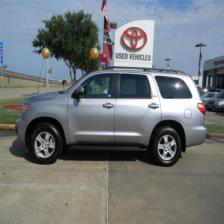

In [21]:
from IPython.display import display 
from PIL import Image

input_dir_cnn = "images/input_images_cnn"
test_image = os.listdir(input_dir_cnn)[10]
test_image = os.path.join(input_dir_cnn, test_image)
print(test_image)
display(Image.open(test_image))

In [22]:
img2vec = Img2VecResnet18()
I = Image.open(test_image)
test_vec = img2vec.getVec(I)
I.close()

print(len(test_vec))
print(test_vec)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


512
[9.76099730e-01 1.82788396e+00 1.45188034e+00 4.88855094e-01
 1.32217526e+00 2.34811649e-01 1.02424197e-01 8.84834528e-01
 1.17401755e+00 7.67984033e-01 3.82590115e-01 1.04513299e+00
 2.13129818e-01 2.26041079e+00 1.65910053e+00 1.60912126e-01
 1.19451940e+00 1.64447427e-01 3.04425448e-01 2.41846323e-01
 1.09171665e+00 2.34786677e+00 1.66806355e-01 8.38690221e-01
 4.28866714e-01 4.16915268e-01 5.94916284e-01 2.27848101e+00
 4.25808072e-01 6.57990932e-01 1.42789647e-01 3.59687835e-01
 5.46342254e-01 1.60631764e+00 7.14156270e-01 1.55168962e+00
 3.93080264e-01 1.10628116e+00 8.28398705e-01 7.24261820e-01
 5.76090097e-01 1.21913922e+00 2.41152272e-01 4.94427115e-01
 1.14191329e+00 5.42307198e-01 5.48802197e-01 1.39015928e-01
 1.13272142e+00 3.48664492e-01 8.47835004e-01 3.21671009e-01
 1.72273266e+00 6.14871442e-01 8.66621077e-01 1.29698122e+00
 7.90057302e-01 6.09337449e-01 3.26391399e-01 1.12517178e+00
 1.69766366e-01 7.93595433e-01 1.59751904e+00 4.35442716e-01
 6.33641779e-01 2.38

In [23]:
from pyspark.ml.linalg import Vectors

test_vector = Vectors.dense(test_vec)
print("Approximately searching lsh_df for 5 nearest neighbors of input vector:")
result = model.approxNearestNeighbors(lsh_df, test_vector, 5)
result.show()

Approximately searching lsh_df for 5 nearest neighbors of input vector:
+---------+--------------------+--------------------+--------------------+
|      _c0|            features|              hashes|             distCol|
+---------+--------------------+--------------------+--------------------+
|01299.jpg|[0.9760997,1.8278...|[[0.0], [0.0], [0...|4.928883660792961E-7|
|04091.jpg|[0.516605,0.80956...|[[-1.0], [0.0], [...|   10.49533234137972|
|00569.jpg|[0.9623975,2.8274...|[[0.0], [0.0], [0...|  10.533584979563951|
|06101.jpg|[1.2014766,1.9961...|[[-1.0], [0.0], [...|   10.53547515026972|
|03371.jpg|[0.84541136,2.116...|[[0.0], [0.0], [0...|  10.567985106492774|
+---------+--------------------+--------------------+--------------------+



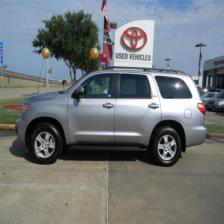

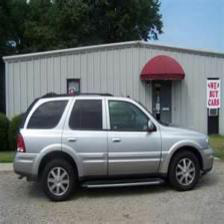

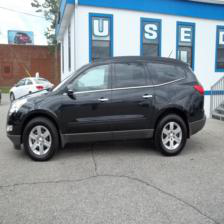

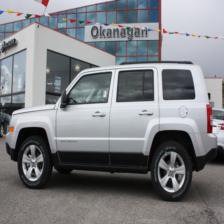

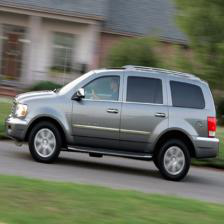

In [24]:
for i in list(result.select('_c0').toPandas()['_c0']): 
  display(Image.open(os.path.join(input_dir_cnn, i)))
